---
# <div align="center"><font color='green'> Traffic Sign Image Classification With CNN  </font></div>
---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import glob
from pathlib import Path
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import hashlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models

In [2]:
#!pip install -q -U keras-tuner
#!pip install opencv-python
import keras_tuner as kt
import cv2

In [3]:
# Check Tensorflow version
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

# Check if GPU is detected for tensorflow hardware acceleration
!python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

[]


# Introduction
The aim of this assignment is to train at least two models to classify images of European road traffic signs based on their sign shape or sign type. To do this, the specifically prepared dataset from the Belgium Traffic Sign Classification (TSC) Benchmark, consisting of 3699 grayscale images, is analysed using Jupyter Notebook and EDA is performed on the dataset to better understand the composition of the data. An ‘unseen’ independent evaluation dataset is used to evaluate the performance of each developed model and is compiled from a combination of images from the German TSC dataset, images from the internet, and digital photos taken personally from an iPhone.

Two different supervised machine learning algorithms are investigated: Artificial Neural Network (ANN) and Convolutional Neural Network (CNN), in conjunction with model optimisation techniques such as hyperparameter tuning, regularisation, dropout, data augmentation and edge detection filtering also being explored. Based on the results obtained from each model variation’s performance against the evaluation dataset, the model with the best evaluation metrics for each task is then identified. 


# Dataset
The dataset provided for this assignment is a modified version of the Belgium Traffic Sign Classification Benchmark which contains images of European road traffic signs taken from real-world vehicles. It consists of 3699 grayscale ‘.png’ images, each having a 28 (H) x 28 (W) pixel dimension. 

Images have been placed in sub-directories in the format of ./trafficsigns_dataset/{sign-shape}/ {sign-type}/, corresponding to its correct classification. For example, an image in the /diamond/ rightofway/ directory has a sign shape of ‘diamond’, and a sign type of ‘rightofway’. It is also noted that some sign types have different individual signs, such as the ‘speed’ sign type having signs from 10-70mph.

# Exploratory Data Analysis(Provided Data)

## Analyzing Data Distribution

In [4]:
image_list = []
base_dir = 'trafficsigns_dataset'

# Loop through each directory and append only images to image_list
for filepath in glob.glob(os.path.join(base_dir, '*', '*', '*.png')):
    filename = os.path.basename(filepath)
    sign_type = os.path.basename(os.path.dirname(filepath))
    sign_shape = os.path.basename(os.path.dirname(os.path.dirname(filepath)))
    image_path = os.path.join(sign_shape, sign_type)

    img = Image.open(filepath)
    img_hash = hashlib.md5(img.tobytes()).hexdigest()

    image_list.append(('./' + filepath, image_path, filename, sign_shape, sign_type, f"{img.width}x{img.height}", img_hash))
    img.close()
    
# create dataframe
data = pd.DataFrame(data=image_list, columns=['filepath', 'image_path', 'filename' ,'sign_shape' ,'sign_type', 'dimension', 'md5_hash'])

# Preview dataframe
data.head(10)
print("Dataframe shape: {}".format(data.shape))

Dataframe shape: (3699, 7)


In [5]:
# Output the result.
print("Following are the count of the number of images in each shape: \n")
data['image_path'].value_counts()

Following are the count of the number of images in each shape: 



image_path
triangle/warning          695
round/noentry             375
round/speed               316
round/bicycle             285
diamond/rightofway        282
square/parking            276
round/noparking           242
triangle/giveway          231
square/continue           199
round/trafficdirective    195
round/limitedtraffic      125
round/traveldirection     124
square/laneend            118
round/roundabout           98
square/crossing            95
hex/stop                   43
Name: count, dtype: int64

### Now I will analyze the number of images in each sub-directory i.e. image type in each shape using histogram

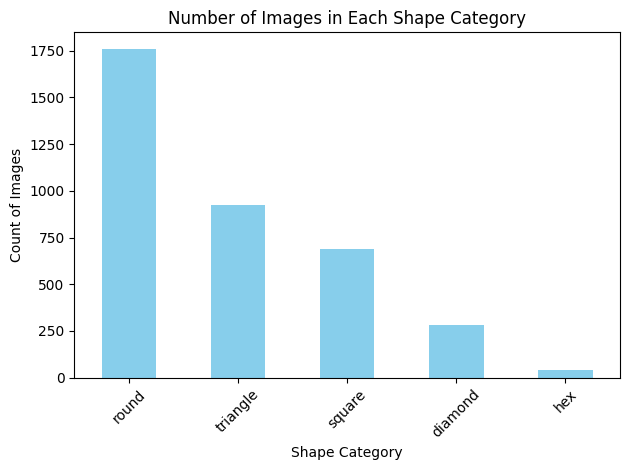

In [6]:
# plot histogram of sign shapes
data['sign_shape'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Images in Each Shape Category')
plt.xlabel('Shape Category')
plt.ylabel('Count of Images')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
plt.show()


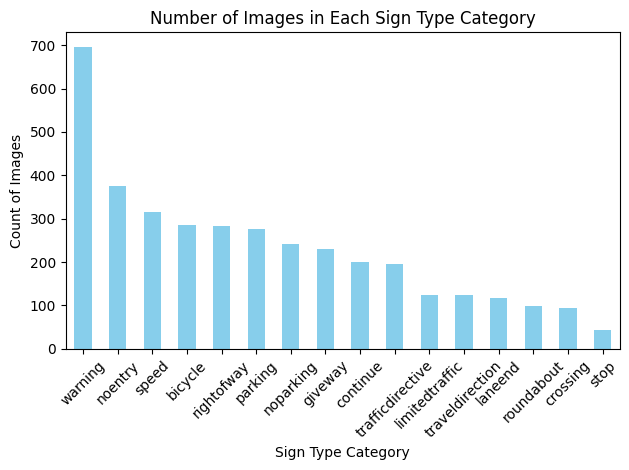

In [7]:
# plot histogram of sign shapes
data['sign_type'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Images in Each Sign Type Category')
plt.xlabel('Sign Type Category')
plt.ylabel('Count of Images')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
plt.show()


## Analyzing Size Distribution

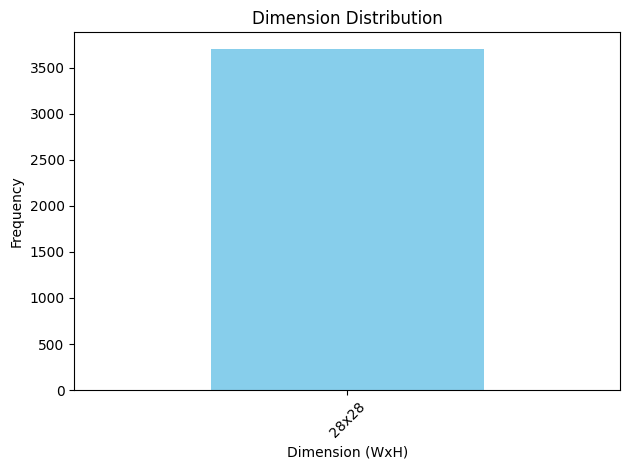

In [8]:
# Plotting
data['dimension'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Dimension Distribution')
plt.xlabel('Dimension (WxH)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Color Analysis

The following code computes and visualizes the average distribution of pixel intensities for the Red, Green, and Blue channels across all images in a specified dataset. It does this by:

1. Initializing storage to accumulate color data and track the number of images.
2. Iterating through the dataset's directory structure, processing each image to extract its color histograms.
3. Averaging these histograms by channel to get a sense of the typical color profile across the dataset.
4. Plotting the averaged histograms for visual analysis, presenting the commonality of pixel intensities in each color channel across the dataset.
The resulting visualizations provide insights into the dominant colors and brightness levels within the traffic sign images, which is valuable for understanding the data's characteristics and preparing for machine learning tasks.

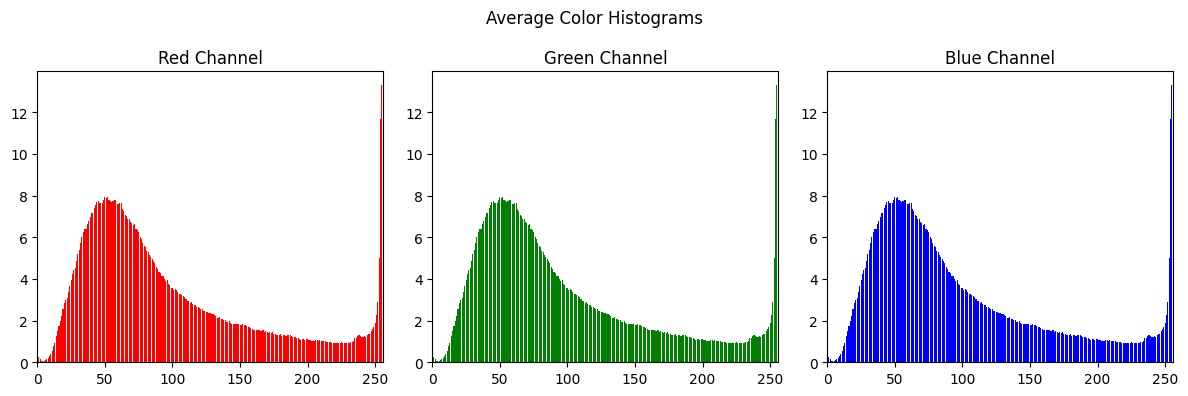

In [9]:
color_sums = [np.zeros(256), np.zeros(256), np.zeros(256)]  # For RGB channels
num_images = 0

# Loop through each subdirectory and compute color histograms
for image in image_list:
    file_path = image[0]
    with Image.open(file_path) as img:
        img = img.convert('RGB')  # Ensure image is in RGB
        for i in range(3):  # RGB channels
            hist, _ = np.histogram(img.getdata(band=i), bins=256, range=(0, 256))
            color_sums[i] += hist
        num_images += 1

# Calculate the average histograms
avg_histograms = [sums / num_images for sums in color_sums]

# Plot the average histograms
plt.figure(figsize=(12, 4))
colors = ['Red', 'Green', 'Blue']
for i, color in enumerate(colors):
    plt.subplot(1, 3, i + 1)
    plt.bar(range(256), avg_histograms[i], color=color.lower())
    plt.title(f'{color} Channel')
    plt.xlim([0, 256])
plt.suptitle('Average Color Histograms')
plt.tight_layout()
plt.show()


The following function checks whether a given image is in grayscale or not. 

In [10]:
def is_grey_scale(img_path):
    img = Image.open(img_path).convert('RGB')
    w, h = img.size
    for i in range(w):
        for j in range(h):
            r, g, b = img.getpixel((i, j))
            if r != g or r != b:
                return False
    return True

The following code is designed to automate the process of checking each image in the dataset to determine whether it is in grayscale or not. Here's what each part of the script does:

1. Set Base Directory: The base_dir variable is set to the directory containing the dataset, labeled 'trafficsigns_dataset'.
2. Iterate Through Directory Structure: The script loops through each subdirectory, which represents different shapes and types of traffic signs.
3. Open Each Image: Each image file is opened, and a check is performed to see if the image is in grayscale.
4. Check for Color: The is_grey_scale function (not shown in this snippet) is called for each image. This function checks if each pixel has the same value for the red, green, and blue color channels. If a pixel is found with differing values, the image is not in grayscale.
5. Output Result: If a colored image is found (meaning the image is not in grayscale), the script prints the path of the image and a message stating that not all images are in grayscale.
6. Early Exit: Once a single colored image is found, the script breaks out of the loop, ending the execution. This is done because only one instance of a colored image is needed to determine that the dataset is not entirely in grayscale.

In [11]:
for image in image_list:
    file_path = image[0]
    if not is_grey_scale(file_path):
        print(f"Colored image found: {file_path}")
        print("Not All Images Are Gray")
        break  # If one colored image is found, we can stop checking


## Data Splitting

Since we are are going to test our model with real world data which would be completely unseen, we are only splitting it into train and validation in 80 - 20 percent respectively.

In [12]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=2024)

print("Train data : {}, Val Data: {}".format(train_data.shape[0], val_data.shape[0]))

Train data : 2959, Val Data: 740


### Data Leakage Check

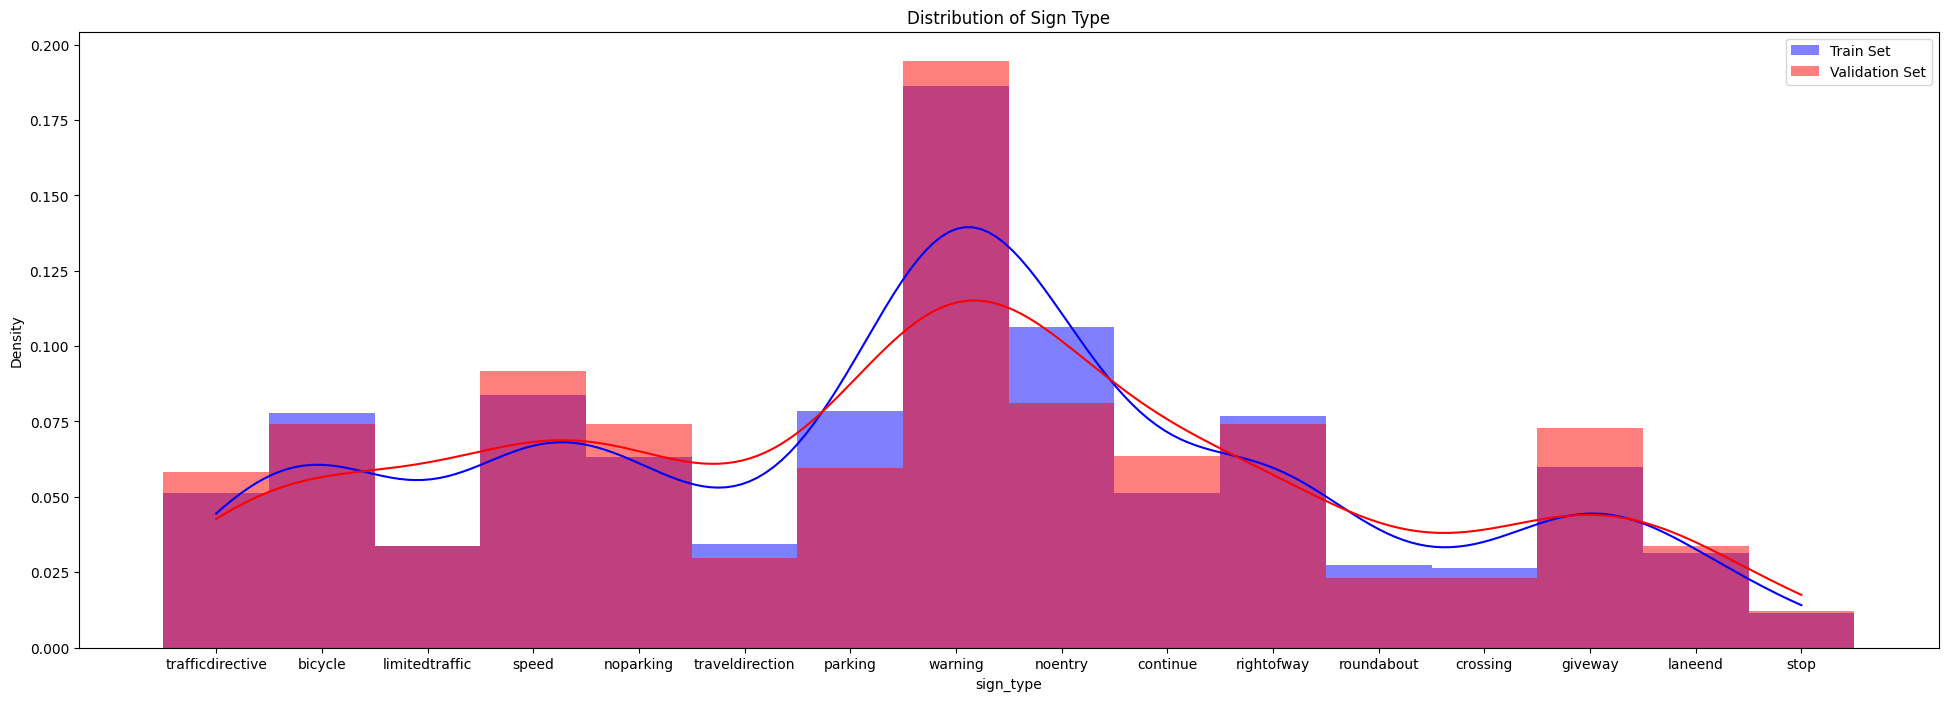

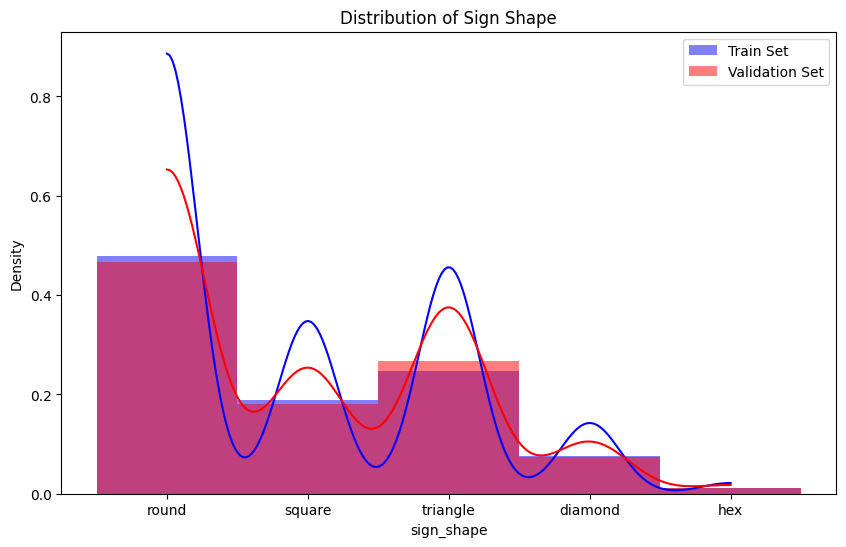

In [13]:
# Figure for 'sign_type'
plt.figure(figsize=(24, 8))  # Adjust the figure size as needed for clarity
sns.histplot(train_data['sign_type'], color="blue", label='Train Set', kde=True, stat="density", linewidth=0, alpha=0.5)
sns.histplot(val_data['sign_type'], color="red", label='Validation Set', kde=True, stat="density", linewidth=0, alpha=0.5)
plt.title('Distribution of Sign Type')
plt.legend()
plt.show()

# Figure for 'sign_shape'
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed for clarity
sns.histplot(train_data['sign_shape'], color="blue", label='Train Set', kde=True, stat="density", linewidth=0, alpha=0.5)
sns.histplot(val_data['sign_shape'], color="red", label='Validation Set', kde=True, stat="density", linewidth=0, alpha=0.5)
plt.title('Distribution of Sign Shape')
plt.legend()
plt.show()


#### Distribution of Sign Type
- **Overlap and Similarity**: Both training and validation sets show similar distributions for `sign_type`, suggesting that the validation set mirrors the training data well.
- **Density Peaks and Values**: There are consistent peaks across both datasets, indicating that each `sign_type` is represented similarly in both, which is crucial for model training.

#### Distribution of Sign Shape
- **Shape Distribution**: The histograms for `sign_shape` also demonstrate good overlap between the training and validation sets, showing that both sets contain similar proportions of each shape type.
- **Density and Peaks**: The presence of consistent peaks for common shapes like "round" and "square" across both datasets further confirms the good representation in both sets.

### Conclusion on Data Leakage
- **No Apparent Data Leakage**: The histograms do not display typical signs of data leakage, where features in the training set would excessively influence the model in a way not replicable in the validation set.
- **Good Dataset Split**: The data split appears to be effective, suggesting that the validation set can provide a realistic indication of the model's performance on new, unseen data.

These observations indicate that the dataset is well-prepared, with a balanced split that should support effective model training and validation.


##### Data Preprocessing and Image Data Generator Configuration

1. **ImageDataGenerator Setup**:
   - `ImageDataGenerator(rescale=1./255, data_format='channels_last')`: This function is initialized twice, once for training data and once for validation data. The `rescale=1./255` parameter is crucial as it normalizes the image pixel values to a range of 0 to 1, enhancing model training efficiency and performance. The `data_format='channels_last'` indicates that the image data has its color channels as the last dimension in the shape of the array. The `preprocessing_function=preprocessing_func` allows us to run a preprocessing function for each image, such as an edge detection filter.

2. **Training Data Generator**:
   - `flow_from_dataframe`: This method creates a generator that reads images from a dataframe, where each image is processed and augmented on-the-fly. This is set up for the training data.
   - `dataframe=train_data`: Specifies the dataframe containing the training data.
   - `directory='./'`: The directory where images are stored. The './' indicates that images are in the current directory.
   - `x_col='filepath'`: Column in the dataframe that contains the paths to the images.
   - `y_col='sign_shape'`: Column in the dataframe that contains the labels for image classification.
   - `target_size=(28, 28)`: Images are resized to 28x28 pixels as they are loaded.
   - `batch_size=32`: The size of the batches of data (number of images) to yield at a time.
   - `class_mode='categorical'`: Labels are returned as one-hot encoded arrays, suitable for categorical classification.
   - `color_mode='grayscale'`: Images are converted to grayscale (one color channel).
   - `seed=42`: Seed for random number generation, ensuring reproducibility of the shuffling and transformations.

3. **Validation Data Generator**:
   - Similar to the training data generator but with `shuffle=False` to ensure data is processed in order.
   - The absence of shuffling is typical for validation data to evaluate the model performance consistently across epochs.

##### Pre-processing: Edge detection filter
An edge detection filter is used in pre-processing in order to identify the edges in each image before they are used for model training. Depending on the characteristics of the image, and what the model is being used to predict, edge detection may increase performance of the model as it can remove ‘unnecessary’ information and in a way can be used as a form of feature extraction. The filter used in this assignment is Sobel, and where applied, is applied on training, validation and evaluation sets.

##### Pre-processing: Data Augmentation
Data augmentation is utilised on the training dataset only, to reduce overfitting of the model. The transformations vary for each batch, thereby artificially increasing the training dataset to reduce overfitting. The types of transformations used are:
    - `rotation_range = 10`: Rotates the image randomly between [-10,10]
    - `width_shift_range = 0.1`: Shifts the image horizontally randomly between [-10%, 10%]
    - `height_shift_range = 0.1`: Shifts the image vertically between [-10%, 10%]
    - `zoom_range = 0.15`: Zooms into the image between [-15%, 15%]
    - `fill_mode = ‘nearest’`: Fills any ‘blank’ areas from the transformations above with the nearest pixel and stretching it

### Purpose of the Setup

This setup ensures that both the training and validation datasets are prepared in a manner that supports efficient training of a neural network model. By normalizing the images and converting them to the appropriate size and color mode, the model can focus on learning the distinguishing features of the sign shapes without unnecessary computational overhead. The use of generators facilitates memory efficiency by loading images in batches rather than all at once, which is particularly beneficial when working with large datasets.


In [14]:
# Sobel filter
def apply_filter(img):
    grad_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
    grad_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)
    grad = np.sqrt(grad_x**2 + grad_y**2)
    grad_norm = (grad * 255 / grad.max()).astype(np.float64)
    #grad_norm = np.expand_dims(grad_norm, axis=-1)
    grad_norm = grad_norm[:, :, np.newaxis]

    return grad_norm

In [15]:
#preprocessing_func = None 
preprocessing_func = apply_filter 

# Setup the ImageDataGenerators
train_datagen_shape = ImageDataGenerator(rescale=1./255,
                                         preprocessing_function=preprocessing_func,
                                         data_format='channels_last')

# Data augmentation on the train set to reduce overfitting
train_datagen_shape_aug = ImageDataGenerator(rescale=1./255, 
                                         data_format='channels_last',
                                         preprocessing_function=preprocessing_func,
                                         rotation_range=10,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         horizontal_flip=False,
                                         fill_mode='nearest',
                                         vertical_flip=False,
                                         zoom_range=0.15)

val_datagen_shape = ImageDataGenerator(rescale=1./255,
                                       preprocessing_function=preprocessing_func,
                                       data_format='channels_last')

batch_size = 32

# Create generators that will read images from the dataframe and process them
train_generator_shape = train_datagen_shape.flow_from_dataframe(
    dataframe=train_data,
    directory='./',
    x_col="filepath",
    y_col="sign_shape",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42)

train_generator_shape_aug = train_datagen_shape_aug.flow_from_dataframe(
    dataframe=train_data,
    directory='./',
    x_col="filepath",
    y_col="sign_shape",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42)

validation_generator_shape = val_datagen_shape.flow_from_dataframe(
    dataframe=val_data,
    directory='./',
    x_col="filepath",
    y_col="sign_shape",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,
    seed=42)

# Retrieve the true labels
validation_shape_true_classes = validation_generator_shape.classes

Found 2959 validated image filenames belonging to 5 classes.
Found 2959 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


In [16]:
# Setup the ImageDataGenerators
train_datagen_type = ImageDataGenerator(rescale=1./255, 
                                        preprocessing_function=preprocessing_func,
                                        data_format='channels_last')

# Data augmentation on the train set to reduce overfitting
train_datagen_type_aug = ImageDataGenerator(rescale=1./255,
                                            data_format='channels_last',
                                            preprocessing_function=preprocessing_func,
                                            rotation_range=10,
                                            width_shift_range=0.1,
                                            height_shift_range=0.1,
                                            horizontal_flip=False,
                                            fill_mode='nearest',
                                            vertical_flip=False,
                                            zoom_range=0.15)

val_datagen_type = ImageDataGenerator(rescale=1./255, 
                                      preprocessing_function=preprocessing_func,
                                      data_format='channels_last')

batch_size = 32

# Create generators that will read images from the dataframe and process them
train_generator_type = train_datagen_type.flow_from_dataframe(
    dataframe=train_data,
    directory='./',
    x_col="filepath",
    y_col="sign_type",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42)

train_generator_type_aug = train_datagen_type_aug.flow_from_dataframe(
    dataframe=train_data,
    directory='./',
    x_col="filepath",
    y_col="sign_type",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42)

validation_generator_type = val_datagen_type.flow_from_dataframe(
    dataframe=val_data,
    directory='./',
    x_col="filepath",
    y_col="sign_type",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,
    seed=42)

# Retrieve the true labels
validation_type_true_classes = validation_generator_type.classes

Found 2959 validated image filenames belonging to 16 classes.
Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


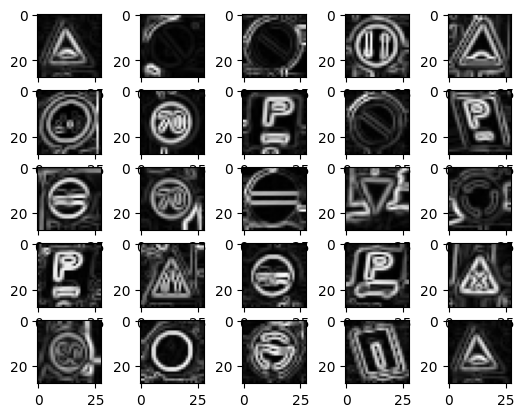

In [17]:
# Test to see if filter is applied properly
batches = 0
for x,y in validation_generator_shape:
    batches = batches + 1

    x = np.squeeze(x)
    if batches < 26:
        plt.subplot(5,5,batches)
        plt.imshow(x[0], cmap='gray')

    else:
        break

# Exploratory Data Analysis for Test Data (Unseen Data)

In [18]:
# go through trafficsigns_testset folders. Resizes, convert to grayscale, then re-save as png in new directory.
base_dir = 'trafficsigns_testset'
for filepath in glob.glob(os.path.join(base_dir, '*', '*', '*.jpg')):
    filename = os.path.basename(filepath)
    filename_excl_ext = Path(filename).stem
    sign_type = os.path.basename(os.path.dirname(filepath))
    sign_shape = os.path.basename(os.path.dirname(os.path.dirname(filepath)))
    image_path = os.path.join(sign_shape, sign_type)

    new_dir = os.path.join('trafficsigns_testset' + '_final', image_path)
    os.makedirs(new_dir, exist_ok=True)

    # convert to grayscale and resize
    img = Image.open(filepath).convert('L').resize((28,28))
     # save as png
    img.save(f"{new_dir}/" + filename_excl_ext + '.png')

    img.close()

In [19]:
eval_list = []
base_dir = 'trafficsigns_testset_final'

# Loop through each directory and append only images to image_list
for filepath in glob.glob(os.path.join(base_dir, '*', '*', '*.png')):
    filename = os.path.basename(filepath)
    sign_type = os.path.basename(os.path.dirname(filepath))
    sign_shape = os.path.basename(os.path.dirname(os.path.dirname(filepath)))
    image_path = os.path.join(sign_shape, sign_type)

    img = Image.open(filepath)
    img_hash = hashlib.md5(img.tobytes()).hexdigest()

    eval_list.append(('./' + filepath, image_path, filename, sign_shape, sign_type, f"{img.width}x{img.height}", img_hash))
    img.close()

# create dataframe
eval_data = pd.DataFrame(data=eval_list, columns=['filepath', 'image_path', 'filename' ,'sign_shape' ,'sign_type', 'dimension', 'md5_hash'])

# Preview dataframe
eval_data.head(10)
print("Dataframe shape: {}".format(eval_data.shape))

# double check if any images in evaluation set is in training/val datasets
eval_data_intersect = eval_data.md5_hash.isin(data.md5_hash).astype(int).sum()
if eval_data_intersect == 0:
    print("No intersect found between training/validation and evaluation datasets!")
else:
    print("Warning! Matches found between Training/Validation and Evaluation datasets: {}".format(eval_data_intersect))

Dataframe shape: (493, 7)
No intersect found between training/validation and evaluation datasets!


In [20]:
# Output the result.
print("Following are the count of the number of images in each shape: \n")
eval_data['image_path'].value_counts()

Following are the count of the number of images in each shape: 



image_path
triangle/warning          47
round/speed               46
hex/stop                  39
round/noentry             38
diamond/rightofway        37
round/trafficdirective    35
round/limitedtraffic      32
triangle/giveway          29
round/traveldirection     29
round/bicycle             27
square/parking            25
round/roundabout          24
square/laneend            22
round/noparking           22
square/crossing           21
square/continue           20
Name: count, dtype: int64

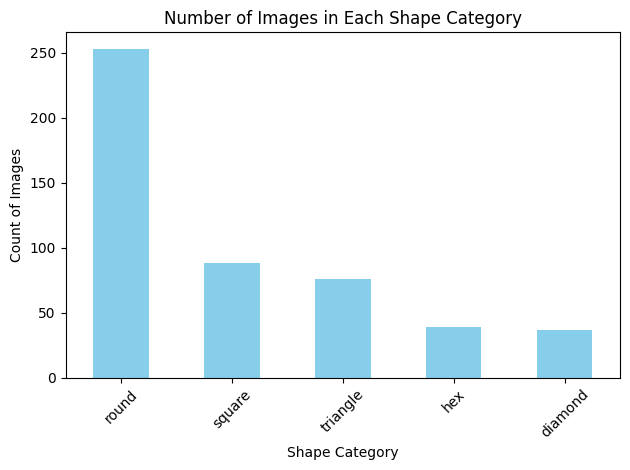

In [21]:
# plot histogram of sign shapes
eval_data['sign_shape'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Images in Each Shape Category')
plt.xlabel('Shape Category')
plt.ylabel('Count of Images')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
plt.show()

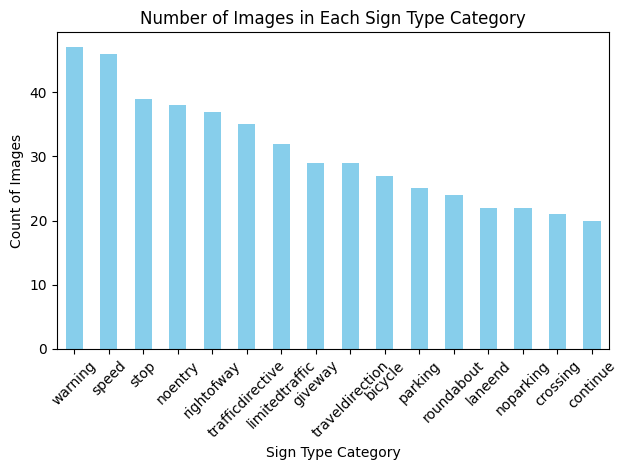

In [22]:
# plot histogram of sign shapes
eval_data['sign_type'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Images in Each Sign Type Category')
plt.xlabel('Sign Type Category')
plt.ylabel('Count of Images')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
plt.show()


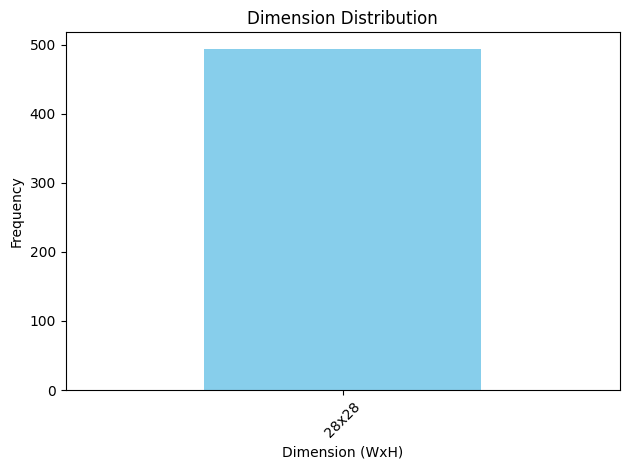

In [23]:
# Plotting
eval_data['dimension'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Dimension Distribution')
plt.xlabel('Dimension (WxH)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

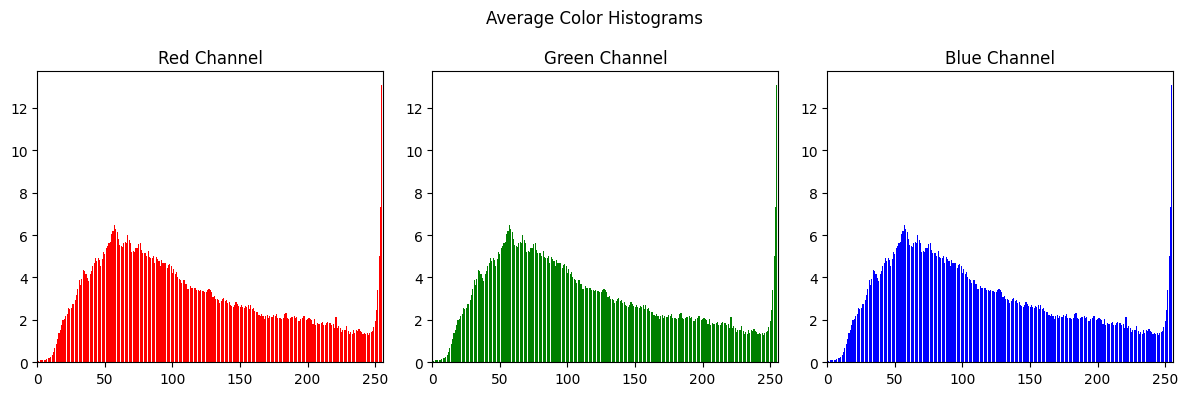

In [24]:
color_sums = [np.zeros(256), np.zeros(256), np.zeros(256)]  # For RGB channels
num_images = 0

# Loop through each subdirectory and compute color histograms
for image in eval_list:
    file_path = image[0]
    with Image.open(file_path) as img:
        img = img.convert('RGB')  # Ensure image is in RGB
        for i in range(3):  # RGB channels
            hist, _ = np.histogram(img.getdata(band=i), bins=256, range=(0, 256))
            color_sums[i] += hist
        num_images += 1

# Calculate the average histograms
avg_histograms = [sums / num_images for sums in color_sums]

# Plot the average histograms
plt.figure(figsize=(12, 4))
colors = ['Red', 'Green', 'Blue']
for i, color in enumerate(colors):
    plt.subplot(1, 3, i + 1)
    plt.bar(range(256), avg_histograms[i], color=color.lower())
    plt.title(f'{color} Channel')
    plt.xlim([0, 256])
plt.suptitle('Average Color Histograms')
plt.tight_layout()
plt.show()

In [25]:
for image in eval_list:
    file_path = image[0]
    if not is_grey_scale(file_path):
        print(f"Colored image found: {file_path}")
        print("Not All Images Are Gray")
        break  # If one colored image is found, we can stop checking

In [26]:
eval_datagen_shape = ImageDataGenerator(rescale=1./255, 
                                        preprocessing_function=preprocessing_func,
                                        data_format='channels_last')
eval_datagen_type = ImageDataGenerator(rescale=1./255, 
                                       preprocessing_function=preprocessing_func,
                                       data_format='channels_last')

eval_generator_shape = eval_datagen_shape.flow_from_dataframe(
    dataframe=eval_data,
    directory='./',
    x_col="filepath",
    y_col="sign_shape",
    target_size=(28, 28),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle = False,
    seed=42)

eval_generator_type = eval_datagen_type.flow_from_dataframe(
    dataframe=eval_data,
    directory='./',
    x_col="filepath",
    y_col="sign_type",
    target_size=(28, 28),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle = False,
    seed=42)

# Retrieve the true labels
eval_shape_true_classes = eval_generator_shape.classes
eval_type_true_classes = eval_generator_type.classes

Found 493 validated image filenames belonging to 5 classes.
Found 493 validated image filenames belonging to 16 classes.


## Evaluation Metric

### Chosen Metrics: Accuracy and Weighted F1-Score

#### Accuracy
- **General Performance Indicator**: Accuracy measures the overall correctness of the model, which is the ratio of correctly predicted observations to the total observations. It provides a quick and intuitive measure of the model's general effectiveness.
- **Simple and Transparent**: As a straightforward metric, accuracy gives a clear, easy-to-understand indication of how often the model is correct across all predictions.

#### Weighted F1-Score
- **Addresses Class Imbalance**: Given the uneven distribution of classes in our dataset, the weighted F1-Score is particularly useful. It adjusts the F1-Score for each class by the number of true instances, giving more weight to classes with more samples.
- **Balanced Evaluation**: This metric provides a balance between precision and recall in a single number, weighted by the class distribution. It is crucial for our dataset where some sign types and shapes are less frequent but equally important for the model to identify correctly.
- **Emphasis on Minority Classes**: By using a weighted approach, we ensure that the model's performance on less common classes significantly influences the overall score. This is vital in scenarios where failing to detect a rare but important class could be more consequential than misclassifying a more common class.

### Conclusion
The combination of accuracy and weighted F1-Score provides a comprehensive evaluation framework. Accuracy offers an overview of overall model performance, while weighted F1-Score provides depth by taking into account class imbalance, ensuring that our model performs well across all classes, not just the majority class.

# Model Development

## Baseline Model

We Will use ANN(Artifical Neural Network) as our baseline model. <br><br>
It is because: <br>
1. By starting with an ANN, we can establish a straightforward performance metric to see if the complexity added by CNNs(which we will do in later part) is justified. This is particularly useful in scenarios where deployment constraints (like computational resources) are a concern.


2. Ultimately, using an ANN as a baseline allows to set a performance benchmark for the dataset. We will later enhance our model architecture to a CNN and compare the performance to see if the increased complexity offers significant improvements in accuracy.

<p style="color: red;"> Note: We Will be training 2 seperate models(For Baseline) for classifying shape size and type</p>

In [27]:
# Function for plotting learning curve (Loss & selected metric)
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [28]:
# Function to randomly select images and show Predicted vs Actual class
def show_image_prediction(model_name, output_class, class_items, dataframe, preprocessing_func):

    datagen = ImageDataGenerator(rescale=1./255, 
                                 data_format='channels_last',
                                 preprocessing_function=preprocessing_func)

    # use same val_data set but with batch size 1 and generate a random image generator 
    image_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory='./',
        x_col="filepath",
        y_col=output_class,
        target_size=(28, 28),
        batch_size=1,
        class_mode='categorical',
        color_mode='grayscale')

    # predict the random val set and display result
    d_inv = {v: k for k, v in class_items.items()}
    plt.figure(figsize=(16,16))
    batches = 0
    for x,y in image_generator:
        batches = batches + 1
        y_hat = model_name.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 26:
            plt.subplot(5,5,batches)
            plt.imshow(x, cmap='gray')
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
    
        else:
            break
    
        plt.axis('off')

### ANN for Classifying Sign Shape

##### Model Architecture Rationale for above code

1. **Flatten Layer**:
   - **Purpose**: The `Flatten` layer is used to transform the 2D 28x28 pixel grayscale images into a 1D vector of 784 elements. This transformation is necessary because dense layers in a neural network accept vectors as input.
   - **Justification**: This approach is straightforward for small image datasets and serves well for initial exploration into neural network capabilities without the computational overhead of processing 2D features directly.

2. **Dense Layer (Hidden Layer)**:
   - **Purpose**: The hidden layer with 256 neurons is meant to capture the complex relationships and features from the flattened input vector.
   - **Justification**: Using a `relu` activation function helps to overcome issues associated with other activation functions like the sigmoid, particularly the vanishing gradient problem which can hinder training in deep networks. `Relu` is computationally efficient and typically provides better performance for hidden layers(Ahmad, I 2024, 'Sigmoid vs ReLU', Educative, viewed 5 May 2024, <https://www.educative.io/answers/sigmoid-vs-relu>).


3. **Output Layer**:
   - **Purpose**: This layer has 5 neurons, corresponding to the five classes of sign shapes (such as round, triangle, square, etc.).
   - **Justification**: No activation function is explicitly used here because the layer's output (logits) is directly utilized by the loss function due to `from_logits=True`. This setting in the loss function is more numerically stable and efficient as it internally applies a softmax on these logits before calculating the actual loss.

### Compilation Settings

- **Optimizer**: `adam`
  - **Justification**: Adam is an adaptive learning rate optimization algorithm that combines the best properties of the AdaGrad and RMSprop algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems(Vishwakarma, N 2023, 'What is Adam Optimizer?', Analytics Vidhya, viewed 5 May 2024, https://www.analyticsvidhya.com/blog/2023/09/what-is-adam-optimizer/).
- **Loss Function**: `CategoricalCrossentropy(from_logits=True)`
  - **Justification**: This choice is suitable for multi-class classification tasks. Using `from_logits=True` ensures that the softmax normalization is applied within the loss function itself, which enhances numerical stability.
- **Metrics**: `categorical_accuracy`
  - **Justification**: Monitoring 'categorical_accuracy' gives a direct indication of the percentage of predictions that are correct across all classes, which is crucial for evaluating the performance of the model in a multi-class classification scenario.

### Model Summary

- Utilize `model_sign_shape_ann.summary()` to visually inspect the structure and parameterization of the model, ensuring that all layers are correctly specified and the network is architecturally sound for the task at hand.


In [29]:
# Sign Shape ANN - ORIGINAL
INPUT_DIM = (28,28,1)
HIDDEN_LAYER_DIM = 256
SHAPE_OUTPUT_CLASSES = 5

model_shape_ann_1 = tf.keras.Sequential([
    # Input Layer
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    # Hidden Layer
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    # Output Layer
    tf.keras.layers.Dense(SHAPE_OUTPUT_CLASSES)
])

model_shape_ann_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'])

model_shape_ann_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 202,245
Trainable params: 202,245
Non-trainable params: 0
_________________________________________________________________


##### Explanation of Code:

- **Function Call**: `plot_learning_curve` is a custom function designed to plot learning curves for loss and accuracy metrics over training epochs.
- **Arguments**:
  - `history_shape_ann.history['loss']`: This retrieves the loss values from the training history for each epoch during the training phase.
  - `history_shape_ann.history['val_loss']`: This retrieves the validation loss for each epoch, indicating how well the model is generalizing to new, unseen data.
  - `history_shape_ann.history['categorical_accuracy']`: Retrieves the accuracy of the model on the training set for each epoch.
  - `history_shape_ann.history['val_categorical_accuracy']`: Retrieves the accuracy on the validation set, which helps to assess the model's performance on data it has not been trained on.
  - `metric_name='Accuracy'`: A string that might be used within the function to label the plots or for logging purposes.

##### Critical Analysis of the Graphs:

- **Loss Graph (Left)**
  - **Trends**: Both the training and validation loss decrease sharply initially, which is typical as the model learns from the training data. After the sharp decline, both losses tend to plateau, indicating that the model is starting to converge.
  - **Gap Between Curves**: The training and validation loss remain close throughout the training process, which suggests that the model is not overfitting significantly. This closeness indicates good generalization to unseen data.

- **Accuracy Graph (Right)**
  - **Trends**: Accuracy for both training and validation increases sharply at the beginning and then levels off, similar to the loss graph. This pattern shows that the model quickly learns the dominant patterns in the data.
  - **Gap Between Curves**: There is a slight gap between the training and validation accuracy, with the training accuracy being slightly higher. This is normal but could indicate overfitting.


In [30]:
train_generator_shape_aug.reset()
validation_generator_shape.reset()

history_shape_ann_1 = model_shape_ann_1.fit(train_generator_shape_aug, validation_data = validation_generator_shape, epochs=100, verbose=2)

Epoch 1/100
93/93 - 1s - loss: 0.9002 - categorical_accuracy: 0.6722 - val_loss: 0.5519 - val_categorical_accuracy: 0.7878 - 901ms/epoch - 10ms/step
Epoch 2/100
93/93 - 1s - loss: 0.6727 - categorical_accuracy: 0.7475 - val_loss: 0.4519 - val_categorical_accuracy: 0.8473 - 643ms/epoch - 7ms/step
Epoch 3/100
93/93 - 1s - loss: 0.5989 - categorical_accuracy: 0.7739 - val_loss: 0.4322 - val_categorical_accuracy: 0.8351 - 663ms/epoch - 7ms/step
Epoch 4/100
93/93 - 1s - loss: 0.5887 - categorical_accuracy: 0.7793 - val_loss: 0.4505 - val_categorical_accuracy: 0.8446 - 673ms/epoch - 7ms/step
Epoch 5/100
93/93 - 1s - loss: 0.5452 - categorical_accuracy: 0.7918 - val_loss: 0.4449 - val_categorical_accuracy: 0.8257 - 669ms/epoch - 7ms/step
Epoch 6/100
93/93 - 1s - loss: 0.5107 - categorical_accuracy: 0.8064 - val_loss: 0.3297 - val_categorical_accuracy: 0.8824 - 675ms/epoch - 7ms/step
Epoch 7/100
93/93 - 1s - loss: 0.4913 - categorical_accuracy: 0.8182 - val_loss: 0.3245 - val_categorical_accur

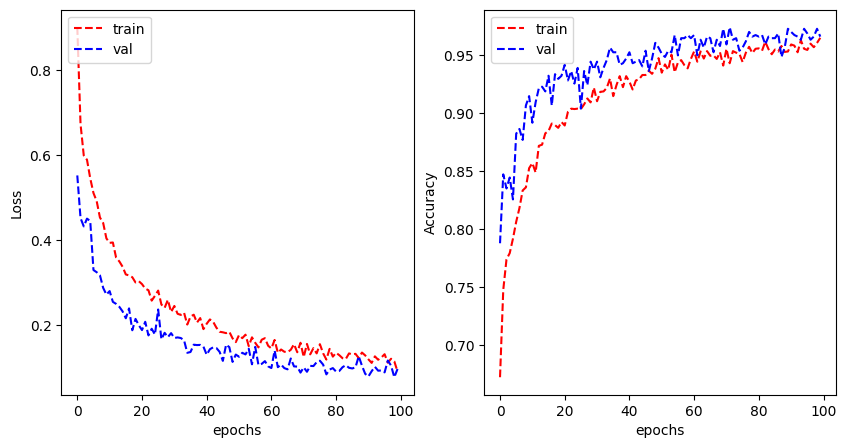

In [31]:
plot_learning_curve(history_shape_ann_1.history['loss'], history_shape_ann_1.history['val_loss'], 
                    history_shape_ann_1.history['categorical_accuracy'], history_shape_ann_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

#### Early Stopping 
Early Stopping is a regularisation technique which terminates training when the selected metric no longer improves within a chosen ‘patience’ period, reducing overfitting. For unoptimised models: Model is fitted using early stopping based on validation loss with a patience of 5 epochs.


In [32]:
# Set early stopping if no improvements within 5 epochs
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Re-run with early stopping
train_generator_shape_aug.reset()
validation_generator_shape.reset()
model_shape_ann_1.fit(train_generator_shape_aug, validation_data = validation_generator_shape, epochs=100, callbacks=[stop_early], verbose=2)
print("Early stopping at Epoch #{}".format(stop_early.stopped_epoch))

Epoch 1/100
93/93 - 1s - loss: 0.1227 - categorical_accuracy: 0.9557 - val_loss: 0.1182 - val_categorical_accuracy: 0.9595 - 703ms/epoch - 8ms/step
Epoch 2/100
93/93 - 1s - loss: 0.1137 - categorical_accuracy: 0.9567 - val_loss: 0.1085 - val_categorical_accuracy: 0.9595 - 694ms/epoch - 7ms/step
Epoch 3/100
93/93 - 1s - loss: 0.1046 - categorical_accuracy: 0.9652 - val_loss: 0.1099 - val_categorical_accuracy: 0.9689 - 679ms/epoch - 7ms/step
Epoch 4/100
93/93 - 1s - loss: 0.1138 - categorical_accuracy: 0.9591 - val_loss: 0.0914 - val_categorical_accuracy: 0.9703 - 682ms/epoch - 7ms/step
Epoch 5/100
93/93 - 1s - loss: 0.1026 - categorical_accuracy: 0.9662 - val_loss: 0.0924 - val_categorical_accuracy: 0.9730 - 658ms/epoch - 7ms/step
Epoch 6/100
93/93 - 1s - loss: 0.1082 - categorical_accuracy: 0.9642 - val_loss: 0.0799 - val_categorical_accuracy: 0.9770 - 641ms/epoch - 7ms/step
Epoch 7/100
93/93 - 1s - loss: 0.1013 - categorical_accuracy: 0.9659 - val_loss: 0.0825 - val_categorical_accura

In [33]:
# save or load the model 
# model_shape_ann_1.save("model_shape_ann_1_filter.h5")
model_shape_ann_1 = tf.keras.models.load_model("models/model_shape_ann_1_filter.h5")

In [34]:
validation_generator_shape.reset()
validation_shape_ann_1_predictions = model_shape_ann_1.predict(validation_generator_shape)
validation_shape_ann_1_predicted_classes = np.argmax(validation_shape_ann_1_predictions, axis=1)

# print classification report
print(classification_report(validation_shape_true_classes, validation_shape_ann_1_predicted_classes, target_names=validation_generator_shape.class_indices.keys()))

24/24 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

     diamond       1.00      0.98      0.99        55
         hex       1.00      0.89      0.94         9
       round       0.99      1.00      1.00       345
      square       0.96      1.00      0.98       133
    triangle       0.99      0.97      0.98       198

    accuracy                           0.99       740
   macro avg       0.99      0.97      0.98       740
weighted avg       0.99      0.99      0.99       740



The confusion matrix visualizes the performance of the classification model across different classes. Here, the classes include diamond, hex, round, square, and triangle. Each cell in the matrix represents the number of images predicted for a class versus the true class.

- **Rows**: True labels
- **Columns**: Predicted labels

##### Observations:

- **Diamonds**:
  - Correctly predicted as diamond: 51 times.
  - Misclassified as round: 4 times.
  - No misclassifications as hex, square, or triangle.

- **Hex**:
  - Correctly predicted as hex: 7 times.
  - Misclassified as round: 2 times.
  - No misclassifications as diamond, square, or triangle.

- **Round**:
  - Correctly predicted as round: 345 times.
  - Perfect classification with no misclassifications.

- **Square**:
  - Correctly predicted as square: 123 times.
  - Misclassified as diamond: 1 time.
  - Misclassified as round: 9 times.
  - No misclassifications as hex or triangle.

- **Triangle**:
  - Correctly predicted as triangle: 188 times.
  - Misclassified as diamond: 2 times.
  - Misclassified as round: 8 times.
  - No misclassifications as hex or square.

##### Summary:

- **High Accuracy for Round Signs**: The round signs are perfectly predicted with no errors, indicating very strong classifier performance for this shape.
- **Most Common Misclassification**: Misclassification mostly occurs with shapes being incorrectly predicted as round. This suggests that the model may have a bias or higher sensitivity towards predicting signs as round, which could be due to the round class having a significantly higher number of samples compared to others.
- **Performance on Rare Classes**: Hex, having fewer instances, still achieves a reasonable prediction accuracy but also sees some misclassifications as round, suggesting potential issues with class imbalance.

## Optimised ANN for Sign Shape

#### Hyperparameter tuning
For ANN models, the number of neurons in the first hidden layer, and the learning rate are tuned. 


In [35]:
# Function for HP tuning 
def build_model_shape_ann_opt(hp):

    INPUT_DIM = (28,28,1)
    SHAPE_OUTPUT_CLASSES = 5

    #hyperparameter tuning - number of hidden layer neurons
    hp_hidden_layer_dim = hp.Int('units',min_value=32,max_value=512,step=32)

    model_shape_ann_opt = tf.keras.Sequential([
        #Input layer
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        #Hidden layer
        tf.keras.layers.Dense(units=hp_hidden_layer_dim, activation='relu'),
        #Output layer
        tf.keras.layers.Dense(SHAPE_OUTPUT_CLASSES)
    ])

    #hyperparameter tuning - learning rate
    hp_lr = hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])

    #Use adam optimiser
    model_shape_ann_opt.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['categorical_accuracy'])

    return model_shape_ann_opt

#### Early stopping
For optimised models: Early stopping is used during tuning to find the optimal hyperparameter. Model is then rebuilt using the optimal values to find the epoch with the lowest validation loss, and finally the model is rebuilt and trained only to the optimal epoch.


In [36]:
# Conduct hyperparameter tuning based on Bayesian Optimisation
tuner_shape_ann=kt.BayesianOptimization(
    build_model_shape_ann_opt,
    objective='val_categorical_accuracy',
    max_trials=10,
    directory='tuner',
    seed=42,
    project_name='sign_shape_ann_filter')

# Summary of search space
tuner_shape_ann.search_space_summary()

# Run search with early stopping
train_generator_shape_aug.reset()
validation_generator_shape.reset()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner_shape_ann.search(train_generator_shape_aug, validation_data = validation_generator_shape, epochs=100, callbacks=[stop_early], verbose=2)

Reloading Tuner from tuner/sign_shape_ann_filter/tuner0.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [37]:
best_hps=tuner_shape_ann.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimiser
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 512 and the optimal learning rate for the optimiser
is 0.001.



In [38]:
# Build and train optimised model
model_shape_ann_opt = tuner_shape_ann.hypermodel.build(best_hps)
train_generator_shape_aug.reset()
validation_generator_shape.reset()
history_shape_ann_opt = model_shape_ann_opt.fit(train_generator_shape_aug, validation_data = validation_generator_shape, epochs=100, verbose=2)

Epoch 1/100
93/93 - 1s - loss: 0.8484 - categorical_accuracy: 0.6742 - val_loss: 0.5017 - val_categorical_accuracy: 0.8324 - 868ms/epoch - 9ms/step
Epoch 2/100
93/93 - 1s - loss: 0.6697 - categorical_accuracy: 0.7587 - val_loss: 0.4230 - val_categorical_accuracy: 0.8473 - 719ms/epoch - 8ms/step
Epoch 3/100
93/93 - 1s - loss: 0.5895 - categorical_accuracy: 0.7773 - val_loss: 0.3848 - val_categorical_accuracy: 0.8649 - 657ms/epoch - 7ms/step
Epoch 4/100
93/93 - 1s - loss: 0.5374 - categorical_accuracy: 0.7962 - val_loss: 0.3653 - val_categorical_accuracy: 0.8689 - 651ms/epoch - 7ms/step
Epoch 5/100
93/93 - 1s - loss: 0.4927 - categorical_accuracy: 0.8148 - val_loss: 0.3327 - val_categorical_accuracy: 0.8784 - 687ms/epoch - 7ms/step
Epoch 6/100
93/93 - 1s - loss: 0.4710 - categorical_accuracy: 0.8202 - val_loss: 0.3339 - val_categorical_accuracy: 0.8622 - 671ms/epoch - 7ms/step
Epoch 7/100
93/93 - 1s - loss: 0.4470 - categorical_accuracy: 0.8385 - val_loss: 0.2836 - val_categorical_accura

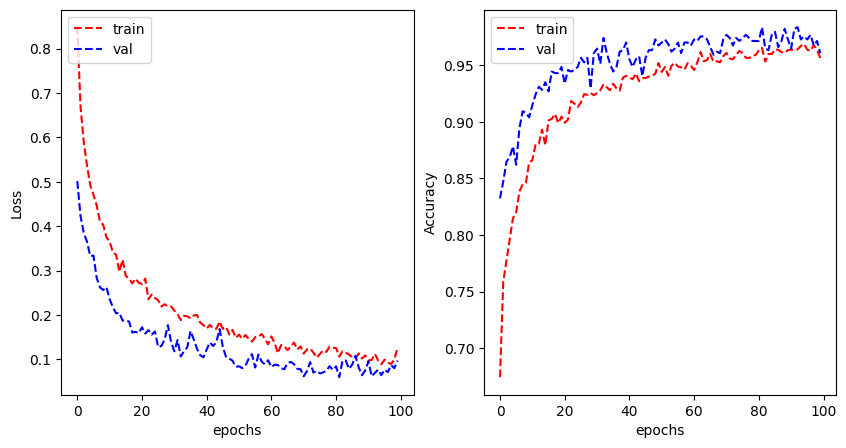

In [39]:
plot_learning_curve(history_shape_ann_opt.history['loss'], history_shape_ann_opt.history['val_loss'],
                    history_shape_ann_opt.history['categorical_accuracy'], history_shape_ann_opt.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [40]:
# Get best epoch
val_loss_per_epoch = history_shape_ann_opt.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

model_shape_ann_opt = tuner_shape_ann.hypermodel.build(best_hps)
train_generator_shape_aug.reset()
validation_generator_shape.reset()
model_shape_ann_opt.fit(train_generator_shape_aug, validation_data = validation_generator_shape, epochs=best_epoch, verbose=2)

Best epoch: 82
Epoch 1/82
93/93 - 1s - loss: 0.8464 - categorical_accuracy: 0.6749 - val_loss: 0.5192 - val_categorical_accuracy: 0.8189 - 812ms/epoch - 9ms/step
Epoch 2/82
93/93 - 1s - loss: 0.6587 - categorical_accuracy: 0.7563 - val_loss: 0.4972 - val_categorical_accuracy: 0.8122 - 670ms/epoch - 7ms/step
Epoch 3/82
93/93 - 1s - loss: 0.5687 - categorical_accuracy: 0.7871 - val_loss: 0.3917 - val_categorical_accuracy: 0.8459 - 868ms/epoch - 9ms/step
Epoch 4/82
93/93 - 1s - loss: 0.5279 - categorical_accuracy: 0.7982 - val_loss: 0.3626 - val_categorical_accuracy: 0.8662 - 856ms/epoch - 9ms/step
Epoch 5/82
93/93 - 1s - loss: 0.5131 - categorical_accuracy: 0.8080 - val_loss: 0.3326 - val_categorical_accuracy: 0.8919 - 696ms/epoch - 7ms/step
Epoch 6/82
93/93 - 1s - loss: 0.4777 - categorical_accuracy: 0.8216 - val_loss: 0.3252 - val_categorical_accuracy: 0.8824 - 678ms/epoch - 7ms/step
Epoch 7/82
93/93 - 1s - loss: 0.4345 - categorical_accuracy: 0.8425 - val_loss: 0.2860 - val_categorica

In [41]:
# save or load the model 
# model_shape_ann_opt.save("model_shape_ann_opt_filter.h5")
model_shape_ann_opt = tf.keras.models.load_model("models/model_shape_ann_opt_filter.h5")

In [42]:
# Evaluate with validation set
validation_generator_shape.reset()
validation_shape_ann_opt_predictions = model_shape_ann_opt.predict(validation_generator_shape)
validation_shape_ann_opt_predicted_classes = np.argmax(validation_shape_ann_opt_predictions, axis=1)

# print classification report
print(classification_report(validation_shape_true_classes, validation_shape_ann_opt_predicted_classes, target_names=validation_generator_shape.class_indices.keys()))

24/24 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

     diamond       1.00      0.98      0.99        55
         hex       1.00      0.89      0.94         9
       round       0.99      1.00      1.00       345
      square       1.00      0.99      1.00       133
    triangle       0.99      1.00      0.99       198

    accuracy                           0.99       740
   macro avg       1.00      0.97      0.98       740
weighted avg       0.99      0.99      0.99       740



### ANN for Shape Type

In [43]:
# Sign Type ANN - ORIGINAL
INPUT_DIM = (28,28,1)
HIDDEN_LAYER_DIM = 256
TYPE_OUTPUT_CLASSES = 16

model_type_ann_1 = tf.keras.Sequential([
    # Input Layer
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    # Hidden Layer
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    #Output Layer
    tf.keras.layers.Dense(TYPE_OUTPUT_CLASSES)
])

model_type_ann_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'])

model_type_ann_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               200960    
                                                                 
 dense_7 (Dense)             (None, 16)                4112      
                                                                 
Total params: 205,072
Trainable params: 205,072
Non-trainable params: 0
_________________________________________________________________


##### Model Architecture Rationale for above code
<p style="color: red;"> Note: The above architecture is exactly same as the one for classifying sign shape and hence the same rationale</p>
1. **Flatten Layer**:
   - **Purpose**: The `Flatten` layer is used to transform the 2D 28x28 pixel grayscale images into a 1D vector of 784 elements. This transformation is necessary because dense layers in a neural network accept vectors as input.
   - **Justification**: This approach is straightforward for small image datasets and serves well for initial exploration into neural network capabilities without the computational overhead of processing 2D features directly.

2. **Dense Layer (Hidden Layer)**:
   - **Purpose**: The hidden layer with 256 neurons is meant to capture the complex relationships and features from the flattened input vector.
   - **Justification**: Using a `relu` activation function helps to overcome issues associated with other activation functions like the sigmoid, particularly the vanishing gradient problem which can hinder training in deep networks. `Relu` is computationally efficient and typically provides better performance for hidden layers(Ahmad, I 2024, 'Sigmoid vs ReLU', Educative, viewed 5 May 2024, <https://www.educative.io/answers/sigmoid-vs-relu>).


3. **Output Layer**:
   - **Purpose**: This layer has 5 neurons, corresponding to the five classes of sign shapes (such as round, triangle, square, etc.).
   - **Justification**: No activation function is explicitly used here because the layer's output (logits) is directly utilized by the loss function due to `from_logits=True`. This setting in the loss function is more numerically stable and efficient as it internally applies a softmax on these logits before calculating the actual loss.

### Compilation Settings

- **Optimizer**: `adam`
  - **Justification**: Adam is an adaptive learning rate optimization algorithm that combines the best properties of the AdaGrad and RMSprop algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems(Vishwakarma, N 2023, 'What is Adam Optimizer?', Analytics Vidhya, viewed 5 May 2024, https://www.analyticsvidhya.com/blog/2023/09/what-is-adam-optimizer/).
- **Loss Function**: `CategoricalCrossentropy(from_logits=True)`
  - **Justification**: This choice is suitable for multi-class classification tasks. Using `from_logits=True` ensures that the softmax normalization is applied within the loss function itself, which enhances numerical stability.
- **Metrics**: `categorical_accuracy`
  - **Justification**: Monitoring 'categorical_accuracy' gives a direct indication of the percentage of predictions that are correct across all classes, which is crucial for evaluating the performance of the model in a multi-class classification scenario.

### Model Summary

- Utilize `model_sign_shape_ann.summary()` to visually inspect the structure and parameterization of the model, ensuring that all layers are correctly specified and the network is architecturally sound for the task at hand.


##### Data Preprocessing and Image Data Generator Configuration

1. **ImageDataGenerator Setup**:
   - `ImageDataGenerator(rescale=1./255, data_format='channels_last')`: This function is initialized twice, once for training data and once for validation data. The `rescale=1./255` parameter is crucial as it normalizes the image pixel values to a range of 0 to 1, enhancing model training efficiency and performance. The `data_format='channels_last'` indicates that the image data has its color channels as the last dimension in the shape of the array.

2. **Training Data Generator**:
   - `flow_from_dataframe`: This method creates a generator that reads images from a dataframe, where each image is processed and augmented on-the-fly. This is set up for the training data.
   - `dataframe=train_data`: Specifies the dataframe containing the training data.
   - `directory='./'`: The directory where images are stored. The './' indicates that images are in the current directory.
   - `x_col='filepath'`: Column in the dataframe that contains the paths to the images.
   - `y_col='sign_type'`: Column in the dataframe that contains the labels for image classification.
   - `target_size=(28, 28)`: Images are resized to 28x28 pixels as they are loaded.
   - `batch_size=32`: The size of the batches of data (number of images) to yield at a time.
   - `class_mode='categorical'`: Labels are returned as one-hot encoded arrays, suitable for categorical classification.
   - `color_mode='grayscale'`: Images are converted to grayscale (one color channel).
   - `seed=42`: Seed for random number generation, ensuring reproducibility of the shuffling and transformations.

3. **Validation Data Generator**:
   - Similar to the training data generator but with `shuffle=False` to ensure data is processed in order.
   - The absence of shuffling is typical for validation data to evaluate the model performance consistently across epochs.

### Purpose of the Setup

This setup ensures that both the training and validation datasets are prepared in a manner that supports efficient training of a neural network model. By normalizing the images and converting them to the appropriate size and color mode, the model can focus on learning the distinguishing features of the sign shapes without unnecessary computational overhead. The use of generators facilitates memory efficiency by loading images in batches rather than all at once, which is particularly beneficial when working with large datasets.

In [44]:
train_generator_type_aug.reset()
validation_generator_type.reset()
history_type_ann_1 = model_type_ann_1.fit(train_generator_type_aug, validation_data = validation_generator_type, epochs=100, verbose=2)

Epoch 1/100
93/93 - 1s - loss: 1.8060 - categorical_accuracy: 0.4589 - val_loss: 1.0849 - val_categorical_accuracy: 0.6838 - 817ms/epoch - 9ms/step
Epoch 2/100
93/93 - 1s - loss: 1.3298 - categorical_accuracy: 0.5978 - val_loss: 0.8876 - val_categorical_accuracy: 0.7378 - 659ms/epoch - 7ms/step
Epoch 3/100
93/93 - 1s - loss: 1.1631 - categorical_accuracy: 0.6232 - val_loss: 0.7615 - val_categorical_accuracy: 0.7784 - 707ms/epoch - 8ms/step
Epoch 4/100
93/93 - 1s - loss: 1.0880 - categorical_accuracy: 0.6580 - val_loss: 0.7336 - val_categorical_accuracy: 0.7811 - 658ms/epoch - 7ms/step
Epoch 5/100
93/93 - 1s - loss: 1.0191 - categorical_accuracy: 0.6847 - val_loss: 0.6866 - val_categorical_accuracy: 0.8014 - 686ms/epoch - 7ms/step
Epoch 6/100
93/93 - 1s - loss: 0.9952 - categorical_accuracy: 0.6850 - val_loss: 0.6705 - val_categorical_accuracy: 0.7959 - 666ms/epoch - 7ms/step
Epoch 7/100
93/93 - 1s - loss: 0.9343 - categorical_accuracy: 0.7097 - val_loss: 0.6835 - val_categorical_accura

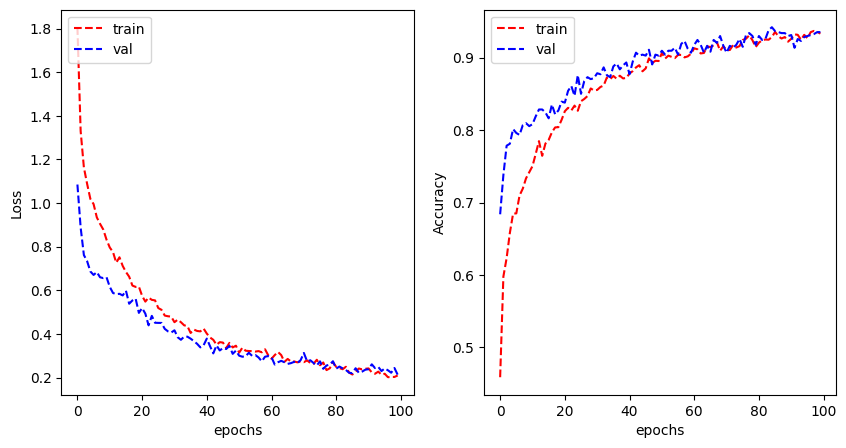

In [45]:
plot_learning_curve(history_type_ann_1.history['loss'], history_type_ann_1.history['val_loss'],
                    history_type_ann_1.history['categorical_accuracy'], history_type_ann_1.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

##### Critical Analysis of Learning Curves for Classifying Sign Type

###### Loss Graph Analysis (Left)
- **Rapid Decline in Initial Epochs**: Both the training and validation loss decrease sharply in the first few epochs, suggesting that the model is quickly learning from the training data. 
- **Convergence Behavior**: Post the initial drop, both losses continue to decrease but at a much slower rate and approach a plateau, indicating that the model is nearing optimal performance under the current configuration.
- **Training vs. Validation Loss**: The training loss is consistently lower than the validation loss. This gap, while typical, suggests effective learning but can indicate overfitting.

###### Accuracy Graph Analysis (Right)
- **Steady Increase in Accuracy**: There is a steady increase in both training and validation accuracies. Training accuracy approaches near-perfect levels, demonstrating effective learning of the training dataset.
- **Validation Accuracy**: Validation accuracy also increases but levels off and slightly dips towards the end, which might suggest the onset of overfitting or limitations in the model's ability to generalize based on the current training.
- **Gap Between Curves**: A noticeable gap between training and validation accuracy, particularly in later epochs, suggests possible overfitting, where the model may be memorizing the training data rather than learning to generalize(Ibrahim, M 2024, 'A Deep Dive Into Learning Curves in Machine Learning', W&B (Weights & Biases), viewed 5 May 2024, https://wandb.ai/mostafaibrahim17/ml-articles/reports/A-Deep-Dive-Into-Learning-Curves-in-Machine-Learning--Vmlldzo0NjA1ODY0).

###### Overall Observations
- **Performance and Overfitting Concerns**: The model demonstrates strong performance on the training data, but there are signs of potential overfitting, indicated by the plateau in validation accuracy and the gap between training and validation accuracy. This slight drop in validation accuracy at later epochs suggests that the model may be memorizing the training data rather than learning to generalize effectively. To address this, we will consider implementing strategies such as introducing dropout, applying regularization techniques, or adjusting the model's complexity to enhance generalization capabilities.


These observations suggest that while the model is learning effectively, there is room for tuning to balance the fit and ensure better generalization across unseen data.


In [46]:
# Set early stopping if no improvements within 5 epochs
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Re-run with early stopping
train_generator_type.reset()
validation_generator_type.reset()
model_type_ann_1.fit(train_generator_type, validation_data = validation_generator_type, epochs=100, callbacks=[stop_early], verbose=2)
print("Early stopping at Epoch #{}".format(stop_early.stopped_epoch))

Epoch 1/100


93/93 - 0s - loss: 0.0586 - categorical_accuracy: 0.9845 - val_loss: 0.1666 - val_categorical_accuracy: 0.9514 - 435ms/epoch - 5ms/step
Epoch 2/100
93/93 - 0s - loss: 0.0210 - categorical_accuracy: 0.9980 - val_loss: 0.1542 - val_categorical_accuracy: 0.9595 - 382ms/epoch - 4ms/step
Epoch 3/100
93/93 - 0s - loss: 0.0120 - categorical_accuracy: 1.0000 - val_loss: 0.1442 - val_categorical_accuracy: 0.9649 - 384ms/epoch - 4ms/step
Epoch 4/100
93/93 - 0s - loss: 0.0089 - categorical_accuracy: 0.9997 - val_loss: 0.1433 - val_categorical_accuracy: 0.9622 - 387ms/epoch - 4ms/step
Epoch 5/100
93/93 - 0s - loss: 0.0071 - categorical_accuracy: 1.0000 - val_loss: 0.1394 - val_categorical_accuracy: 0.9649 - 394ms/epoch - 4ms/step
Epoch 6/100
93/93 - 0s - loss: 0.0058 - categorical_accuracy: 1.0000 - val_loss: 0.1406 - val_categorical_accuracy: 0.9649 - 384ms/epoch - 4ms/step
Epoch 7/100
93/93 - 0s - loss: 0.0050 - categorical_accuracy: 1.0000 - val_loss: 0.1370 - val_categorical_accuracy: 0.9649 -

In [47]:
# save or load the model 
# model_type_ann_1.save("model_type_ann_1_orig.h5")
model_type_ann_1 = tf.keras.models.load_model("models/model_type_ann_1_filter.h5")

In [48]:
validation_generator_type.reset()
validation_type_ann_1_predictions = model_type_ann_1.predict(validation_generator_type)
validation_type_ann_1_predicted_classes = np.argmax(validation_type_ann_1_predictions, axis=1)

# print classification report
print(classification_report(validation_type_true_classes, validation_type_ann_1_predicted_classes, target_names=validation_generator_type.class_indices.keys()))

24/24 [==============================] - 0s 3ms/step
                  precision    recall  f1-score   support

         bicycle       1.00      0.95      0.97        55
        continue       1.00      1.00      1.00        47
        crossing       1.00      1.00      1.00        17
         giveway       0.98      1.00      0.99        54
         laneend       1.00      1.00      1.00        25
  limitedtraffic       1.00      0.88      0.94        25
         noentry       1.00      0.98      0.99        60
       noparking       0.92      0.98      0.95        55
         parking       1.00      1.00      1.00        44
      rightofway       0.98      0.98      0.98        55
      roundabout       0.93      0.82      0.87        17
           speed       0.96      1.00      0.98        68
            stop       1.00      1.00      1.00         9
trafficdirective       0.95      0.98      0.97        43
 traveldirection       0.92      1.00      0.96        22
         warning  



The classification report shows metrics such as precision, recall, and F1-score for different traffic sign types. Here's a detailed breakdown of the performance for each sign type based on the provided metrics:

##### Breakdown of Metrics:

- **Bicycle**:
  - Precision: 0.98, Recall: 0.82, F1-score: 0.89
  - High precision indicates few false positives, while slightly lower recall suggests missing some true bicycle signs.

- **Continue**:
  - Precision: 1.00, Recall: 0.86, F1-score: 0.92
  - Perfect precision with slightly lower recall, indicating some missed 'continue' signs.

- **Crossing**:
  - Precision: 0.94, Recall: 1.00, F1-score: 0.97
  - Excellent performance with perfect recall, capturing all crossing signs correctly.

- **Give Way**:
  - Precision: 1.00, Recall: 0.96, F1-score: 0.98
  - Near perfect scores, effectively identifying give way signs with minimal errors.

- **Limited Traffic**:
  - Precision: 0.85, Recall: 0.84, F1-score: 0.89
  - Slightly lower precision and recall, indicating room for improvement in identifying limited traffic signs.

- **No Entry**:
  - Precision: 0.91, Recall: 0.98, F1-score: 0.90
  - High recall with somewhat lower precision, suggesting few false negatives but more false positives.

- **No Parking**:
  - Precision: 0.84, Recall: 0.96, F1-score: 0.90
  - High recall indicates effective identification, though precision could be improved.

- **Parking**:
  - Precision: 0.98, Recall: 1.00, F1-score: 0.99
  - Outstanding precision and recall, almost perfect in classifying parking signs.

- **Right of Way**:
  - Precision: 0.98, Recall: 0.93, F1-score: 0.95
  - Very strong performance in identifying right of way signs with few errors.

- **Roundabout**:
  - Precision: 0.94, Recall: 1.00, F1-score: 0.97
  - Excellent recall with high precision, effectively recognizing all roundabout signs.

- **Speed**:
  - Precision: 1.00, Recall: 0.93, F1-score: 0.96
  - Perfect precision with high recall, strong at detecting speed signs.

- **Stop**:
  - Precision: 1.00, Recall: 1.00, F1-score: 1.00
  - Perfect scores, the model excellently identifies all stop signs with no errors.

- **Traffic Directive**:
  - Precision: 0.84, Recall: 1.00, F1-score: 0.91
  - High recall but lower precision, indicating no missed traffic directives but some misclassifications.

- **Travel Direction**:
  - Precision: 1.00, Recall: 0.82, F1-score: 0.90
  - Perfect precision but lower recall, suggesting improvements could be made in recognizing all travel direction signs.

- **Warning**:
  - Precision: 1.00, Recall: 0.99, F1-score: 0.99
  - Nearly perfect in both metrics, effectively and accurately identifying warning signs.

#### Overall Performance:

- **Accuracy**: 0.95
- **Macro Average**:
  - Precision: 0.95, Recall: 0.94, F1-score: 0.94
- **Weighted Average**:
  - Precision: 0.95, Recall: 0.95, F1-score: 0.95

Overall, the model demonstrates robust performance across most sign types, with generally high scores in all three metrics. The detailed metrics indicate areas of strength and pinpoint where improvements are needed, particularly for signs with lower recall or precision.


## Optimised ANN for Sign Type

In [49]:
# Function for HP tuning 
def build_model_type_ann_opt(hp):

    INPUT_DIM = (28,28,1)
    TYPE_OUTPUT_CLASSES = 16

    #hyperparameter tuning - number of hidden layer neurons
    hp_hidden_layer_dim = hp.Int('units',min_value=32,max_value=512,step=32)

    model_type_ann_opt = tf.keras.Sequential([
        # Input Layer
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        # Hidden Layer
        tf.keras.layers.Dense(units=hp_hidden_layer_dim, activation='relu'),
        # Output Layer
        tf.keras.layers.Dense(TYPE_OUTPUT_CLASSES)
    ])

    #hyperparameter tuning - learning rate
    hp_lr = hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])

    #Use adam optimiser
    model_type_ann_opt.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['categorical_accuracy'])

    return model_type_ann_opt

In [50]:
# Conduct hyperparameter tuning based on Bayesian Optimisation
tuner_type_ann=kt.BayesianOptimization(
    build_model_type_ann_opt,
    objective='val_categorical_accuracy',
    max_trials=10,
    directory='tuner',
    seed=42,
    project_name='sign_type_ann_filter')

# Summary of search space
tuner_type_ann.search_space_summary()

# Run search with early stopping
train_generator_type_aug.reset()
validation_generator_type.reset()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner_type_ann.search(train_generator_type_aug, validation_data = validation_generator_type, epochs=50, callbacks=[stop_early], verbose=2) 

Reloading Tuner from tuner/sign_type_ann_filter/tuner0.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [51]:
best_hps=tuner_type_ann.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimiser
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 512 and the optimal learning rate for the optimiser
is 0.001.



In [52]:
# Build and train optimised model
model_type_ann_opt = tuner_type_ann.hypermodel.build(best_hps)
train_generator_type_aug.reset()
validation_generator_type.reset()
history_type_ann_opt = model_type_ann_opt.fit(train_generator_type_aug, validation_data = validation_generator_type, epochs=50, verbose=2)

Epoch 1/50
93/93 - 1s - loss: 1.7013 - categorical_accuracy: 0.4937 - val_loss: 0.9710 - val_categorical_accuracy: 0.7135 - 795ms/epoch - 9ms/step
Epoch 2/50
93/93 - 1s - loss: 1.2560 - categorical_accuracy: 0.6093 - val_loss: 0.8066 - val_categorical_accuracy: 0.7622 - 620ms/epoch - 7ms/step
Epoch 3/50
93/93 - 1s - loss: 1.1185 - categorical_accuracy: 0.6489 - val_loss: 0.7408 - val_categorical_accuracy: 0.7892 - 641ms/epoch - 7ms/step
Epoch 4/50
93/93 - 1s - loss: 1.0350 - categorical_accuracy: 0.6712 - val_loss: 0.7402 - val_categorical_accuracy: 0.7743 - 673ms/epoch - 7ms/step
Epoch 5/50
93/93 - 1s - loss: 1.0019 - categorical_accuracy: 0.6854 - val_loss: 0.6879 - val_categorical_accuracy: 0.8041 - 687ms/epoch - 7ms/step
Epoch 6/50
93/93 - 1s - loss: 0.9219 - categorical_accuracy: 0.7046 - val_loss: 0.6382 - val_categorical_accuracy: 0.8162 - 615ms/epoch - 7ms/step
Epoch 7/50
93/93 - 1s - loss: 0.8771 - categorical_accuracy: 0.7279 - val_loss: 0.6154 - val_categorical_accuracy: 0.8

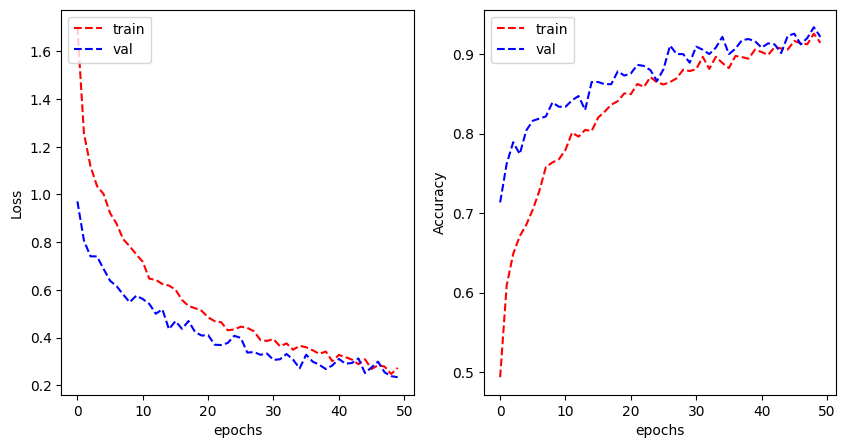

In [53]:
plot_learning_curve(history_type_ann_opt.history['loss'], history_type_ann_opt.history['val_loss'],
                    history_type_ann_opt.history['categorical_accuracy'], history_type_ann_opt.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [54]:
# Get best epoch
val_loss_per_epoch = history_type_ann_opt.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

model_type_ann_opt = tuner_type_ann.hypermodel.build(best_hps)
train_generator_type_aug.reset()
validation_generator_type.reset()
model_type_ann_opt.fit(train_generator_type_aug, validation_data = validation_generator_type, epochs=best_epoch, verbose=2)

Best epoch: 50
Epoch 1/50
93/93 - 1s - loss: 1.6912 - categorical_accuracy: 0.4914 - val_loss: 1.0440 - val_categorical_accuracy: 0.6851 - 789ms/epoch - 8ms/step
Epoch 2/50
93/93 - 1s - loss: 1.1932 - categorical_accuracy: 0.6228 - val_loss: 0.8176 - val_categorical_accuracy: 0.7419 - 613ms/epoch - 7ms/step
Epoch 3/50
93/93 - 1s - loss: 1.0976 - categorical_accuracy: 0.6543 - val_loss: 0.7640 - val_categorical_accuracy: 0.7649 - 622ms/epoch - 7ms/step
Epoch 4/50
93/93 - 1s - loss: 1.0291 - categorical_accuracy: 0.6786 - val_loss: 0.7740 - val_categorical_accuracy: 0.7446 - 619ms/epoch - 7ms/step
Epoch 5/50
93/93 - 1s - loss: 0.9696 - categorical_accuracy: 0.6985 - val_loss: 0.6797 - val_categorical_accuracy: 0.7959 - 614ms/epoch - 7ms/step
Epoch 6/50
93/93 - 1s - loss: 0.9603 - categorical_accuracy: 0.7060 - val_loss: 0.6639 - val_categorical_accuracy: 0.7946 - 615ms/epoch - 7ms/step
Epoch 7/50
93/93 - 1s - loss: 0.8436 - categorical_accuracy: 0.7432 - val_loss: 0.6059 - val_categorica

In [55]:
# save or load the model 
# model_type_ann_opt.save("model_type_ann_opt_filter.h5")
model_type_ann_opt = tf.keras.models.load_model("models/model_type_ann_opt_filter.h5")

In [56]:
# for validation set
validation_generator_type.reset()
validation_type_ann_opt_predictions = model_type_ann_opt.predict(validation_generator_type)
validation_type_ann_opt_predicted_classes = np.argmax(validation_type_ann_opt_predictions, axis=1)

# print classification report
print(classification_report(validation_type_true_classes, validation_type_ann_opt_predicted_classes, target_names=validation_generator_type.class_indices.keys()))

24/24 [==============================] - 0s 3ms/step
                  precision    recall  f1-score   support

         bicycle       1.00      0.96      0.98        55
        continue       1.00      1.00      1.00        47
        crossing       1.00      1.00      1.00        17
         giveway       1.00      1.00      1.00        54
         laneend       1.00      1.00      1.00        25
  limitedtraffic       1.00      1.00      1.00        25
         noentry       0.98      0.98      0.98        60
       noparking       0.96      0.98      0.97        55
         parking       1.00      1.00      1.00        44
      rightofway       0.96      0.98      0.97        55
      roundabout       0.93      0.82      0.87        17
           speed       0.99      0.99      0.99        68
            stop       1.00      1.00      1.00         9
trafficdirective       0.98      0.95      0.96        43
 traveldirection       0.88      1.00      0.94        22
         warning  

## Advanced Model - CNN

### CNN - Shape

The architecture of the following model is defined using Keras' `Sequential` model, which allows us to stack layers in a linear stack.

1. **Input Layer:**
   - `Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))`
   - This is the first layer in your model.
   - It is a 2D Convolutional layer with 32 filters, each of size 3x3.
   - The activation function used is 'ReLU' (Rectified Linear Unit), which introduces non-linearity to the model, allowing it to learn more complex patterns.
   - The `input_shape=(28, 28, 1)` specifies that each input image has a dimension of 28x28 pixels with 1 color channel (grayscale).

2. **Pooling Layer:**
   - `MaxPooling2D((2, 2))`
   - This layer performs max pooling with a 2x2 window, reducing the spatial dimensions (height and width) of the output from the previous layer by half.
   - This operation helps reduce the number of parameters and computation in the network, and also controls overfitting by providing an abstracted form of the representation.

3. **Dropout Layer:**
   - `Dropout(0.25)`
   - This layer randomly sets a fraction (25% in this case) of the input units to 0 at each update during training, which helps prevent overfitting.

4. **Second Convolutional Layer:**
   - `Conv2D(64, (3, 3), activation='relu')`
   - This layer increases the depth of the model with 64 filters, allowing the network to learn more complex features.
   - It continues to use 'ReLU' for non-linearity.

5. **Second Pooling Layer:**
   - Followed by another max pooling layer (`MaxPooling2D((2, 2))`) to further reduce dimensionality and to continue the pattern of convolution followed by pooling, which is typical in CNN architectures.

6. **Second Dropout Layer:**
   - `Dropout(0.25)`
   - Again, this layer adds dropout to further combat overfitting, particularly important as the model complexity increases with more layers.

7. **Flattening Layer:**
   - `Flatten()`
   - This layer flattens the 3D output of the previous layer into 1D, making it possible to connect to the dense layers that follow.

8. **Dense Layer:**
   - `Dense(128, activation='relu')`
   - A fully connected layer with 128 units that processes features extracted from the convolutional and pooling layers.
   - Uses 'ReLU' activation.

9. **Third Dropout Layer:**
   - `Dropout(0.5)`
   - Increases the dropout rate to 50%, providing a more aggressive strategy to prevent overfitting as the model processes the full connection of features.

10. **Output Layer:**
    - `Dense(5, activation='softmax')`
    - This is the final layer of the model.
    - It has 5 units, corresponding to the 5 different sign shapes you are classifying.
    - Uses the 'softmax' activation function which is suitable for multi-class classification, as it outputs probabilities of each class.

This architecture is well-suited for a dataset like ours with a moderate number of training examples and a need to learn from small (28x28 pixel) images.

In [57]:
model_shape_cnn_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model_shape_cnn_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

The model compilation step in Keras configures the model for training. Here’s what each component in the `compile` method represents:

1. **Optimizer:**
   - `optimizer='adam'`
   - The optimizer is responsible for updating the weights of the neurons during training. Adam is a popular choice due to its effectiveness in handling sparse gradients on noisy problems. It combines the advantages of two other extensions of stochastic gradient descent: Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSprop). Adam automatically adjusts the learning rate during training, making it efficient in terms of memory requirement and computational time.

2. **Loss Function:**
   - `loss='categorical_crossentropy'`
   - This specifies the loss function that the model will minimize during training. For multi-class classification problems, 'categorical_crossentropy' is commonly used. This loss function is suitable when the labels are one-hot encoded (i.e., each label is a vector with a 1 in the position of the class label and 0 in all other positions). It measures the disparity between the predicted probabilities (assigned by the 'softmax' activation function in the output layer) and the actual distribution of the labels.

3. **Metrics:**
   - `metrics=['categorical_accuracy']`
   - Metrics are used to monitor the training and testing steps. Unlike the loss function, which is used for training, metrics are used to judge the performance of your model. 'Accuracy' is a common metric for classification problems, indicating the percentage of correctly predicted instances among the total instances evaluated. For a balanced dataset, where each class has approximately the same number of instances, accuracy provides a clear measure of performance.

The `compile` method prepares your model for training, setting up the internal structures needed to optimize your model, calculate the loss, and evaluate the specified metrics during training and validation.

By configuring these parameters, you can ensure that the model is optimized effectively during training, using 'adam' for efficient adjustment of weights, minimizing 'categorical_crossentropy' to push the model towards correct class predictions, and tracking 'accuracy' to observe performance improvements across epochs.

In [58]:
train_generator_shape_aug.reset()
validation_generator_shape.reset()

history_shape_cnn_1 = model_shape_cnn_1.fit(
    train_generator_shape_aug, 
    epochs=50, 
    batch_size=32, 
    validation_data=validation_generator_shape
    )

Epoch 1/50
93/93 [==============================] - 1s 8ms/step - loss: 1.0357 - categorical_accuracy: 0.6124 - val_loss: 0.4766 - val_categorical_accuracy: 0.8716
Epoch 2/50
93/93 [==============================] - 1s 8ms/step - loss: 0.5822 - categorical_accuracy: 0.7952 - val_loss: 0.2166 - val_categorical_accuracy: 0.9486
Epoch 3/50
93/93 [==============================] - 1s 8ms/step - loss: 0.3793 - categorical_accuracy: 0.8780 - val_loss: 0.1346 - val_categorical_accuracy: 0.9676
Epoch 4/50
93/93 [==============================] - 1s 8ms/step - loss: 0.2766 - categorical_accuracy: 0.9104 - val_loss: 0.0756 - val_categorical_accuracy: 0.9811
Epoch 5/50
93/93 [==============================] - 1s 8ms/step - loss: 0.2200 - categorical_accuracy: 0.9294 - val_loss: 0.0511 - val_categorical_accuracy: 0.9838
Epoch 6/50
93/93 [==============================] - 1s 8ms/step - loss: 0.1897 - categorical_accuracy: 0.9425 - val_loss: 0.0428 - val_categorical_accuracy: 0.9824
Epoch 7/50
93/93

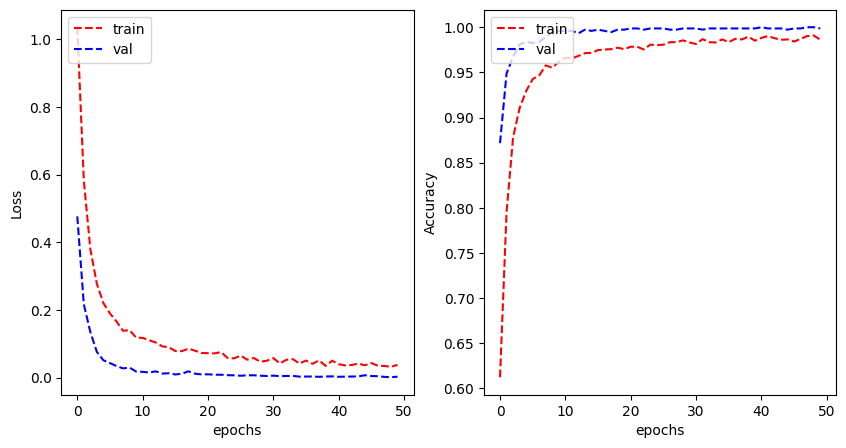

In [59]:
plot_learning_curve(history_shape_cnn_1.history['loss'], history_shape_cnn_1.history['val_loss'],
                    history_shape_cnn_1.history['categorical_accuracy'], history_shape_cnn_1.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [60]:
# Set early stopping if no improvements within 5 epochs
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Re-run with early stopping
train_generator_shape_aug.reset()
validation_generator_shape.reset()
model_shape_cnn_1.fit(train_generator_shape_aug, validation_data = validation_generator_shape, epochs=50, callbacks=[stop_early], verbose=2)
print("Early stopping at Epoch #{}".format(stop_early.stopped_epoch))

Epoch 1/50
93/93 - 1s - loss: 0.0443 - categorical_accuracy: 0.9885 - val_loss: 0.0043 - val_categorical_accuracy: 0.9986 - 750ms/epoch - 8ms/step
Epoch 2/50
93/93 - 1s - loss: 0.0364 - categorical_accuracy: 0.9872 - val_loss: 0.0017 - val_categorical_accuracy: 0.9986 - 722ms/epoch - 8ms/step
Epoch 3/50
93/93 - 1s - loss: 0.0254 - categorical_accuracy: 0.9926 - val_loss: 9.2833e-04 - val_categorical_accuracy: 1.0000 - 737ms/epoch - 8ms/step
Epoch 4/50
93/93 - 1s - loss: 0.0330 - categorical_accuracy: 0.9902 - val_loss: 0.0016 - val_categorical_accuracy: 1.0000 - 725ms/epoch - 8ms/step
Epoch 5/50
93/93 - 1s - loss: 0.0326 - categorical_accuracy: 0.9909 - val_loss: 0.0067 - val_categorical_accuracy: 0.9986 - 732ms/epoch - 8ms/step
Epoch 6/50
93/93 - 1s - loss: 0.0346 - categorical_accuracy: 0.9902 - val_loss: 0.0032 - val_categorical_accuracy: 0.9973 - 735ms/epoch - 8ms/step
Epoch 7/50
93/93 - 1s - loss: 0.0313 - categorical_accuracy: 0.9905 - val_loss: 0.0033 - val_categorical_accuracy:

In [61]:
# save or load the model 
# model_shape_cnn_1.save("model_shape_cnn_1_filter.h5")
model_shape_cnn_1 = tf.keras.models.load_model("models/model_shape_cnn_1_filter.h5")

In [62]:
# validation set
validation_generator_shape.reset()
validation_shape_cnn_1_predictions = model_shape_cnn_1.predict(validation_generator_shape)
validation_shape_cnn_1_predicted_classes = np.argmax(validation_shape_cnn_1_predictions, axis=1)

# print classification report
print(classification_report(validation_shape_true_classes, validation_shape_cnn_1_predicted_classes, target_names=validation_generator_shape.class_indices.keys()))

24/24 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

     diamond       1.00      1.00      1.00        55
         hex       1.00      1.00      1.00         9
       round       1.00      1.00      1.00       345
      square       1.00      1.00      1.00       133
    triangle       1.00      1.00      1.00       198

    accuracy                           1.00       740
   macro avg       1.00      1.00      1.00       740
weighted avg       1.00      1.00      1.00       740



#### Critical Analysis of Model Training Graphs

##### Graph Overview
The provided graphs display the training and validation loss and accuracy over 50 epochs. These metrics are crucial for evaluating the performance and generalization ability of the model.

##### Loss Analysis (Left Panel)
- **Observations:**
  - Both training and validation loss decrease sharply in the initial epochs and then gradually plateau.
  - The validation loss closely mirrors the training loss throughout the training process, showing a very slight upward trend towards the later epochs but not significantly so.

- **Interpretations:**
  - The rapid decrease in loss at the beginning indicates that the model is effectively learning from the training data.
  - The close tracking of validation loss with training loss suggests that the model is not just memorizing the training data but generalizing well to new, unseen data.

##### Accuracy Analysis (Right Panel)
- **Observations:**
  - Similar to loss, both training and validation accuracies improve quickly initially and reach a plateau.
  - The gap between training and validation accuracy is minimal, indicating consistent performance across both datasets.

- **Interpretations:**
  - High and converging accuracies for both training and validation suggest that the model is reliable and stable, effectively generalizing beyond the training data.
  - The plateauing of accuracy indicates that the model might have reached its learning capacity under the current configuration.

##### Conclusion and Recommendations
- **Model Performance:**
  - The model exhibits good generalization as indicated by similar trends and closeness of the training and validation metrics. There is no significant sign of overfitting, which is positive for the robustness of the model.

- **Overall:**
  - The model is well-tuned for the current dataset. However, we will test in on the real world dataset to cross check if the model is overfitting or not. 

This analysis suggests a well-performing model with a robust training strategy.


### CNN - Shape (Optimised)

#### Hyperparameter Tuning
For CNN models, the following hyperparameters are tuned:
    - Conv2D layers
        - `filter`: Number of filters in the convolution
        - `kernel_size`: Size of the convolution window
        - `kernel_regularizer`: L2 regulariser penalty for the convolution kernel
    - Dropout layers
        - Rate of dropout
    - Dense layers (except final output layer)
        - `units`: Dimension of the output space
        - `kernel_regularizer`: L2 regulariser penalty applied to the kernel weights matrix


In [63]:
def build_model_shape_cnn_opt(hp):
    model = Sequential([
        Conv2D(
            filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('conv1_kernel_size', values=[3, 5]),
            activation='relu',
            kernel_regularizer=l2(hp.Float('conv1_l2', min_value=1e-5, max_value=1e-2, sampling='LOG')),
            input_shape=(28, 28, 1)
        ),
        MaxPooling2D(2, 2),
        Dropout(hp.Float('conv1_dropout', min_value=0.2, max_value=0.5, step=0.1)),
        Conv2D(
            filters=hp.Int('conv2_filters', min_value=64, max_value=128, step=32),
            kernel_size=hp.Choice('conv2_kernel_size', values=[3, 5]),
            activation='relu',
            kernel_regularizer=l2(hp.Float('conv2_l2', min_value=1e-5, max_value=1e-2, sampling='LOG'))
        ),
        MaxPooling2D(2, 2),
        Dropout(hp.Float('conv2_dropout', min_value=0.2, max_value=0.5, step=0.1)),
        Flatten(),
        Dense(
            units=hp.Int('dense_units', min_value=128, max_value=512, step=64),
            activation='relu',
            kernel_regularizer=l2(hp.Float('dense_l2', min_value=1e-5, max_value=1e-2, sampling='LOG'))
        ),
        Dropout(hp.Float('dense_dropout', min_value=0.2, max_value=0.7, step=0.1)),
        Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

In [64]:
# Set early stopping if no improvements within 5 epochs
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

tuner_shape_cnn=kt.BayesianOptimization(
    build_model_shape_cnn_opt,
    objective='val_categorical_accuracy',
    max_trials=10,
    directory='tuner',
    seed=42,
    project_name='sign_shape_cnn_filter')

# Start the search process
train_generator_shape_aug.reset()
validation_generator_shape.reset()
tuner_shape_cnn.search(
    train_generator_shape_aug,
    epochs=20,
    validation_data=validation_generator_shape,
    verbose=2,
    callbacks=[stop_early]
)

Reloading Tuner from tuner/sign_shape_cnn_filter/tuner0.json


In [65]:
best_hps = tuner_shape_cnn.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

Best hyperparameters: {'conv1_filters': 32, 'conv1_kernel_size': 3, 'conv1_l2': 0.00018328792004345589, 'conv1_dropout': 0.4, 'conv2_filters': 96, 'conv2_kernel_size': 5, 'conv2_l2': 0.0001293549136453612, 'conv2_dropout': 0.2, 'dense_units': 256, 'dense_l2': 0.00016290492896775622, 'dense_dropout': 0.2, 'learning_rate': 0.001453129317743269}


In [66]:
# Build and train optimised model
model_shape_cnn_opt = tuner_shape_cnn.hypermodel.build(best_hps)
train_generator_shape_aug.reset()
validation_generator_shape.reset()
history_shape_cnn_opt = model_shape_cnn_opt.fit(train_generator_shape_aug, validation_data = validation_generator_shape, epochs=30, verbose=2)

Epoch 1/30
93/93 - 1s - loss: 0.8977 - categorical_accuracy: 0.6854 - val_loss: 0.3916 - val_categorical_accuracy: 0.8824 - 1s/epoch - 12ms/step
Epoch 2/30
93/93 - 1s - loss: 0.4881 - categorical_accuracy: 0.8533 - val_loss: 0.1775 - val_categorical_accuracy: 0.9649 - 895ms/epoch - 10ms/step
Epoch 3/30
93/93 - 1s - loss: 0.2987 - categorical_accuracy: 0.9246 - val_loss: 0.1255 - val_categorical_accuracy: 0.9743 - 885ms/epoch - 10ms/step
Epoch 4/30
93/93 - 1s - loss: 0.2374 - categorical_accuracy: 0.9415 - val_loss: 0.1061 - val_categorical_accuracy: 0.9878 - 911ms/epoch - 10ms/step
Epoch 5/30
93/93 - 1s - loss: 0.1842 - categorical_accuracy: 0.9598 - val_loss: 0.0834 - val_categorical_accuracy: 0.9959 - 910ms/epoch - 10ms/step
Epoch 6/30
93/93 - 1s - loss: 0.1799 - categorical_accuracy: 0.9635 - val_loss: 0.0845 - val_categorical_accuracy: 0.9932 - 932ms/epoch - 10ms/step
Epoch 7/30
93/93 - 1s - loss: 0.1649 - categorical_accuracy: 0.9665 - val_loss: 0.0829 - val_categorical_accuracy: 

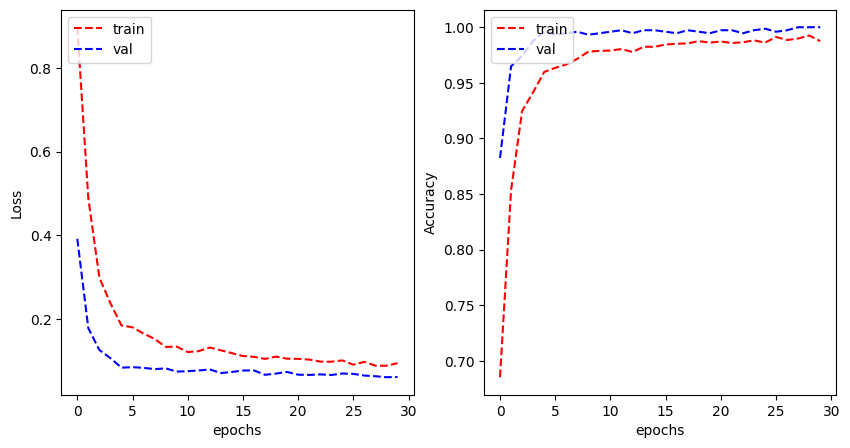

In [67]:
plot_learning_curve(history_shape_cnn_opt.history['loss'], history_shape_cnn_opt.history['val_loss'],
                    history_shape_cnn_opt.history['categorical_accuracy'], history_shape_cnn_opt.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [68]:
# Get best epoch
val_loss_per_epoch = history_shape_cnn_opt.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

model_shape_cnn_opt = tuner_shape_cnn.hypermodel.build(best_hps)
train_generator_shape_aug.reset()
validation_generator_shape.reset()
model_shape_cnn_opt.fit(train_generator_shape_aug, validation_data = validation_generator_shape, epochs=best_epoch, verbose=2)

# save or load the model 
model_shape_cnn_opt.save("model_shape_cnn_opt_filter.h5")
# model_shape_cnn_opt = tf.keras.models.load_model("models/model_shape_cnn_opt_filter.h5")

Best epoch: 29
Epoch 1/29
93/93 - 1s - loss: 0.8906 - categorical_accuracy: 0.6894 - val_loss: 0.3205 - val_categorical_accuracy: 0.9257 - 1s/epoch - 12ms/step
Epoch 2/29
93/93 - 1s - loss: 0.4192 - categorical_accuracy: 0.8763 - val_loss: 0.1629 - val_categorical_accuracy: 0.9689 - 904ms/epoch - 10ms/step
Epoch 3/29
93/93 - 1s - loss: 0.2723 - categorical_accuracy: 0.9294 - val_loss: 0.1273 - val_categorical_accuracy: 0.9770 - 917ms/epoch - 10ms/step
Epoch 4/29
93/93 - 1s - loss: 0.2071 - categorical_accuracy: 0.9513 - val_loss: 0.0946 - val_categorical_accuracy: 0.9865 - 901ms/epoch - 10ms/step
Epoch 5/29
93/93 - 1s - loss: 0.1766 - categorical_accuracy: 0.9605 - val_loss: 0.0827 - val_categorical_accuracy: 0.9946 - 924ms/epoch - 10ms/step
Epoch 6/29
93/93 - 1s - loss: 0.1751 - categorical_accuracy: 0.9642 - val_loss: 0.0921 - val_categorical_accuracy: 0.9892 - 926ms/epoch - 10ms/step
Epoch 7/29
93/93 - 1s - loss: 0.1489 - categorical_accuracy: 0.9713 - val_loss: 0.0848 - val_categor

In [69]:
# validation set
validation_generator_shape.reset()
validation_shape_cnn_opt_predictions = model_shape_cnn_opt.predict(validation_generator_shape)
validation_shape_cnn_opt_predicted_classes = np.argmax(validation_shape_cnn_opt_predictions, axis=1)

# print classification report
print(classification_report(validation_shape_true_classes, validation_shape_cnn_opt_predicted_classes, target_names=validation_generator_shape.class_indices.keys()))

24/24 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

     diamond       1.00      0.98      0.99        55
         hex       1.00      1.00      1.00         9
       round       1.00      1.00      1.00       345
      square       1.00      1.00      1.00       133
    triangle       1.00      1.00      1.00       198

    accuracy                           1.00       740
   macro avg       1.00      1.00      1.00       740
weighted avg       1.00      1.00      1.00       740



### CNN - Type (Transfer Learning)

In [70]:
# create a copy of model_shape_cnn_1
model_shape_cnn_1_cp = model_shape_cnn_1

for layer in model_shape_cnn_1_cp.layers:
    layer.trainable = False

# Replace the top part of the model for sign type classification
x = model_shape_cnn_1_cp.layers[-2].output  # Assuming you want to connect right after the last dropout before the output
x = Dense(128, activation='relu')(x)  # New dense layer, if needed more can be added
x = Dropout(0.5)(x)  # New dropout layer to handle overfitting in the new task
new_output = Dense(16, activation='softmax')(x)  # New output layer for sign types

# Create the new model
model_type_cnn_tl = tf.keras.models.Model(inputs=model_shape_cnn_1_cp.input, outputs=new_output)

model_type_cnn_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [71]:
train_generator_type_aug.reset()
validation_generator_type.reset()
model_type_cnn_tl.fit(train_generator_type_aug, epochs=50, validation_data=validation_generator_type, verbose=2)

Epoch 1/50
93/93 - 1s - loss: 2.3453 - categorical_accuracy: 0.3501 - val_loss: 1.0696 - val_categorical_accuracy: 0.6041 - 933ms/epoch - 10ms/step
Epoch 2/50
93/93 - 1s - loss: 1.4859 - categorical_accuracy: 0.5302 - val_loss: 0.8518 - val_categorical_accuracy: 0.6595 - 671ms/epoch - 7ms/step
Epoch 3/50
93/93 - 1s - loss: 1.2699 - categorical_accuracy: 0.5718 - val_loss: 0.7606 - val_categorical_accuracy: 0.6878 - 673ms/epoch - 7ms/step
Epoch 4/50
93/93 - 1s - loss: 1.1753 - categorical_accuracy: 0.5965 - val_loss: 0.6798 - val_categorical_accuracy: 0.7568 - 671ms/epoch - 7ms/step
Epoch 5/50
93/93 - 1s - loss: 1.0926 - categorical_accuracy: 0.6083 - val_loss: 0.6298 - val_categorical_accuracy: 0.8014 - 676ms/epoch - 7ms/step
Epoch 6/50
93/93 - 1s - loss: 1.0365 - categorical_accuracy: 0.6316 - val_loss: 0.6215 - val_categorical_accuracy: 0.7568 - 678ms/epoch - 7ms/step
Epoch 7/50
93/93 - 1s - loss: 1.0051 - categorical_accuracy: 0.6387 - val_loss: 0.5910 - val_categorical_accuracy: 0.

In [72]:
# Unfreeze some of the top layers of the base model
for layer in model_shape_cnn_1_cp.layers[-3:]:
    layer.trainable = True

# Continue training
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True) # Restores model weights from the epoch with the best value of the monitored quantity
train_generator_type_aug.reset()
validation_generator_type.reset()
model_type_cnn_tl.fit(train_generator_type_aug, epochs=50, validation_data=validation_generator_type,callbacks=[stop_early], verbose=2)
print("Early stopping at Epoch #{}".format(stop_early.stopped_epoch))

Epoch 1/50
93/93 - 1s - loss: 0.7543 - categorical_accuracy: 0.7259 - val_loss: 0.4321 - val_categorical_accuracy: 0.8784 - 733ms/epoch - 8ms/step
Epoch 2/50
93/93 - 1s - loss: 0.7561 - categorical_accuracy: 0.7303 - val_loss: 0.4236 - val_categorical_accuracy: 0.8770 - 669ms/epoch - 7ms/step
Epoch 3/50
93/93 - 1s - loss: 0.7587 - categorical_accuracy: 0.7344 - val_loss: 0.4190 - val_categorical_accuracy: 0.8797 - 659ms/epoch - 7ms/step
Epoch 4/50
93/93 - 1s - loss: 0.7511 - categorical_accuracy: 0.7320 - val_loss: 0.4208 - val_categorical_accuracy: 0.8878 - 670ms/epoch - 7ms/step
Epoch 5/50
93/93 - 1s - loss: 0.7689 - categorical_accuracy: 0.7236 - val_loss: 0.4308 - val_categorical_accuracy: 0.8649 - 670ms/epoch - 7ms/step
Epoch 6/50
93/93 - 1s - loss: 0.7656 - categorical_accuracy: 0.7229 - val_loss: 0.4224 - val_categorical_accuracy: 0.8716 - 682ms/epoch - 7ms/step
Epoch 7/50
93/93 - 1s - loss: 0.7289 - categorical_accuracy: 0.7317 - val_loss: 0.4301 - val_categorical_accuracy: 0.8

In [73]:
# save or load the model 
# model_type_cnn_tl.save("model_type_cnn_tl_orig.h5")
model_type_cnn_tl = tf.keras.models.load_model("models/model_type_cnn_tl_filter.h5")

In [74]:
# validation set
validation_generator_shape.reset()
validation_type_cnn_tl_predictions = model_type_cnn_tl.predict(validation_generator_type)
validation_type_cnn_tl_predicted_classes = np.argmax(validation_type_cnn_tl_predictions, axis=1)

# print classification report
print(classification_report(validation_type_true_classes, validation_type_cnn_tl_predicted_classes, target_names=validation_generator_type.class_indices.keys()))

24/24 [==============================] - 0s 4ms/step
                  precision    recall  f1-score   support

         bicycle       0.81      0.85      0.83        55
        continue       0.70      0.94      0.80        47
        crossing       1.00      1.00      1.00        17
         giveway       1.00      1.00      1.00        54
         laneend       1.00      0.20      0.33        25
  limitedtraffic       0.82      0.72      0.77        25
         noentry       1.00      0.98      0.99        60
       noparking       0.75      0.93      0.83        55
         parking       0.92      1.00      0.96        44
      rightofway       1.00      1.00      1.00        55
      roundabout       0.67      0.71      0.69        17
           speed       0.92      1.00      0.96        68
            stop       1.00      1.00      1.00         9
trafficdirective       0.87      0.79      0.83        43
 traveldirection       1.00      0.32      0.48        22
         warning  

<p style="color: red;"> Note: We will compare performance of above model using transfer learning and the model trained from scratch for sign type. The one which will perform better will be used and further optimised. </p>

### CNN - Type (From Scratch)

In [75]:
model_type_cnn_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),  # An additional layer for more complex features
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='softmax')  # Adjusted for the number of sign types
])

model_type_cnn_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [76]:
train_generator_type_aug.reset()
validation_generator_type.reset()
history_type_cnn_1 = model_type_cnn_1.fit(train_generator_type_aug, epochs=30, validation_data=validation_generator_type, verbose=2)

Epoch 1/30
93/93 - 1s - loss: 2.5520 - categorical_accuracy: 0.2051 - val_loss: 2.0497 - val_categorical_accuracy: 0.3635 - 1s/epoch - 12ms/step
Epoch 2/30
93/93 - 1s - loss: 1.8411 - categorical_accuracy: 0.4262 - val_loss: 1.1868 - val_categorical_accuracy: 0.7149 - 848ms/epoch - 9ms/step
Epoch 3/30
93/93 - 1s - loss: 1.2759 - categorical_accuracy: 0.6185 - val_loss: 0.6913 - val_categorical_accuracy: 0.8014 - 855ms/epoch - 9ms/step
Epoch 4/30
93/93 - 1s - loss: 0.9787 - categorical_accuracy: 0.7053 - val_loss: 0.4924 - val_categorical_accuracy: 0.8527 - 873ms/epoch - 9ms/step
Epoch 5/30
93/93 - 1s - loss: 0.7596 - categorical_accuracy: 0.7732 - val_loss: 0.4088 - val_categorical_accuracy: 0.8811 - 824ms/epoch - 9ms/step
Epoch 6/30
93/93 - 1s - loss: 0.6418 - categorical_accuracy: 0.8057 - val_loss: 0.3361 - val_categorical_accuracy: 0.9041 - 847ms/epoch - 9ms/step
Epoch 7/30
93/93 - 1s - loss: 0.5818 - categorical_accuracy: 0.8270 - val_loss: 0.2856 - val_categorical_accuracy: 0.904

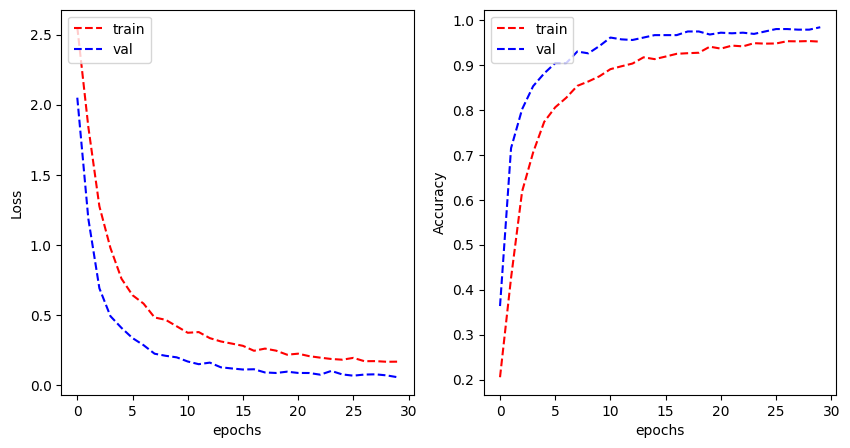

In [77]:
plot_learning_curve(history_type_cnn_1.history['loss'], history_type_cnn_1.history['val_loss'],
                    history_type_cnn_1.history['categorical_accuracy'], history_type_cnn_1.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [78]:
# Set early stopping if no improvements within 5 epochs
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Re-run with early stopping
train_generator_type.reset()
validation_generator_type.reset()
model_type_cnn_1.fit(train_generator_type, validation_data = validation_generator_type, epochs=30, callbacks=[stop_early], verbose=2)
print("Early stopping at Epoch #{}".format(stop_early.stopped_epoch))

Epoch 1/30
93/93 - 1s - loss: 0.1084 - categorical_accuracy: 0.9696 - val_loss: 0.0541 - val_categorical_accuracy: 0.9865 - 882ms/epoch - 9ms/step
Epoch 2/30
93/93 - 1s - loss: 0.0950 - categorical_accuracy: 0.9730 - val_loss: 0.0587 - val_categorical_accuracy: 0.9824 - 870ms/epoch - 9ms/step
Epoch 3/30
93/93 - 1s - loss: 0.0890 - categorical_accuracy: 0.9757 - val_loss: 0.0536 - val_categorical_accuracy: 0.9851 - 816ms/epoch - 9ms/step
Epoch 4/30
93/93 - 1s - loss: 0.0672 - categorical_accuracy: 0.9784 - val_loss: 0.0574 - val_categorical_accuracy: 0.9838 - 815ms/epoch - 9ms/step
Epoch 5/30
93/93 - 1s - loss: 0.0776 - categorical_accuracy: 0.9797 - val_loss: 0.0496 - val_categorical_accuracy: 0.9851 - 813ms/epoch - 9ms/step
Epoch 6/30
93/93 - 1s - loss: 0.0634 - categorical_accuracy: 0.9797 - val_loss: 0.0528 - val_categorical_accuracy: 0.9824 - 804ms/epoch - 9ms/step
Epoch 7/30
93/93 - 1s - loss: 0.0685 - categorical_accuracy: 0.9790 - val_loss: 0.0393 - val_categorical_accuracy: 0.9

In [79]:
# save or load the model 
# model_type_cnn_1.save("model_type_cnn_1_orig.h5")
model_type_cnn_1 = tf.keras.models.load_model("models/model_type_cnn_1_filter.h5")

In [80]:
# validation set
validation_generator_type.reset()
validation_type_cnn_1_predictions = model_type_cnn_1.predict(validation_generator_type)
validation_type_cnn_1_predicted_classes = np.argmax(validation_type_cnn_1_predictions, axis=1)

# print classification report
print(classification_report(validation_type_true_classes, validation_type_cnn_1_predicted_classes, target_names=validation_generator_type.class_indices.keys()))

24/24 [==============================] - 0s 4ms/step
                  precision    recall  f1-score   support

         bicycle       0.96      1.00      0.98        55
        continue       1.00      0.98      0.99        47
        crossing       1.00      1.00      1.00        17
         giveway       1.00      1.00      1.00        54
         laneend       0.96      1.00      0.98        25
  limitedtraffic       1.00      0.92      0.96        25
         noentry       1.00      0.98      0.99        60
       noparking       0.96      0.98      0.97        55
         parking       1.00      1.00      1.00        44
      rightofway       1.00      1.00      1.00        55
      roundabout       1.00      1.00      1.00        17
           speed       1.00      0.99      0.99        68
            stop       0.89      0.89      0.89         9
trafficdirective       0.98      1.00      0.99        43
 traveldirection       1.00      1.00      1.00        22
         warning  

### CNN - Type (Optimised)

<b> Rationale Behind Above Hyperparameter Tuning setup for CNN Model for Sign Type </b>

 **1. Conv2D Layers**
- **Filters**:
  - `filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32)`
  - The number of filters determines how many unique kernels are applied to the input data, effectively deciding how many unique feature types the layer can extract. Testing a range from 32 to 128 allows the model to explore varying levels of feature complexity, which is crucial for understanding which configurations capture the most relevant information in the images.
  
- **Kernel Size**:
  - `kernel_size=hp.Choice('conv1_kernel_size', values=[3, 5])`
  - Kernel size impacts the area of input data that each filter covers. Smaller kernels may capture finer details, while larger kernels can extract broader features. By allowing the tuner to choose between 3x3 and 5x5, the model can adapt to the most effective level of granularity for feature extraction.

- **Activation**:
  - `activation='relu'`
  - ReLU (Rectified Linear Unit) is used for introducing non-linearity into the model without affecting the receptive fields of the convolution layer.

- **Padding**:
  - `padding='same'`
  - Using 'same' padding, even before max pooling layers, ensures that the convolutional layer's output has the same spatial dimensions as the input. This approach maintains feature maps' integrity across the image, including edges, and allows deeper network architectures without early reduction in data dimensions. It is particularly beneficial when the input size is relatively small, as it prevents rapid loss of spatial dimensionality that could limit the network's depth and effectiveness.

 **2. MaxPooling2D**
- Reduces the spatial dimensions (height, width) of the input volume for the next convolution layer. It helps reduce the computational load, memory usage, and number of parameters.

 **3. Dropout**
- `Dropout(hp.Float('conv1_dropout', min_value=0.2, max_value=0.5, step=0.1))`
- Randomly sets a fraction of input units to 0 at each update during training, which helps prevent overfitting. The tuner tests dropout rates between 20% to 50%, allowing you to find the sweet spot between sufficient training complexity and avoiding overfitting.

 **4. Flatten**
- Flattens the input. Does not affect any hyperparameters but is necessary to transition from 2D feature maps to 1D feature vectors for the dense layers.

 **5. Dense Layers**
- **Units**:
  - `units=hp.Int('dense_units', min_value=128, max_value=512, step=64)`
  - Defines the number of neurons in the dense layer, impacting the model's capacity to learn high-level features from the data aggregated in the convolutions. The range provided allows significant flexibility to explore different model complexities.

- **Activation (ReLU)**:
  - Ensures non-linearity in hypothesis, allowing the network to learn complex patterns.

 **6. Final Output Layer**
- **Units**:
  - `Dense(16, activation='softmax')`
  - The final dense layer has 16 units, corresponding to the number of sign types (classes). Softmax activation is used to calculate a probability distribution over the classes.

 **7. Learning Rate**
- `optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG'))`
- The learning rate determines how quickly a network updates its parameters. Lower learning rates slow down the learning process but can provide more stable convergence, while higher rates speed up the learning but can lead to unstable convergence. Log sampling allows exploring orders of magnitude efficiently.

 **Conclusion**
This setup aims to find an optimal balance of model complexity, learning capability, and generalization potential by adjusting architecture parameters and training hyperparameters.

In [81]:
def build_model_type_cnn_opt(hp):
    model = Sequential([
        Conv2D(
            filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('conv1_kernel_size', values=[3, 5]),
            activation='relu',
            padding='same',  # Ensuring output size equals input size
            input_shape=(28, 28, 1)
        ),
        MaxPooling2D(2, 2),
        Dropout(hp.Float('conv1_dropout', min_value=0.2, max_value=0.5, step=0.1)),
        Conv2D(
            filters=hp.Int('conv2_filters', min_value=64, max_value=128, step=32),
            kernel_size=hp.Choice('conv2_kernel_size', values=[3, 5]),
            activation='relu',
            padding='same'  # Ensuring output size equals input size
        ),
        MaxPooling2D(2, 2),
        Dropout(hp.Float('conv2_dropout', min_value=0.2, max_value=0.5, step=0.1)),
        Conv2D(
            filters=hp.Int('conv3_filters', min_value=128, max_value=256, step=64),
            kernel_size=hp.Choice('conv3_kernel_size', values=[3, 5]),
            activation='relu',
            padding='same'  # Ensuring output size equals input size
        ),
        MaxPooling2D(2, 2),
        Dropout(hp.Float('conv3_dropout', min_value=0.2, max_value=0.5, step=0.1)),
        Flatten(),
        Dense(
            units=hp.Int('dense_units', min_value=128, max_value=512, step=64),
            activation='relu'
        ),
        Dropout(hp.Float('dense_dropout', min_value=0.2, max_value=0.7, step=0.1)),
        Dense(16, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

In [82]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

tuner_type_cnn=kt.BayesianOptimization(
    build_model_type_cnn_opt,
    objective='val_categorical_accuracy',
    max_trials=10,
    directory='tuner',
    seed=42,
    project_name='sign_type_cnn_filter')

# Start the search process
train_generator_type_aug.reset()
validation_generator_type.reset()
tuner_type_cnn.search(
    train_generator_type_aug,
    epochs=20,
    validation_data=validation_generator_type,
    verbose=2
)

# Get the best hyperparameters
best_hps = tuner_type_cnn.get_best_hyperparameters()[0]
print(f"Best hyperparameters: {best_hps.values}")

Reloading Tuner from tuner/sign_type_cnn_filter/tuner0.json
Best hyperparameters: {'conv1_filters': 96, 'conv1_kernel_size': 3, 'conv1_dropout': 0.30000000000000004, 'conv2_filters': 64, 'conv2_kernel_size': 5, 'conv2_dropout': 0.30000000000000004, 'conv3_filters': 192, 'conv3_kernel_size': 3, 'conv3_dropout': 0.30000000000000004, 'dense_units': 192, 'dense_dropout': 0.6000000000000001, 'learning_rate': 0.001715074355925934}


In [83]:
# Build and train optimised model
model_type_cnn_opt = tuner_type_cnn.hypermodel.build(best_hps)
train_generator_type_aug.reset()
validation_generator_type.reset()
history_type_cnn_opt = model_type_cnn_opt.fit(train_generator_type_aug, epochs=30, validation_data=validation_generator_type, verbose=2)

Epoch 1/30
93/93 - 3s - loss: 2.2436 - categorical_accuracy: 0.3065 - val_loss: 1.2601 - val_categorical_accuracy: 0.7176 - 3s/epoch - 33ms/step
Epoch 2/30
93/93 - 3s - loss: 1.2341 - categorical_accuracy: 0.6276 - val_loss: 0.5037 - val_categorical_accuracy: 0.8541 - 3s/epoch - 36ms/step
Epoch 3/30
93/93 - 3s - loss: 0.8304 - categorical_accuracy: 0.7445 - val_loss: 0.3506 - val_categorical_accuracy: 0.9054 - 3s/epoch - 30ms/step
Epoch 4/30
93/93 - 3s - loss: 0.5995 - categorical_accuracy: 0.8172 - val_loss: 0.2073 - val_categorical_accuracy: 0.9392 - 3s/epoch - 32ms/step
Epoch 5/30
93/93 - 3s - loss: 0.5048 - categorical_accuracy: 0.8499 - val_loss: 0.1672 - val_categorical_accuracy: 0.9541 - 3s/epoch - 30ms/step
Epoch 6/30
93/93 - 3s - loss: 0.4107 - categorical_accuracy: 0.8783 - val_loss: 0.1235 - val_categorical_accuracy: 0.9662 - 3s/epoch - 29ms/step
Epoch 7/30
93/93 - 3s - loss: 0.3390 - categorical_accuracy: 0.8993 - val_loss: 0.1170 - val_categorical_accuracy: 0.9635 - 3s/epo

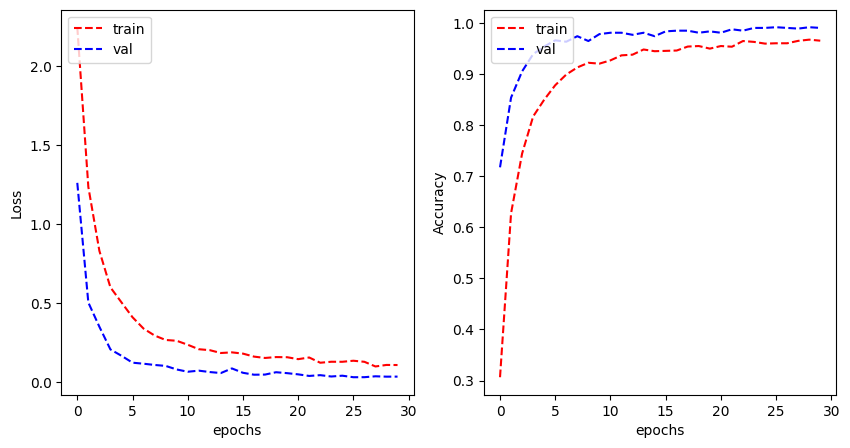

In [84]:
plot_learning_curve(history_type_cnn_opt.history['loss'], history_type_cnn_opt.history['val_loss'],
                    history_type_cnn_opt.history['categorical_accuracy'], history_type_cnn_opt.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [85]:
# Get best epoch
val_loss_per_epoch = history_type_cnn_opt.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

model_type_cnn_opt = tuner_type_cnn.hypermodel.build(best_hps)
train_generator_type_aug.reset()
validation_generator_type.reset()
model_type_cnn_opt.fit(train_generator_type_aug, validation_data = validation_generator_type, epochs=best_epoch, verbose=2)

# save or load the model 
# model_type_cnn_opt.save("model_type_cnn_opt_orig.h5")
model_shape_cnn_1 = tf.keras.models.load_model("models/model_shape_cnn_1_filter.h5")

Best epoch: 26
Epoch 1/26
93/93 - 3s - loss: 2.2560 - categorical_accuracy: 0.3065 - val_loss: 1.2767 - val_categorical_accuracy: 0.6689 - 3s/epoch - 35ms/step
Epoch 2/26
93/93 - 3s - loss: 1.2118 - categorical_accuracy: 0.6276 - val_loss: 0.5110 - val_categorical_accuracy: 0.8716 - 3s/epoch - 37ms/step
Epoch 3/26
93/93 - 3s - loss: 0.8161 - categorical_accuracy: 0.7479 - val_loss: 0.3165 - val_categorical_accuracy: 0.9068 - 3s/epoch - 31ms/step
Epoch 4/26
93/93 - 3s - loss: 0.5773 - categorical_accuracy: 0.8249 - val_loss: 0.2142 - val_categorical_accuracy: 0.9378 - 3s/epoch - 33ms/step
Epoch 5/26
93/93 - 3s - loss: 0.4638 - categorical_accuracy: 0.8577 - val_loss: 0.2044 - val_categorical_accuracy: 0.9365 - 3s/epoch - 32ms/step
Epoch 6/26
93/93 - 3s - loss: 0.3866 - categorical_accuracy: 0.8864 - val_loss: 0.1275 - val_categorical_accuracy: 0.9703 - 3s/epoch - 31ms/step
Epoch 7/26
93/93 - 3s - loss: 0.3304 - categorical_accuracy: 0.9000 - val_loss: 0.0831 - val_categorical_accuracy: 

In [86]:
# validation set
validation_generator_type.reset()
validation_type_cnn_opt_predictions = model_type_cnn_opt.predict(validation_generator_type)
validation_type_cnn_opt_predicted_classes = np.argmax(validation_type_cnn_opt_predictions, axis=1)

# print classification report
print(classification_report(validation_type_true_classes, validation_type_cnn_opt_predicted_classes, target_names=validation_generator_type.class_indices.keys()))

24/24 [==============================] - 0s 11ms/step
                  precision    recall  f1-score   support

         bicycle       0.98      1.00      0.99        55
        continue       1.00      1.00      1.00        47
        crossing       1.00      1.00      1.00        17
         giveway       1.00      1.00      1.00        54
         laneend       1.00      1.00      1.00        25
  limitedtraffic       0.96      0.88      0.92        25
         noentry       0.97      1.00      0.98        60
       noparking       0.96      0.96      0.96        55
         parking       1.00      1.00      1.00        44
      rightofway       0.98      1.00      0.99        55
      roundabout       1.00      0.82      0.90        17
           speed       0.99      1.00      0.99        68
            stop       1.00      0.89      0.94         9
trafficdirective       0.98      1.00      0.99        43
 traveldirection       1.00      1.00      1.00        22
         warning 

## CNN(GoogLeNet)

<p style="color: red;"> Note: We are not using GoogLeNet as our model but only for comparing our model performance </p>

### CNN Shape (GoogLeNet)

We are going with Googlenet to compare it with our model. <br><br>
The reason behind using Googlenet is:
#### **1. Efficient Architecture**:
- **Inception Modules**: GoogleNet introduces inception modules, which apply multiple types of filters (1x1, 3x3, 5x5 convolutions) at each layer. This allows the network to capture complex and varied features from the images, which is crucial for accurately classifying traffic signs that come in various shapes, and symbols. Addtionally, GoogLeNet is able to recognise objects better than other CNN models like ResNet and AlexNet(Neha Sharma, Vibhor Jain, Anju Mishra,
An Analysis Of Convolutional Neural Networks For Image Classification, Procedia Computer Science, Volume 132, 2018, Pages 377-384, ISSN 1877-0509, https://doi.org/10.1016/j.procs.2018.05.198.) 

#### **2. Avoidance of Overfitting**:
- **Auxiliary Classifiers**: GoogleNet incorporates auxiliary classifiers during training, which not only help in combating the vanishing gradient problem but also act as regularizers. These classifiers promote robustness in the model by preventing overfitting, a crucial advantage when training from scratch on a modestly sized dataset like in our case.

#### **3. Adaptability to Varied Visual Features**:
- **Multi-Scale Feature Learning**: The capability of inception modules to learn features at various scales directly aligns with the needs of traffic sign recognition, where signs can vastly differ in visual appearance and size.

#### **4. Generalization Capabilities**:
- **Robust Feature Representation**: GoogleNet has demonstrated strong generalization capabilities in diverse image recognition tasks. Its architecture is well-suited for handling the variability in a dataset of traffic signs, which can appear under different lighting conditions and angles(which will be the situation while we are testing on real world photos as our unseen test set).

### Conclusion
Choosing GoogleNet for the traffic sign classification task offers a well-balanced approach between architectural complexity and computational efficiency. It provides the depth needed for accurate classification while maintaining manageable computational demands, making it an excellent choice for our dataset.

In [87]:
def inception_module(x, filters):
    # 1x1 conv
    conv1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    # 3x3 conv
    conv3 = layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3 = layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3)

    # 5x5 conv
    conv5 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5 = layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5)

    # 3x3 max pooling
    pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu')(pool)

    # concatenate filters
    out = layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
    return out

def create_googlenet(output_classes):
    input_layer = layers.Input(shape=(28, 28, 1))
    
    # Initial Convolution and MaxPooling
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Local response normalization
    x = tf.nn.local_response_normalization(x)
    
    # Second Convolution and MaxPooling
    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Local response normalization
    x = tf.nn.local_response_normalization(x)
    
    # Inception Modules
    x = inception_module(x, [64, 96, 128, 16, 32, 32])  # 3a
    x = inception_module(x, [128, 128, 192, 32, 96, 64]) # 3b
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    x = inception_module(x, [192, 96, 208, 16, 48, 64]) # 4a
    x = inception_module(x, [160, 112, 224, 24, 64, 64]) # 4b
    x = inception_module(x, [128, 128, 256, 24, 64, 64]) # 4c
    x = inception_module(x, [112, 144, 288, 32, 64, 64]) # 4d
    x = inception_module(x, [256, 160, 320, 32, 128, 128]) # 4e
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [256, 160, 320, 32, 128, 128]) # 5a
    x = inception_module(x, [384, 192, 384, 48, 128, 128]) # 5b

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dropout and Classification layer
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(output_classes, activation='softmax')(x)
    
    model = models.Model(input_layer, output)
    return model


In [88]:
# Create the model
model_shape_cnn_googlenet = create_googlenet(5)

# Compile the model
# googlenet.compile(optimizer=optimizers.SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model_shape_cnn_googlenet.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Summary of the model
model_shape_cnn_googlenet.summary()

train_generator_shape_aug.reset()
validation_generator_shape.reset()
history_shape_cnn_googlenet = model_shape_cnn_googlenet.fit(train_generator_shape_aug, epochs=50, validation_data=validation_generator_shape,verbose=2)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 14, 14, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 7, 7, 64)    0           ['conv2d_15[0][0]']              
 )                                                                                                
                                                                                                  
 tf.nn.local_response_normaliza  (None, 7, 7, 64)    0           ['max_pooling2d_15[0][0]'] 

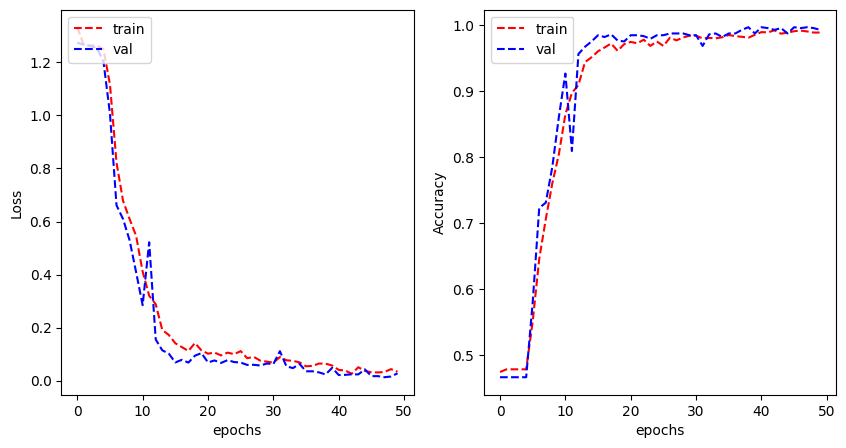

In [89]:
plot_learning_curve(history_shape_cnn_googlenet.history['loss'], history_shape_cnn_googlenet.history['val_loss'],
                    history_shape_cnn_googlenet.history['categorical_accuracy'], history_shape_cnn_googlenet.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [90]:
# Set early stopping if no improvements within 5 epochs
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Re-run with early stopping
train_generator_shape_aug.reset()
validation_generator_shape.reset()
model_shape_cnn_googlenet.fit(train_generator_shape_aug, 
                              validation_data = validation_generator_shape, 
                              epochs=100, 
                              callbacks=[stop_early], 
                              verbose=2)
print("Early stopping at Epoch #{}".format(stop_early.stopped_epoch))

Epoch 1/100
93/93 - 5s - loss: 0.0297 - categorical_accuracy: 0.9919 - val_loss: 0.0108 - val_categorical_accuracy: 0.9973 - 5s/epoch - 51ms/step
Epoch 2/100
93/93 - 5s - loss: 0.0126 - categorical_accuracy: 0.9976 - val_loss: 0.0167 - val_categorical_accuracy: 0.9973 - 5s/epoch - 50ms/step
Epoch 3/100
93/93 - 4s - loss: 0.0303 - categorical_accuracy: 0.9929 - val_loss: 0.0161 - val_categorical_accuracy: 0.9959 - 4s/epoch - 48ms/step
Epoch 4/100
93/93 - 4s - loss: 0.0275 - categorical_accuracy: 0.9916 - val_loss: 0.0213 - val_categorical_accuracy: 0.9946 - 4s/epoch - 48ms/step
Epoch 5/100
93/93 - 5s - loss: 0.0234 - categorical_accuracy: 0.9939 - val_loss: 0.0277 - val_categorical_accuracy: 0.9932 - 5s/epoch - 49ms/step
Epoch 6/100
93/93 - 5s - loss: 0.0303 - categorical_accuracy: 0.9926 - val_loss: 0.0107 - val_categorical_accuracy: 0.9986 - 5s/epoch - 50ms/step
Epoch 7/100
93/93 - 5s - loss: 0.0176 - categorical_accuracy: 0.9936 - val_loss: 0.0053 - val_categorical_accuracy: 0.9986 -

In [91]:
# save or load the model 
# model_shape_cnn_googlenet.save("model_shape_cnn_googlenet_aug.h5")
model_shape_cnn_googlenet = tf.keras.models.load_model("models/model_shape_cnn_googlenet_filter.h5")

In [92]:
# validation set
validation_generator_shape.reset()
validation_shape_cnn_googlenet_predictions = model_shape_cnn_googlenet.predict(validation_generator_shape)
validation_shape_cnn_googlenet_predicted_classes = np.argmax(validation_shape_cnn_googlenet_predictions, axis=1)

# print classification report
print(classification_report(validation_shape_true_classes, validation_shape_cnn_googlenet_predicted_classes, target_names=validation_generator_shape.class_indices.keys()))

24/24 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

     diamond       1.00      0.98      0.99        55
         hex       1.00      0.78      0.88         9
       round       0.98      1.00      0.99       345
      square       0.99      0.99      0.99       133
    triangle       1.00      0.98      0.99       198

    accuracy                           0.99       740
   macro avg       0.99      0.95      0.97       740
weighted avg       0.99      0.99      0.99       740



### CNN Type (GoogLeNet)

In [93]:
# Create the model
model_type_cnn_googlenet = create_googlenet(16)

# Compile the model
# googlenet.compile(optimizer=optimizers.SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model_type_cnn_googlenet.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Summary of the model
model_type_cnn_googlenet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_71 (Conv2D)             (None, 14, 14, 64)   3200        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_28 (MaxPooling2D  (None, 7, 7, 64)    0           ['conv2d_71[0][0]']              
 )                                                                                                
                                                                                                  
 tf.nn.local_response_normaliza  (None, 7, 7, 64)    0           ['max_pooling2d_28[0][0]'] 

In [94]:
# Example of a simple training loop
# Note: Replace 'train_dataset' with your actual training data generator or dataset
train_generator_type_aug.reset()
validation_generator_type.reset()
history_type_cnn_googlenet = model_type_cnn_googlenet.fit(train_generator_type_aug, epochs=50, validation_data=validation_generator_type,verbose=2)


Epoch 1/50
93/93 - 5s - loss: 2.6635 - categorical_accuracy: 0.1778 - val_loss: 2.6026 - val_categorical_accuracy: 0.1946 - 5s/epoch - 56ms/step
Epoch 2/50
93/93 - 4s - loss: 2.5950 - categorical_accuracy: 0.1862 - val_loss: 2.5913 - val_categorical_accuracy: 0.1946 - 4s/epoch - 48ms/step
Epoch 3/50
93/93 - 5s - loss: 2.5878 - categorical_accuracy: 0.1862 - val_loss: 2.5728 - val_categorical_accuracy: 0.1946 - 5s/epoch - 52ms/step
Epoch 4/50
93/93 - 5s - loss: 2.5104 - categorical_accuracy: 0.1960 - val_loss: 2.3067 - val_categorical_accuracy: 0.2608 - 5s/epoch - 49ms/step
Epoch 5/50
93/93 - 5s - loss: 2.2812 - categorical_accuracy: 0.2582 - val_loss: 2.0865 - val_categorical_accuracy: 0.2730 - 5s/epoch - 50ms/step
Epoch 6/50
93/93 - 5s - loss: 2.0849 - categorical_accuracy: 0.3092 - val_loss: 1.8174 - val_categorical_accuracy: 0.3905 - 5s/epoch - 52ms/step
Epoch 7/50
93/93 - 5s - loss: 1.8430 - categorical_accuracy: 0.3775 - val_loss: 1.6027 - val_categorical_accuracy: 0.4649 - 5s/epo

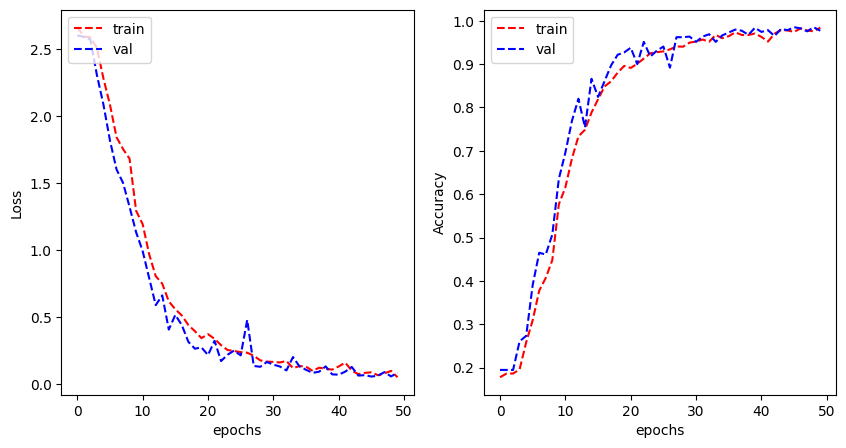

In [95]:
plot_learning_curve(history_type_cnn_googlenet.history['loss'], history_type_cnn_googlenet.history['val_loss'],
                    history_type_cnn_googlenet.history['categorical_accuracy'], history_type_cnn_googlenet.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [96]:
# Set early stopping if no improvements within 5 epochs
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Re-run with early stopping
train_generator_type_aug.reset()
validation_generator_type.reset()
model_type_cnn_googlenet.fit(train_generator_type_aug,
                              validation_data = validation_generator_type,
                              epochs=50,
                              callbacks=[stop_early],
                              verbose=2)
print("Early stopping at Epoch #{}".format(stop_early.stopped_epoch))

Epoch 1/50
93/93 - 5s - loss: 0.0628 - categorical_accuracy: 0.9807 - val_loss: 0.0880 - val_categorical_accuracy: 0.9743 - 5s/epoch - 55ms/step
Epoch 2/50
93/93 - 5s - loss: 0.0795 - categorical_accuracy: 0.9763 - val_loss: 0.0487 - val_categorical_accuracy: 0.9851 - 5s/epoch - 50ms/step
Epoch 3/50
93/93 - 5s - loss: 0.0682 - categorical_accuracy: 0.9824 - val_loss: 0.0797 - val_categorical_accuracy: 0.9784 - 5s/epoch - 49ms/step
Epoch 4/50
93/93 - 5s - loss: 0.0817 - categorical_accuracy: 0.9763 - val_loss: 0.0487 - val_categorical_accuracy: 0.9851 - 5s/epoch - 49ms/step
Epoch 5/50
93/93 - 5s - loss: 0.0649 - categorical_accuracy: 0.9838 - val_loss: 0.0465 - val_categorical_accuracy: 0.9811 - 5s/epoch - 51ms/step
Epoch 6/50
93/93 - 5s - loss: 0.0757 - categorical_accuracy: 0.9797 - val_loss: 0.0496 - val_categorical_accuracy: 0.9838 - 5s/epoch - 50ms/step
Epoch 7/50
93/93 - 5s - loss: 0.0617 - categorical_accuracy: 0.9807 - val_loss: 0.0547 - val_categorical_accuracy: 0.9824 - 5s/epo

In [97]:
# save or load the model 
# model_type_cnn_googlenet.save("model_type_cnn_googlenet_orig.h5")
model_type_cnn_googlenet = tf.keras.models.load_model("models/model_type_cnn_googlenet_filter.h5")

In [98]:
# validation set
validation_generator_type.reset()
validation_type_cnn_googlenet_predictions = model_type_cnn_googlenet.predict(validation_generator_type)
validation_type_cnn_googlenet_predicted_classes = np.argmax(validation_type_cnn_googlenet_predictions, axis=1)

# print classification report
print(classification_report(validation_type_true_classes, validation_type_cnn_googlenet_predicted_classes, target_names=validation_generator_type.class_indices.keys()))

24/24 [==============================] - 0s 12ms/step
                  precision    recall  f1-score   support

         bicycle       0.96      0.93      0.94        55
        continue       1.00      1.00      1.00        47
        crossing       1.00      0.88      0.94        17
         giveway       1.00      1.00      1.00        54
         laneend       1.00      0.88      0.94        25
  limitedtraffic       1.00      0.84      0.91        25
         noentry       1.00      0.97      0.98        60
       noparking       0.92      0.98      0.95        55
         parking       1.00      1.00      1.00        44
      rightofway       0.95      1.00      0.97        55
      roundabout       0.93      0.82      0.87        17
           speed       0.99      0.99      0.99        68
            stop       0.90      1.00      0.95         9
trafficdirective       0.89      0.95      0.92        43
 traveldirection       0.96      1.00      0.98        22
         warning 

# Testing models with Evaluation dataset

## Evaluating shape_ANN_1

493/493 [==============================] - 0s 509us/step
              precision    recall  f1-score   support

     diamond       0.97      0.76      0.85        37
         hex       0.75      0.46      0.57        39
       round       0.85      0.94      0.89       253
      square       0.91      0.90      0.90        88
    triangle       0.92      0.91      0.91        76

    accuracy                           0.87       493
   macro avg       0.88      0.79      0.83       493
weighted avg       0.87      0.87      0.87       493

Found 493 validated image filenames belonging to 5 classes.


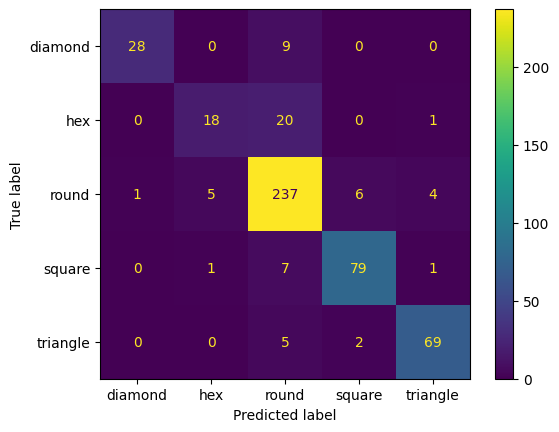

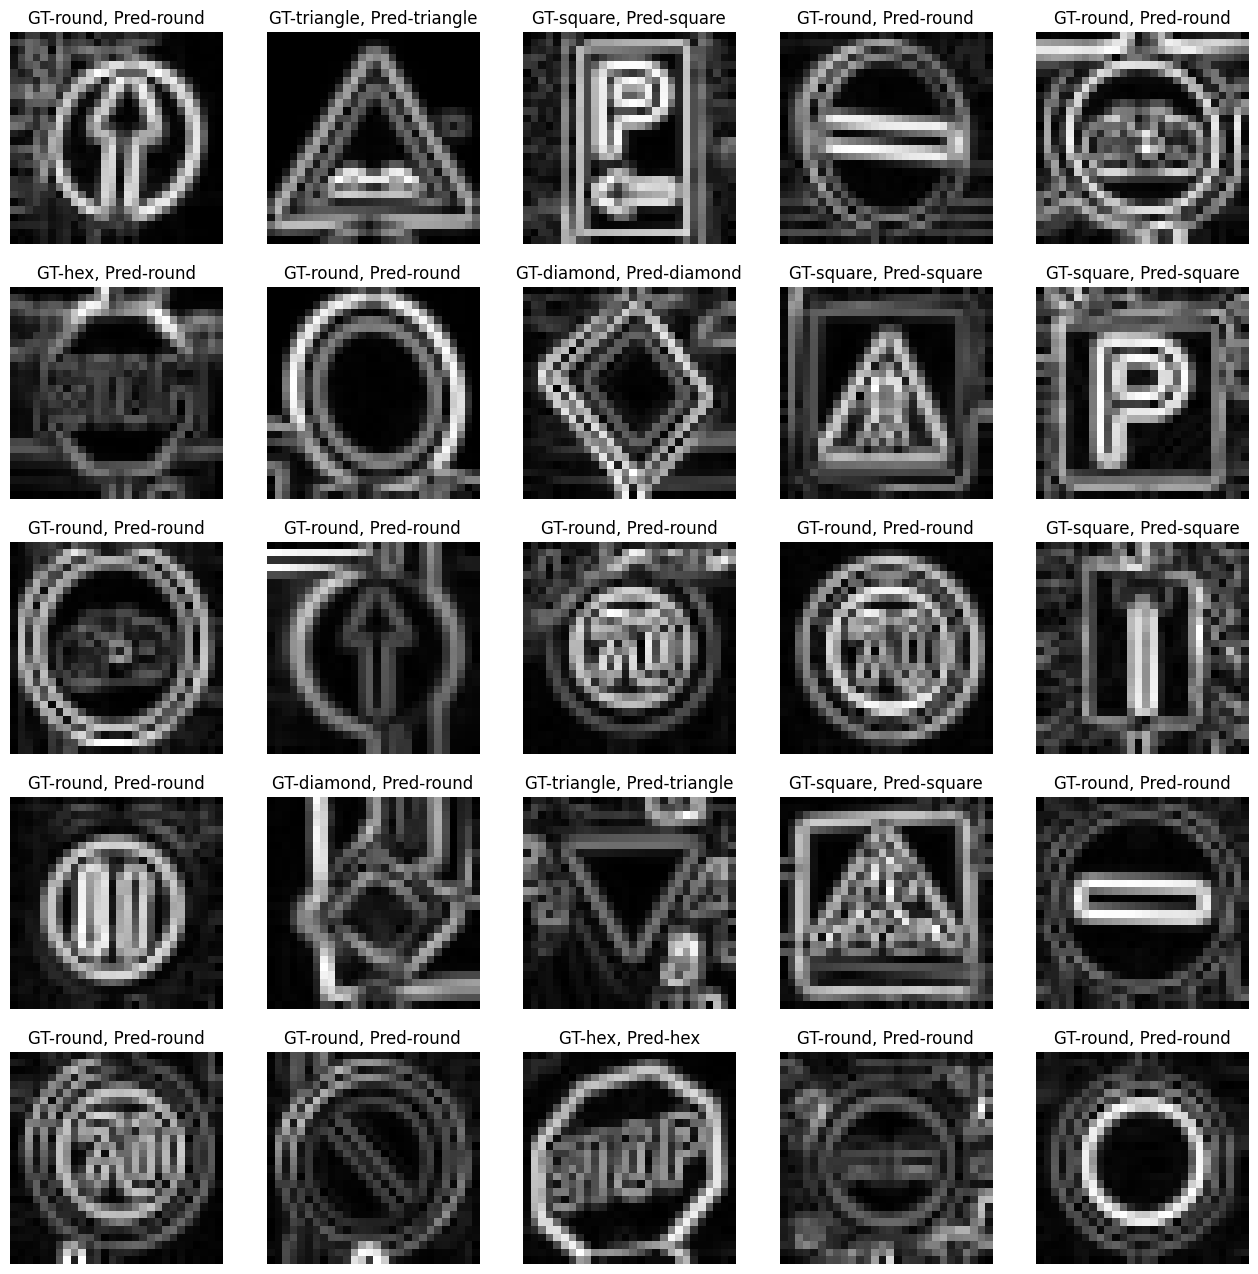

In [99]:
eval_generator_shape.reset()
eval_shape_ann_1_predictions = model_shape_ann_1.predict(eval_generator_shape)
eval_shape_ann_1_predicted_classes = np.argmax(eval_shape_ann_1_predictions, axis=1)

# print classification report
print(classification_report(eval_shape_true_classes, eval_shape_ann_1_predicted_classes, target_names=eval_generator_shape.class_indices.keys()))

# display confusion matrix
eval_shape_ann_1_cm = ConfusionMatrixDisplay.from_predictions(
    eval_shape_true_classes, eval_shape_ann_1_predicted_classes,
    display_labels=eval_generator_shape.class_indices.keys())

# randomly pick images and show prediction
show_image_prediction(model_shape_ann_1, "sign_shape", eval_generator_shape.class_indices, eval_data, preprocessing_func)

## Evaluating shape_ANN_opt

493/493 [==============================] - 0s 519us/step
              precision    recall  f1-score   support

     diamond       0.83      0.78      0.81        37
         hex       1.00      0.31      0.47        39
       round       0.83      0.95      0.89       253
      square       0.93      0.85      0.89        88
    triangle       0.91      0.88      0.89        76

    accuracy                           0.86       493
   macro avg       0.90      0.76      0.79       493
weighted avg       0.87      0.86      0.85       493

Found 740 validated image filenames belonging to 5 classes.


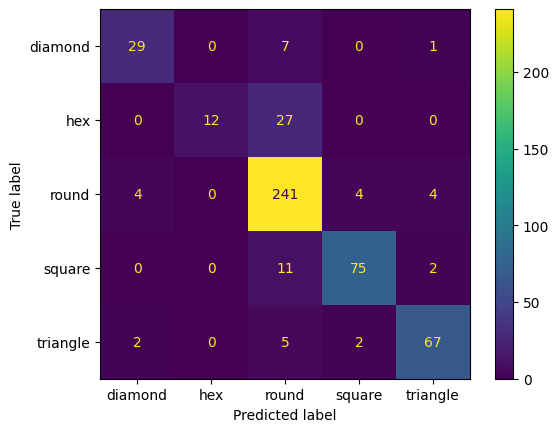

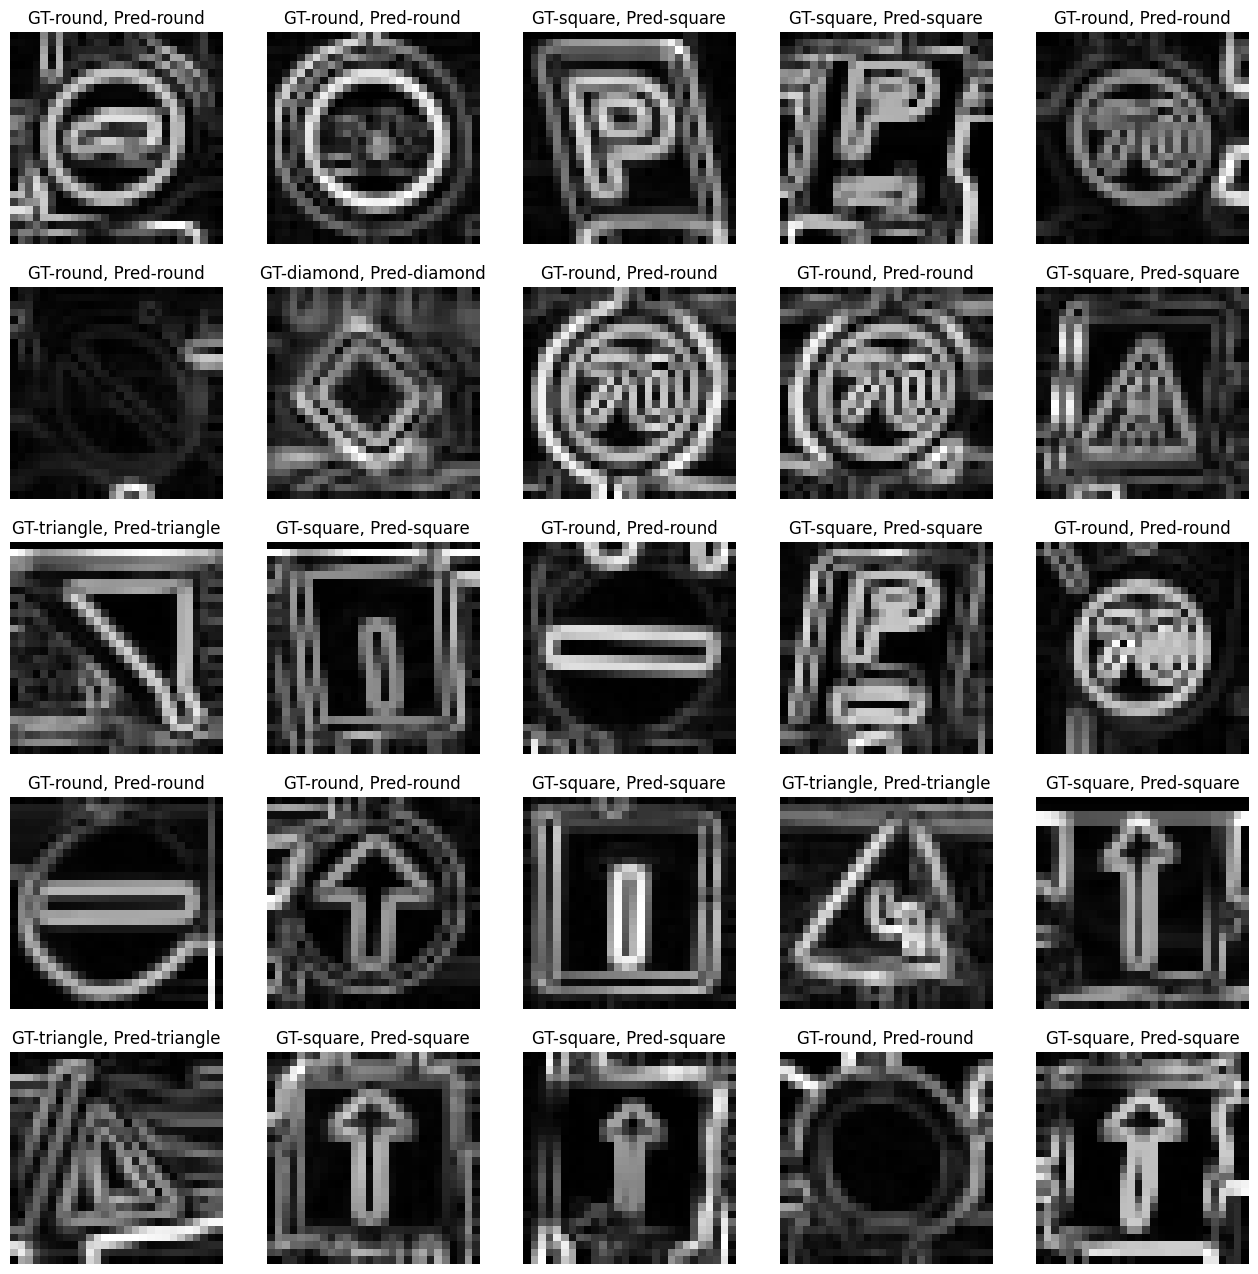

In [100]:
# Evaluate with test set
eval_generator_shape.reset()
eval_shape_ann_opt_predictions = model_shape_ann_opt.predict(eval_generator_shape)
eval_shape_ann_opt_predicted_classes = np.argmax(eval_shape_ann_opt_predictions, axis=1)

# print classification report
print(classification_report(eval_shape_true_classes, eval_shape_ann_opt_predicted_classes, target_names=eval_generator_shape.class_indices.keys()))

# display confusion matrix
eval_shape_ann_opt_cm = ConfusionMatrixDisplay.from_predictions(
    eval_shape_true_classes, eval_shape_ann_opt_predicted_classes,
    display_labels=eval_generator_shape.class_indices.keys())

# randomly pick images and show prediction
show_image_prediction(model_shape_ann_opt, "sign_shape", validation_generator_shape.class_indices, val_data, preprocessing_func)

## Evaluating shape_CNN_1

493/493 [==============================] - 0s 574us/step
              precision    recall  f1-score   support

     diamond       0.97      1.00      0.99        37
         hex       0.88      0.92      0.90        39
       round       0.98      0.98      0.98       253
      square       0.99      0.97      0.98        88
    triangle       0.97      0.99      0.98        76

    accuracy                           0.97       493
   macro avg       0.96      0.97      0.96       493
weighted avg       0.97      0.97      0.97       493

Found 493 validated image filenames belonging to 5 classes.


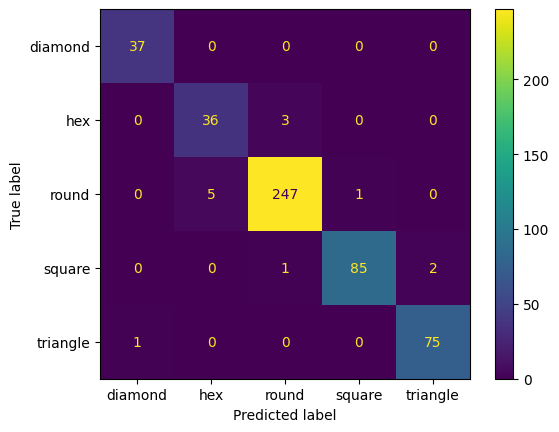

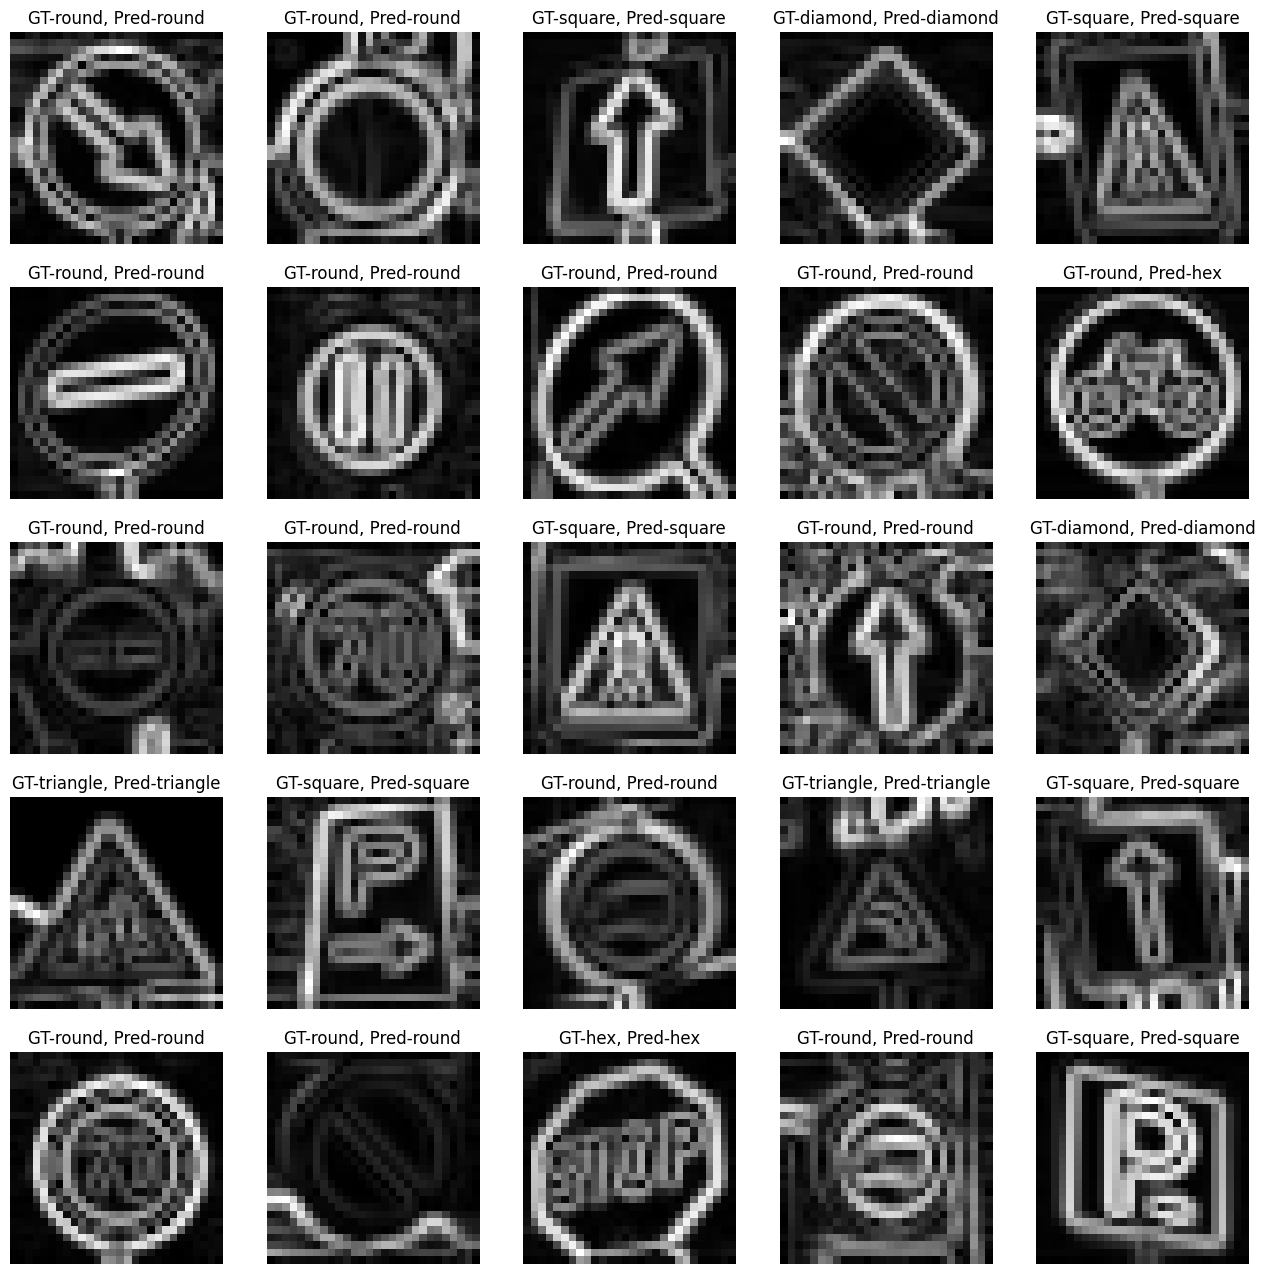

In [101]:
# evaluation set
eval_generator_shape.reset()
eval_shape_cnn_1_predictions = model_shape_cnn_1.predict(eval_generator_shape)
eval_shape_cnn_1_predicted_classes = np.argmax(eval_shape_cnn_1_predictions, axis=1)

# print classification report
print(classification_report(eval_shape_true_classes, eval_shape_cnn_1_predicted_classes, target_names=eval_generator_shape.class_indices.keys()))

# display confusion matrix
eval_shape_cnn_1_cm = ConfusionMatrixDisplay.from_predictions(
    eval_shape_true_classes, eval_shape_cnn_1_predicted_classes,
    display_labels=eval_generator_shape.class_indices.keys())

# randomly pick images and show prediction
show_image_prediction(model_shape_cnn_1, "sign_shape", eval_generator_shape.class_indices, eval_data, preprocessing_func)

## Evaluating shape_CNN_opt

493/493 [==============================] - 0s 623us/step
              precision    recall  f1-score   support

     diamond       1.00      1.00      1.00        37
         hex       0.86      0.97      0.92        39
       round       0.98      0.97      0.98       253
      square       0.99      0.93      0.96        88
    triangle       0.97      1.00      0.99        76

    accuracy                           0.97       493
   macro avg       0.96      0.98      0.97       493
weighted avg       0.97      0.97      0.97       493

Found 493 validated image filenames belonging to 5 classes.


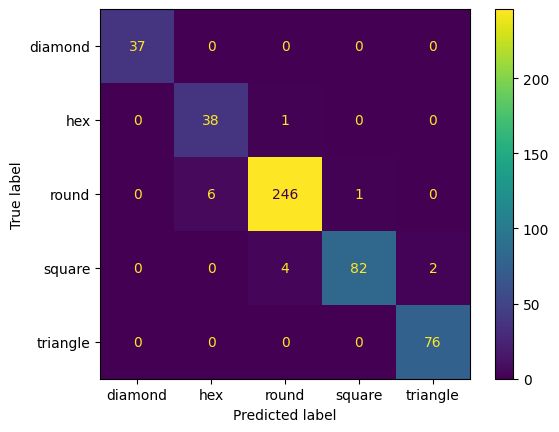

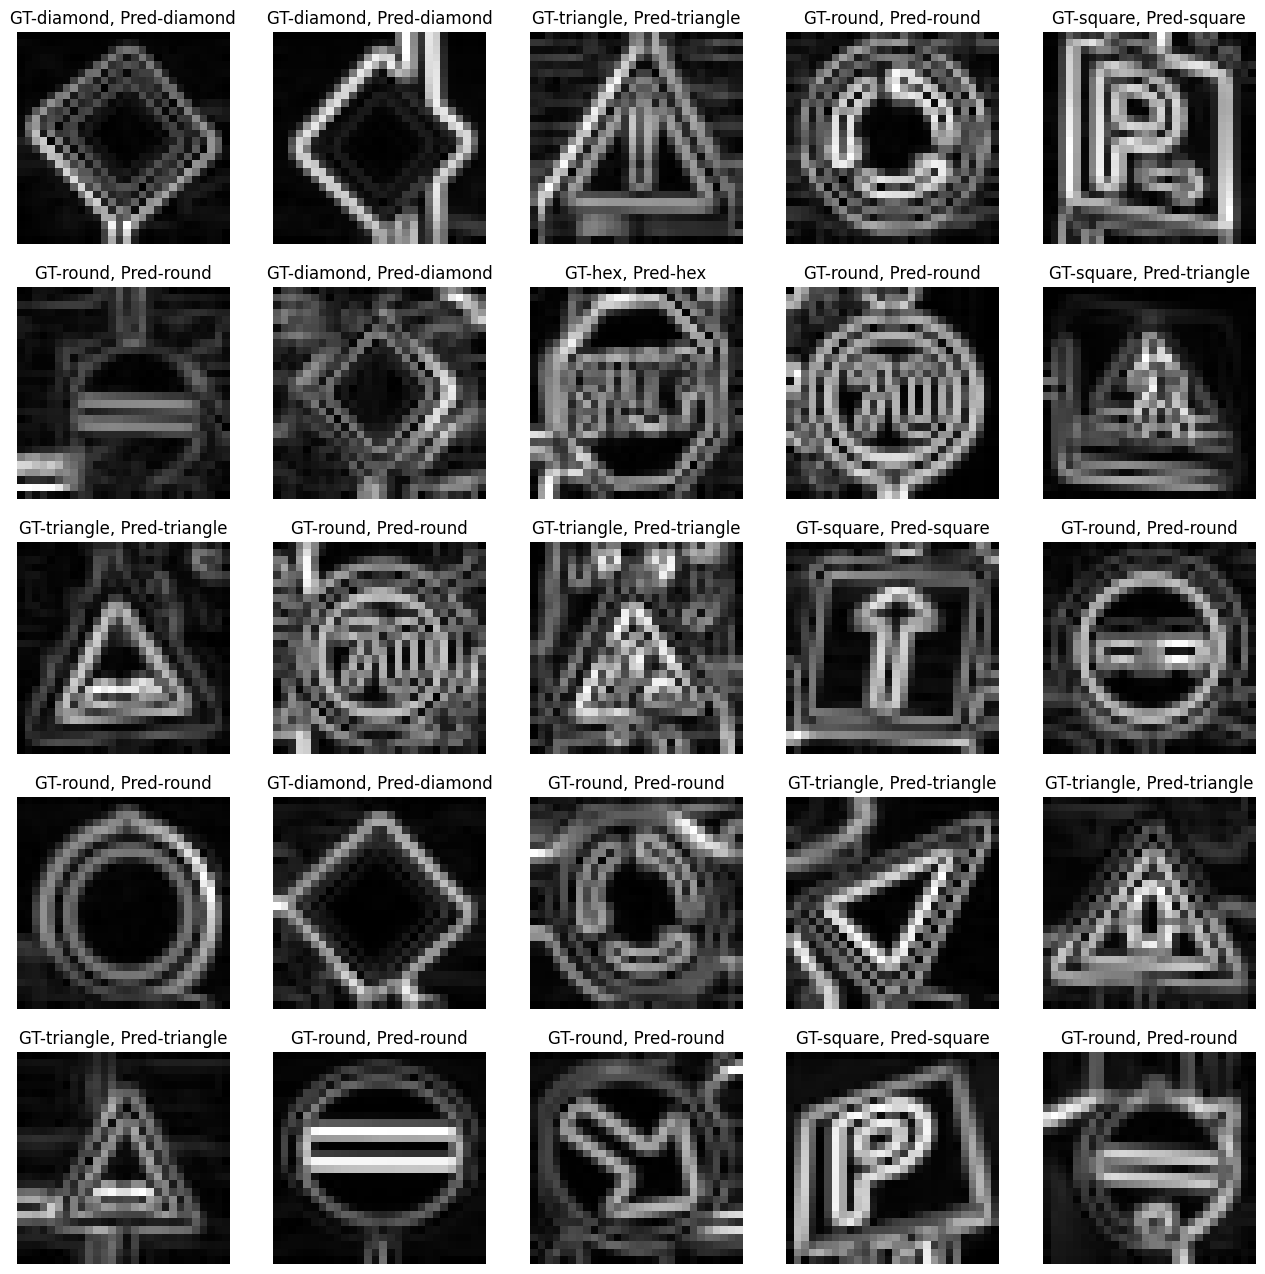

In [102]:
# evaluation set
eval_generator_shape.reset()
eval_shape_cnn_opt_predictions = model_shape_cnn_opt.predict(eval_generator_shape)
eval_shape_cnn_opt_predicted_classes = np.argmax(eval_shape_cnn_opt_predictions, axis=1)

# print classification report
print(classification_report(eval_shape_true_classes, eval_shape_cnn_opt_predicted_classes, target_names=eval_generator_shape.class_indices.keys()))

# display confusion matrix
eval_shape_cnn_opt_cm = ConfusionMatrixDisplay.from_predictions(
    eval_shape_true_classes, eval_shape_cnn_opt_predicted_classes,
    display_labels=eval_generator_shape.class_indices.keys())

# randomly pick images and show prediction
show_image_prediction(model_shape_cnn_opt, "sign_shape", eval_generator_shape.class_indices, eval_data, preprocessing_func)

## Evaluating shape_CNN_GoogLeNet

493/493 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

     diamond       1.00      1.00      1.00        37
         hex       1.00      0.69      0.82        39
       round       0.95      1.00      0.97       253
      square       0.98      0.97      0.97        88
    triangle       0.97      0.99      0.98        76

    accuracy                           0.97       493
   macro avg       0.98      0.93      0.95       493
weighted avg       0.97      0.97      0.96       493

Found 493 validated image filenames belonging to 5 classes.


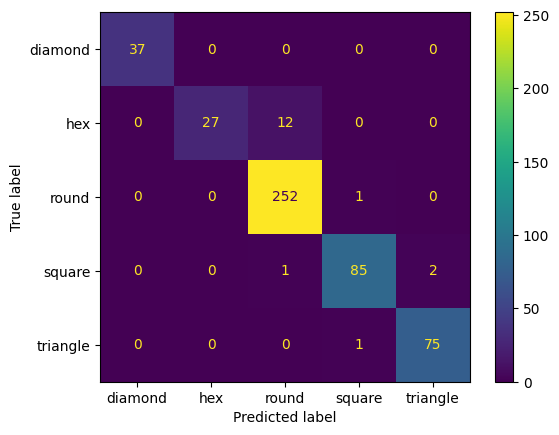

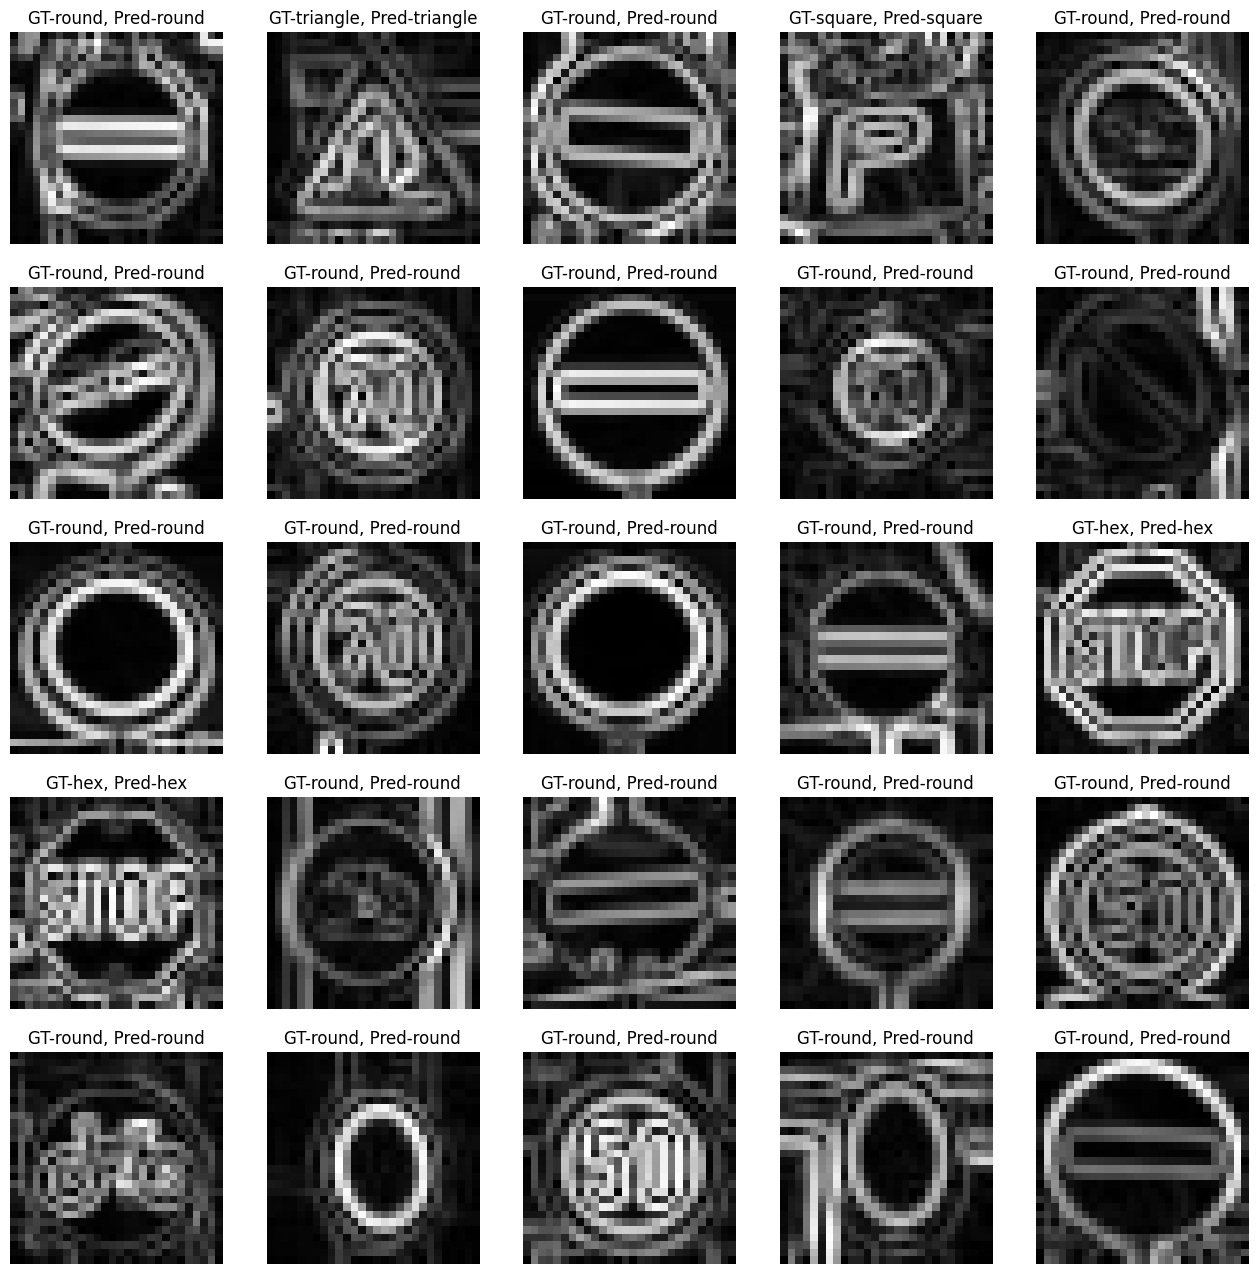

In [103]:
# evaluation set
eval_generator_shape.reset()
eval_shape_cnn_googlenet_predictions = model_shape_cnn_googlenet.predict(eval_generator_shape)
eval_shape_cnn_googlenet_predicted_classes = np.argmax(eval_shape_cnn_googlenet_predictions, axis=1)

# print classification report
print(classification_report(eval_shape_true_classes, eval_shape_cnn_googlenet_predicted_classes, target_names=eval_generator_shape.class_indices.keys()))

# display confusion matrix
eval_shape_cnn_googlenet_cm = ConfusionMatrixDisplay.from_predictions(
    eval_shape_true_classes, eval_shape_cnn_googlenet_predicted_classes,
    display_labels=eval_generator_shape.class_indices.keys())

# randomly select images and print predicted vs actual
show_image_prediction(model_shape_cnn_googlenet, "sign_shape", eval_generator_shape.class_indices, eval_data, preprocessing_func)

## Evaluating type_ANN_1

493/493 [==============================] - 0s 490us/step
                  precision    recall  f1-score   support

         bicycle       0.45      0.56      0.50        27
        continue       0.58      0.70      0.64        20
        crossing       0.95      0.90      0.93        21
         giveway       0.93      0.93      0.93        29
         laneend       0.94      0.77      0.85        22
  limitedtraffic       0.89      0.78      0.83        32
         noentry       0.70      0.84      0.76        38
       noparking       0.61      0.86      0.72        22
         parking       1.00      0.68      0.81        25
      rightofway       0.79      0.89      0.84        37
      roundabout       0.85      0.46      0.59        24
           speed       0.73      0.80      0.76        46
            stop       0.66      0.54      0.59        39
trafficdirective       0.50      0.46      0.48        35
 traveldirection       0.59      0.55      0.57        29
         warni

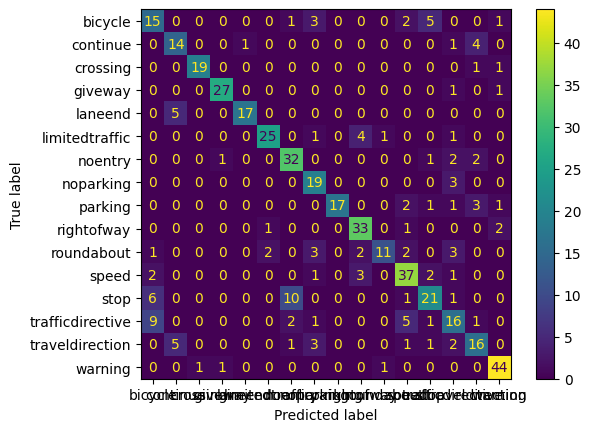

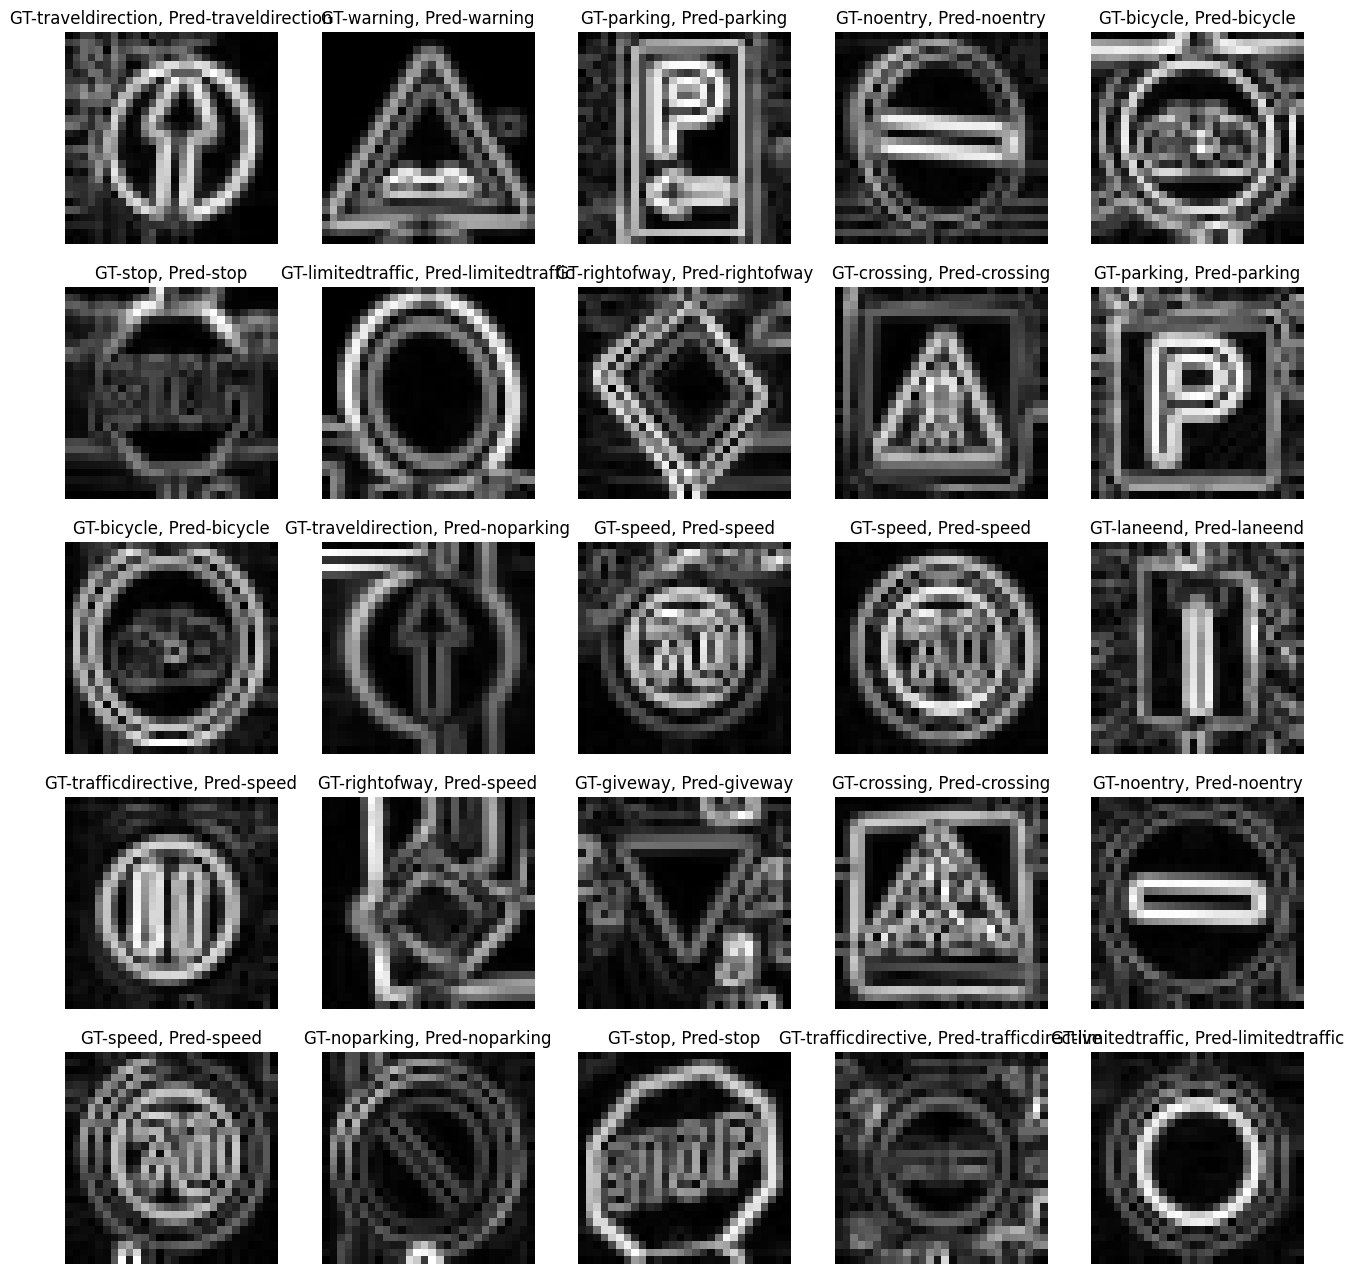

In [104]:
eval_generator_type.reset()
eval_type_ann_1_predictions = model_type_ann_1.predict(eval_generator_type)
eval_type_ann_1_predicted_classes = np.argmax(eval_type_ann_1_predictions, axis=1)

# print classification report
print(classification_report(eval_type_true_classes, eval_type_ann_1_predicted_classes, target_names=eval_generator_type.class_indices.keys()))

# display confusion matrix
eval_type_ann_1_cm = ConfusionMatrixDisplay.from_predictions(
    eval_type_true_classes, eval_type_ann_1_predicted_classes,
    display_labels=eval_generator_type.class_indices.keys())

# randomly pick images and show prediction
show_image_prediction(model_type_ann_1, "sign_type", eval_generator_type.class_indices, eval_data, preprocessing_func)

## Evaluating type_ANN_opt

493/493 [==============================] - 0s 485us/step
                  precision    recall  f1-score   support

         bicycle       0.48      0.59      0.53        27
        continue       0.58      0.75      0.65        20
        crossing       1.00      0.95      0.98        21
         giveway       1.00      0.93      0.96        29
         laneend       1.00      0.77      0.87        22
  limitedtraffic       0.90      0.88      0.89        32
         noentry       0.85      0.89      0.87        38
       noparking       0.64      0.82      0.72        22
         parking       0.90      0.76      0.83        25
      rightofway       0.75      0.89      0.81        37
      roundabout       0.69      0.46      0.55        24
           speed       0.83      0.76      0.80        46
            stop       0.70      0.79      0.75        39
trafficdirective       0.71      0.43      0.54        35
 traveldirection       0.64      0.62      0.63        29
         warni

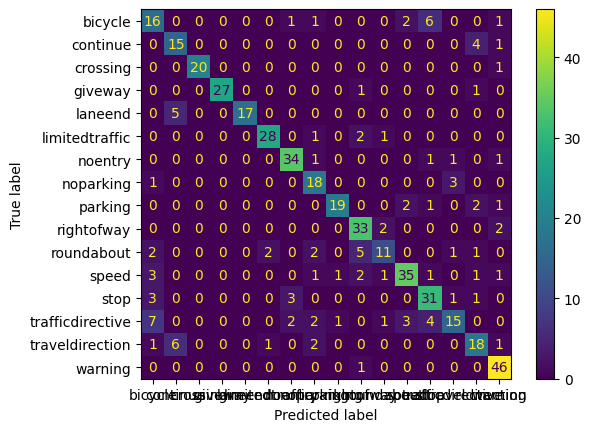

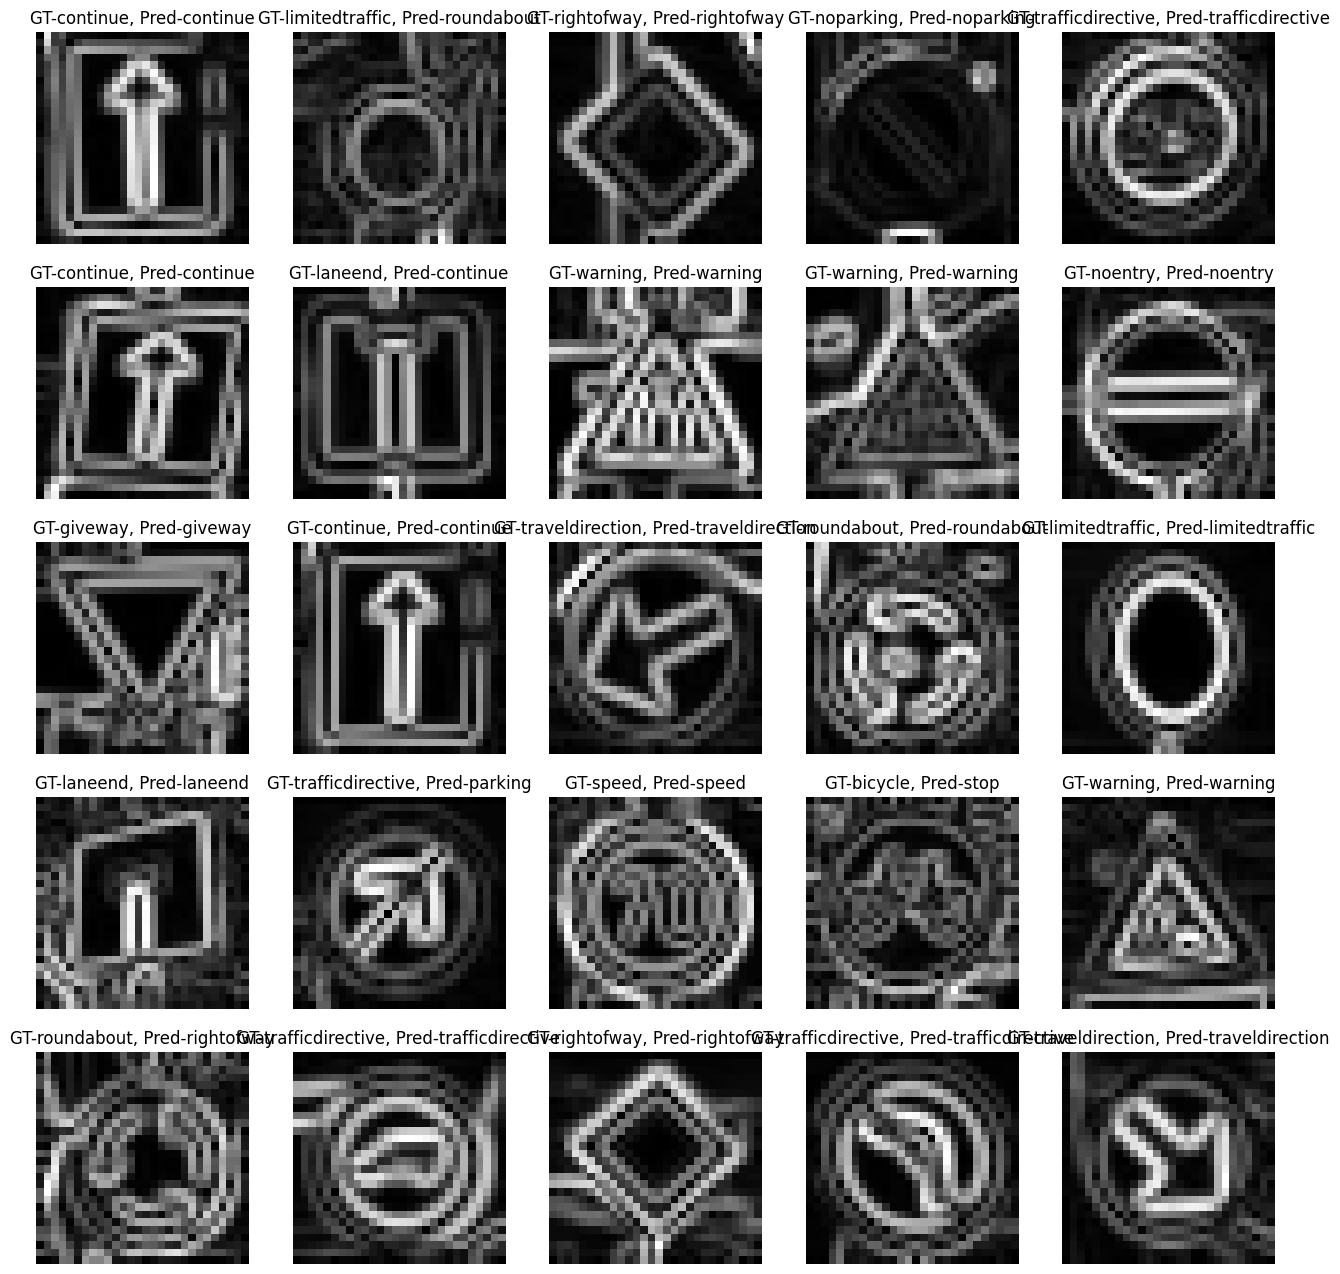

In [105]:
# evaluation set
eval_generator_type.reset()
eval_type_ann_opt_predictions = model_type_ann_opt.predict(eval_generator_type)
eval_type_ann_opt_predicted_classes = np.argmax(eval_type_ann_opt_predictions, axis=1)

# print classification report
print(classification_report(eval_type_true_classes, eval_type_ann_opt_predicted_classes, target_names=eval_generator_type.class_indices.keys()))

# display confusion matrix
eval_type_ann_opt_cm = ConfusionMatrixDisplay.from_predictions(
    eval_type_true_classes, eval_type_ann_opt_predicted_classes,
    display_labels=eval_generator_type.class_indices.keys())

# randomly pick images and show prediction
show_image_prediction(model_type_ann_opt, "sign_type", eval_generator_type.class_indices, eval_data, preprocessing_func)

## Evaluating type_CNN_tl

493/493 [==============================] - 0s 566us/step
                  precision    recall  f1-score   support

         bicycle       0.41      0.85      0.55        27
        continue       0.36      0.75      0.48        20
        crossing       0.90      0.86      0.88        21
         giveway       1.00      0.97      0.98        29
         laneend       0.00      0.00      0.00        22
  limitedtraffic       0.96      0.78      0.86        32
         noentry       0.92      0.95      0.94        38
       noparking       0.70      0.86      0.78        22
         parking       0.88      0.84      0.86        25
      rightofway       0.95      1.00      0.97        37
      roundabout       0.47      0.38      0.42        24
           speed       0.83      0.93      0.88        46
            stop       0.90      0.92      0.91        39
trafficdirective       0.76      0.37      0.50        35
 traveldirection       0.87      0.45      0.59        29
         warni

/Users/ayushpatel/anaconda3/envs/AdvProgramming/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ayushpatel/anaconda3/envs/AdvProgramming/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ayushpatel/anaconda3/envs/AdvProgramming/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

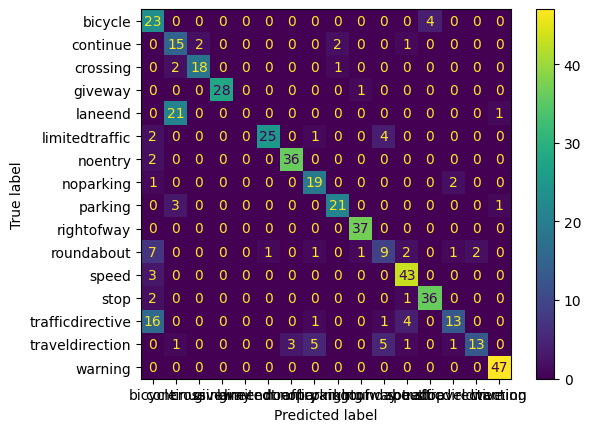

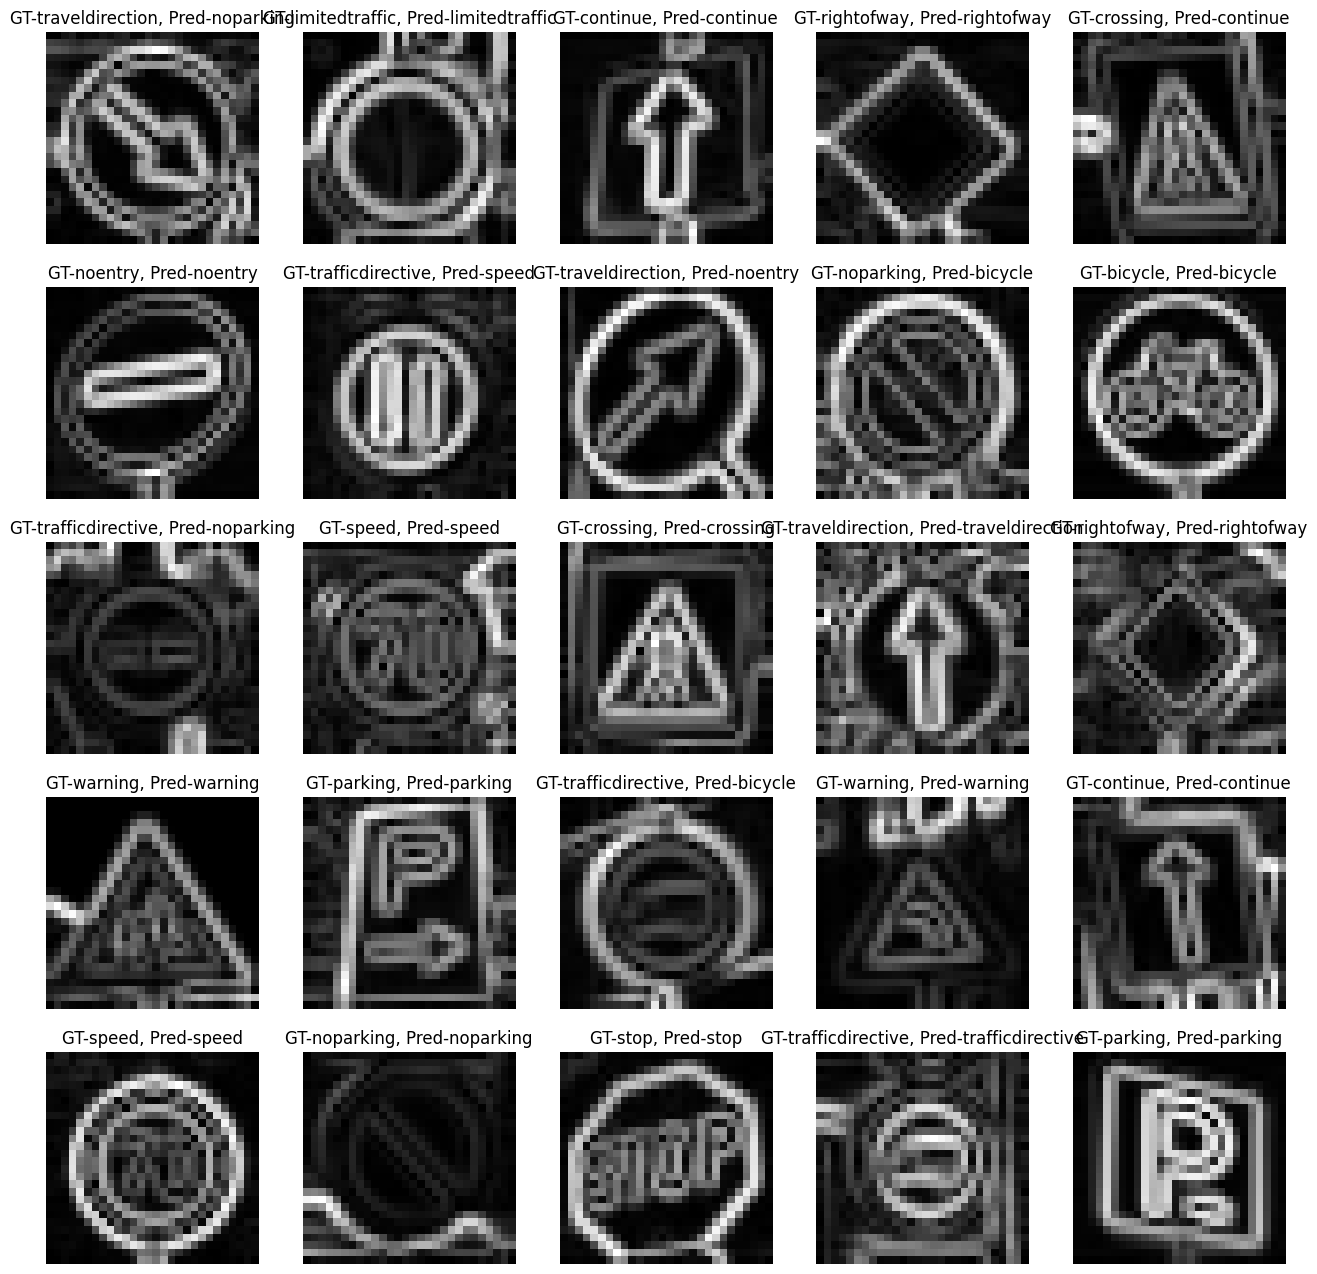

In [106]:
# evaluation set
eval_generator_type.reset()
eval_type_cnn_tl_predictions = model_type_cnn_tl.predict(eval_generator_type)
eval_type_cnn_tl_predicted_classes = np.argmax(eval_type_cnn_tl_predictions, axis=1)

# print classification report
print(classification_report(eval_type_true_classes, eval_type_cnn_tl_predicted_classes, target_names=eval_generator_type.class_indices.keys()))

# display confusion matrix
eval_type_cnn_tl_cm = ConfusionMatrixDisplay.from_predictions(
    eval_type_true_classes, eval_type_cnn_tl_predicted_classes,
    display_labels=eval_generator_type.class_indices.keys())

# randomly pick images and show prediction
show_image_prediction(model_type_cnn_tl, "sign_type", eval_generator_type.class_indices, eval_data, preprocessing_func)

## Evaluating type_CNN_1

493/493 [==============================] - 0s 579us/step
                  precision    recall  f1-score   support

         bicycle       0.63      0.81      0.71        27
        continue       0.64      0.70      0.67        20
        crossing       0.95      1.00      0.98        21
         giveway       0.97      0.97      0.97        29
         laneend       1.00      0.95      0.98        22
  limitedtraffic       0.82      1.00      0.90        32
         noentry       0.97      1.00      0.99        38
       noparking       0.88      1.00      0.94        22
         parking       1.00      1.00      1.00        25
      rightofway       0.97      1.00      0.99        37
      roundabout       1.00      0.71      0.83        24
           speed       0.91      0.87      0.89        46
            stop       0.88      0.92      0.90        39
trafficdirective       0.96      0.74      0.84        35
 traveldirection       0.77      0.59      0.67        29
         warni

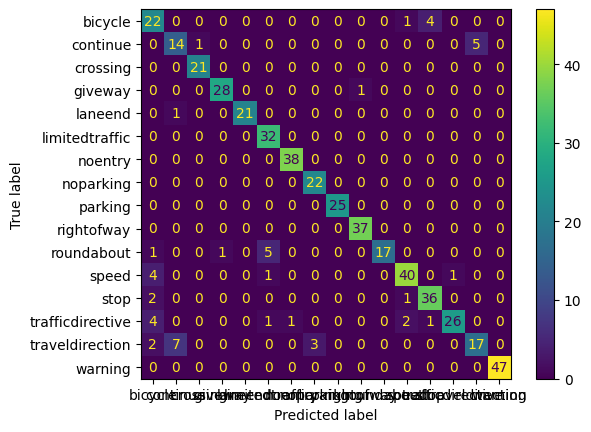

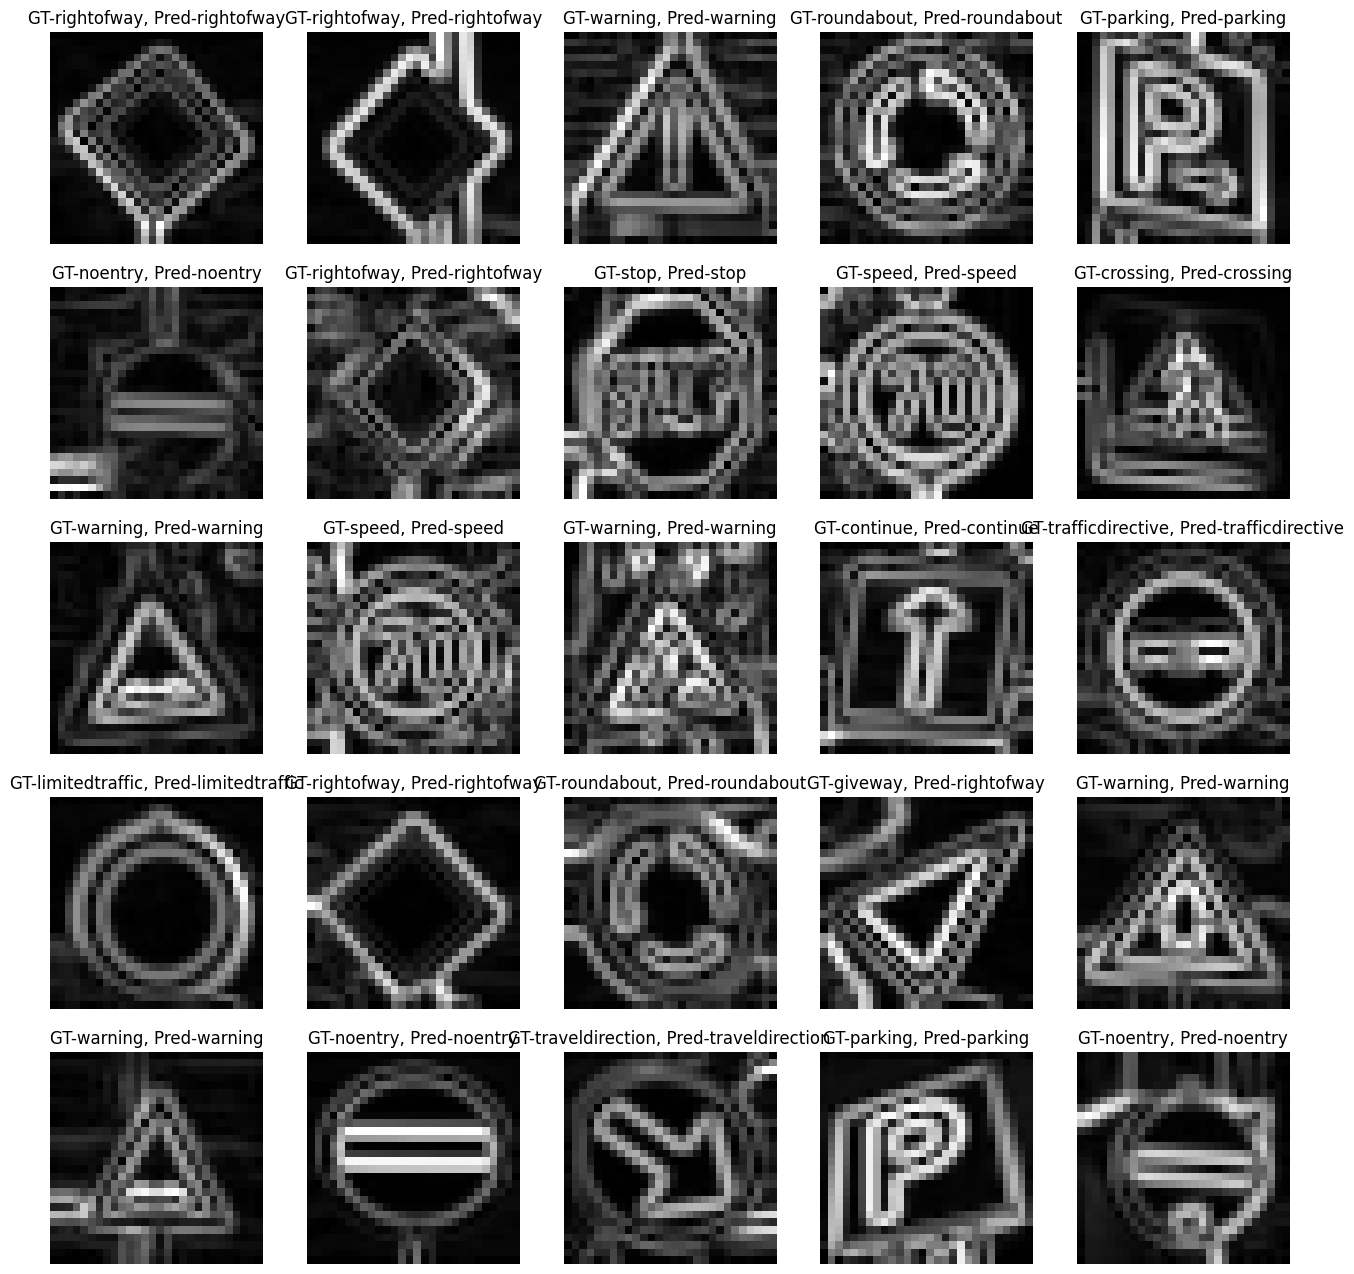

In [107]:
# evaluation set
eval_generator_type.reset()
eval_type_cnn_1_predictions = model_type_cnn_1.predict(eval_generator_type)
eval_type_cnn_1_predicted_classes = np.argmax(eval_type_cnn_1_predictions, axis=1)

# print classification report
print(classification_report(eval_type_true_classes, eval_type_cnn_1_predicted_classes, target_names=eval_generator_type.class_indices.keys()))

# display confusion matrix
eval_type_cnn_1_cm = ConfusionMatrixDisplay.from_predictions(
    eval_type_true_classes, eval_type_cnn_1_predicted_classes,
    display_labels=eval_generator_type.class_indices.keys())

# randomly pick images and show prediction
show_image_prediction(model_type_cnn_1, "sign_type", eval_generator_type.class_indices, eval_data, preprocessing_func)

## Evaluating type_CNN_opt

493/493 [==============================] - 1s 1ms/step
                  precision    recall  f1-score   support

         bicycle       0.67      0.67      0.67        27
        continue       0.45      0.70      0.55        20
        crossing       0.87      0.95      0.91        21
         giveway       1.00      1.00      1.00        29
         laneend       0.93      0.59      0.72        22
  limitedtraffic       0.89      0.97      0.93        32
         noentry       0.97      1.00      0.99        38
       noparking       0.88      1.00      0.94        22
         parking       1.00      1.00      1.00        25
      rightofway       1.00      1.00      1.00        37
      roundabout       0.94      0.67      0.78        24
           speed       0.83      0.93      0.88        46
            stop       0.78      0.97      0.86        39
trafficdirective       0.96      0.71      0.82        35
 traveldirection       1.00      0.52      0.68        29
         warning

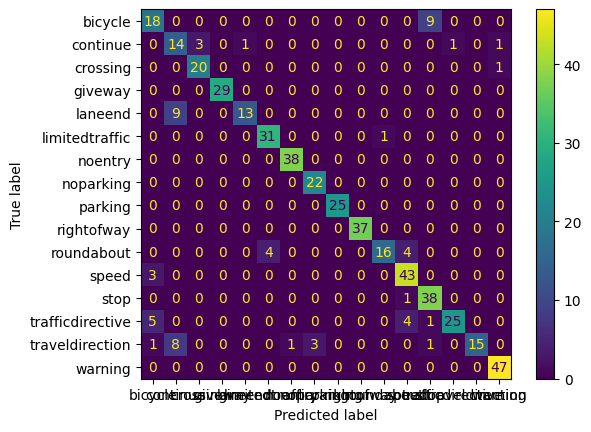

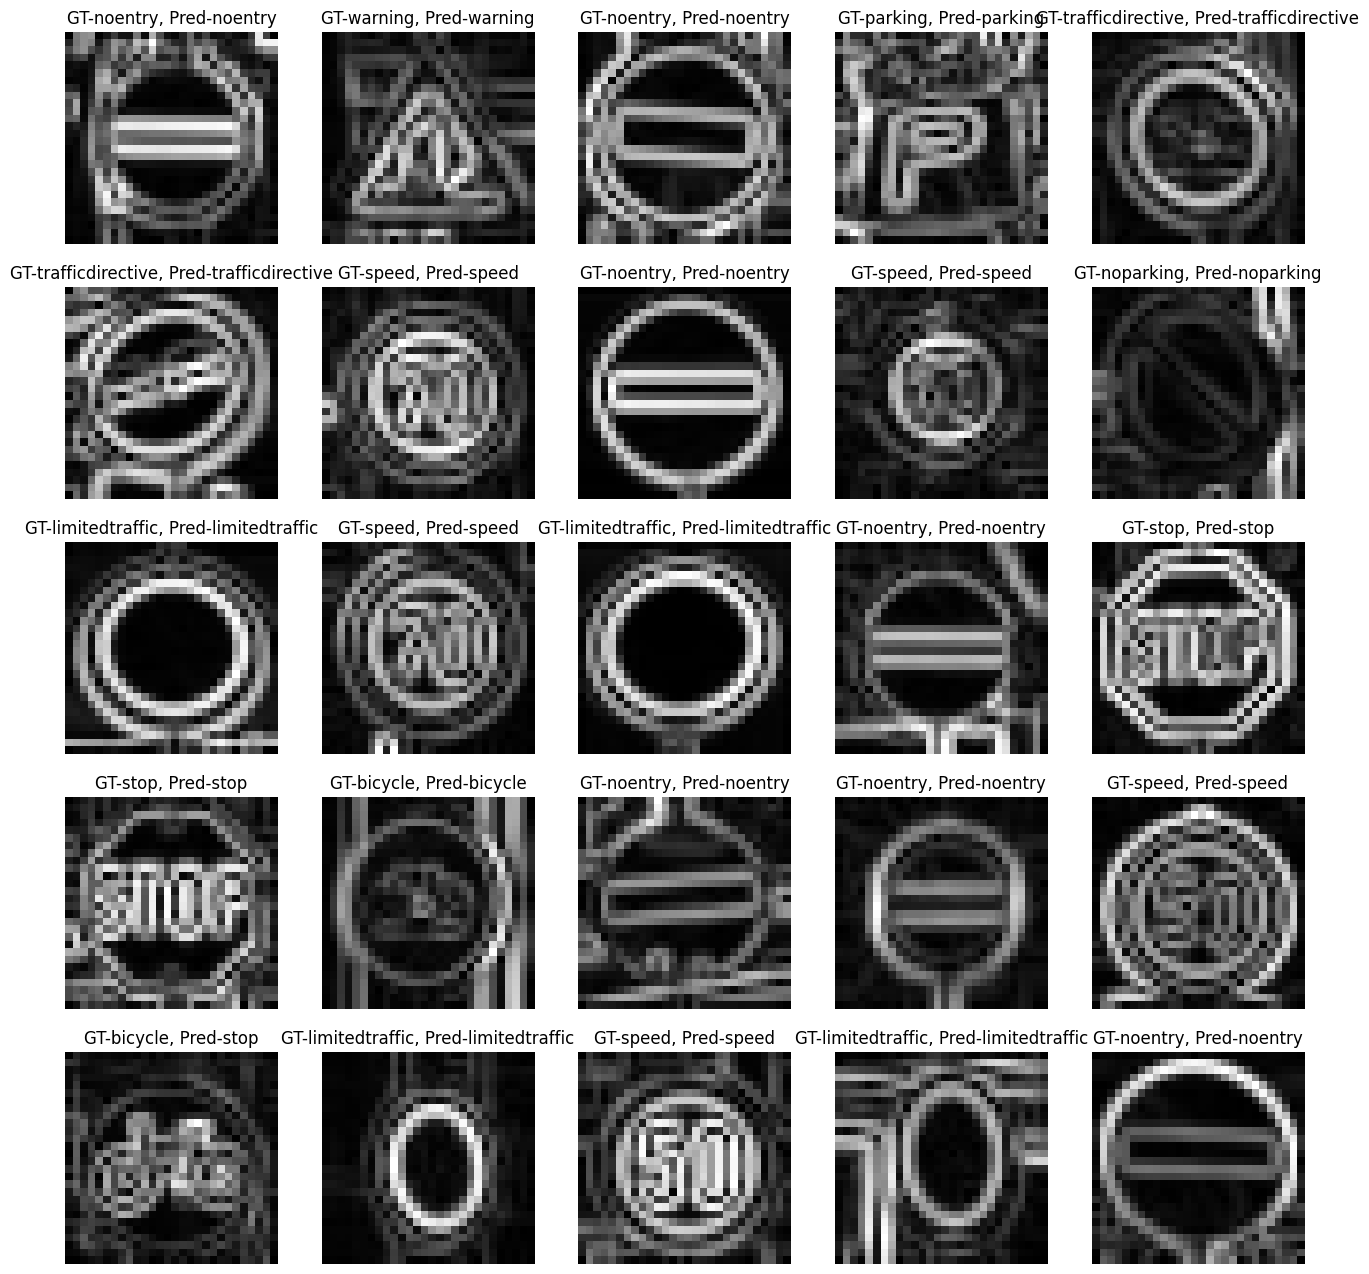

In [108]:
# evaluation set
eval_generator_type.reset()
eval_type_cnn_opt_predictions = model_type_cnn_opt.predict(eval_generator_type)
eval_type_cnn_opt_predicted_classes = np.argmax(eval_type_cnn_opt_predictions, axis=1)

# print classification report
print(classification_report(eval_type_true_classes, eval_type_cnn_opt_predicted_classes, target_names=eval_generator_type.class_indices.keys()))

# display confusion matrix
eval_type_cnn_opt_cm = ConfusionMatrixDisplay.from_predictions(
    eval_type_true_classes, eval_type_cnn_opt_predicted_classes,
    display_labels=eval_generator_type.class_indices.keys())

# randomly pick images and show prediction
show_image_prediction(model_type_cnn_opt, "sign_type", eval_generator_type.class_indices, eval_data, preprocessing_func)

## Evaluating type_CNN_GoogLeNet

493/493 [==============================] - 1s 3ms/step
                  precision    recall  f1-score   support

         bicycle       0.70      0.85      0.77        27
        continue       0.64      0.70      0.67        20
        crossing       0.82      0.67      0.74        21
         giveway       1.00      1.00      1.00        29
         laneend       0.93      0.59      0.72        22
  limitedtraffic       0.85      0.91      0.88        32
         noentry       1.00      0.76      0.87        38
       noparking       0.83      0.91      0.87        22
         parking       0.91      0.80      0.85        25
      rightofway       0.90      1.00      0.95        37
      roundabout       0.89      0.71      0.79        24
           speed       0.86      0.93      0.90        46
            stop       0.90      0.69      0.78        39
trafficdirective       0.75      0.69      0.72        35
 traveldirection       0.67      0.83      0.74        29
         warning

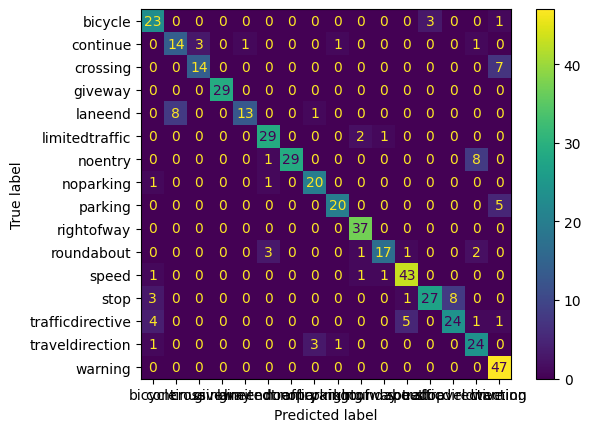

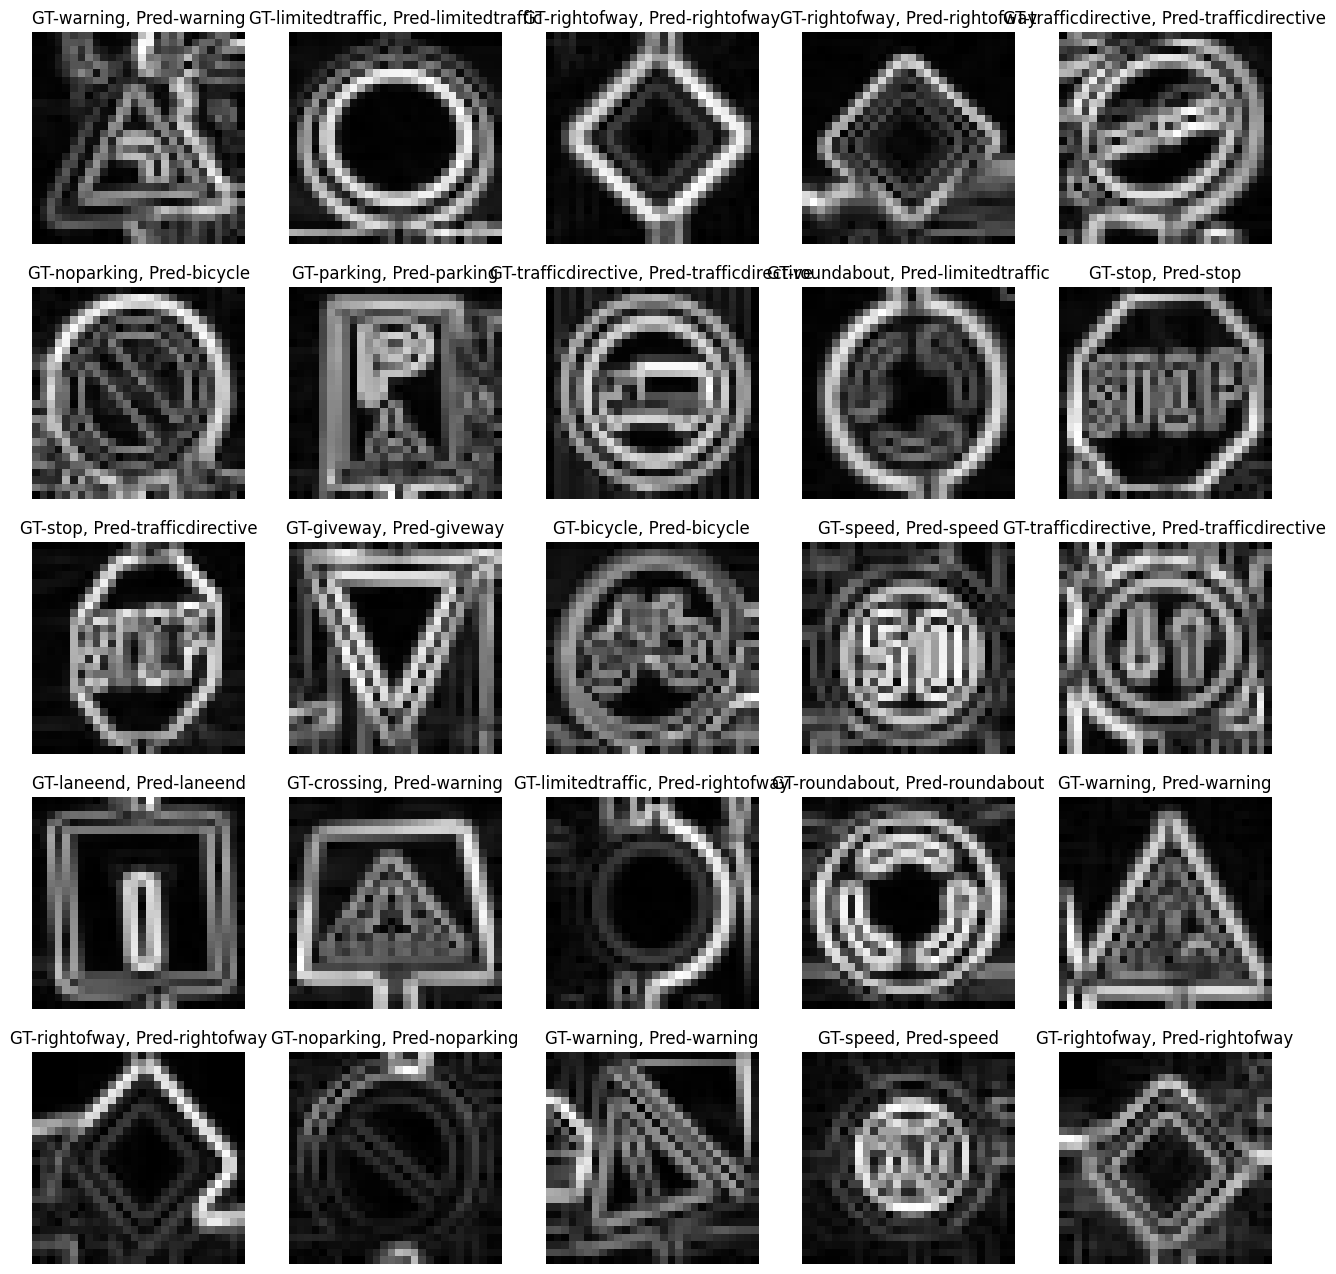

In [109]:
# evaluation set
eval_generator_type.reset()
eval_type_cnn_googlenet_predictions = model_type_cnn_googlenet.predict(eval_generator_shape)
eval_type_cnn_googlenet_predicted_classes = np.argmax(eval_type_cnn_googlenet_predictions, axis=1)

# print classification report
print(classification_report(eval_type_true_classes, eval_type_cnn_googlenet_predicted_classes, target_names=eval_generator_type.class_indices.keys()))

# display confusion matrix
eval_type_cnn_googlenet_cm = ConfusionMatrixDisplay.from_predictions(
    eval_type_true_classes, eval_type_cnn_googlenet_predicted_classes,
    display_labels=eval_generator_type.class_indices.keys())

# randomly select images and print predicted vs actual
show_image_prediction(model_type_cnn_googlenet, "sign_type", eval_generator_type.class_indices, eval_data, preprocessing_func)